TRAINING STOCHASTIC GRADIENT DESCENT MODEL
Training classifier for class 0...
  Class 0, Epoch 0, Loss: 0.3724
  Class 0, Epoch 100, Loss: 0.3696
  Class 0, Epoch 200, Loss: 0.3701
  Class 0, Epoch 300, Loss: 0.3685
Training classifier for class 1...
  Class 1, Epoch 0, Loss: 0.5187
  Class 1, Epoch 100, Loss: 0.5184
  Class 1, Epoch 200, Loss: 0.5184
  Class 1, Epoch 300, Loss: 0.5191
Training classifier for class 2...
  Class 2, Epoch 0, Loss: 0.8316
  Class 2, Epoch 100, Loss: 0.7957
  Class 2, Epoch 200, Loss: 0.7959
  Class 2, Epoch 300, Loss: 0.7964

MODEL EVALUATION
STOCHASTIC GRADIENT DESCENT RESULTS:
Accuracy: 0.5899
Training Time: 53.69 seconds
Log Loss: 0.8542

Classification Report:
              precision    recall  f1-score   support

        Good       0.48      0.12      0.19      1243
        Poor       0.58      0.38      0.46      1902
    Standard       0.60      0.85      0.70      3794

    accuracy                           0.59      6939
   macro avg       0.55 

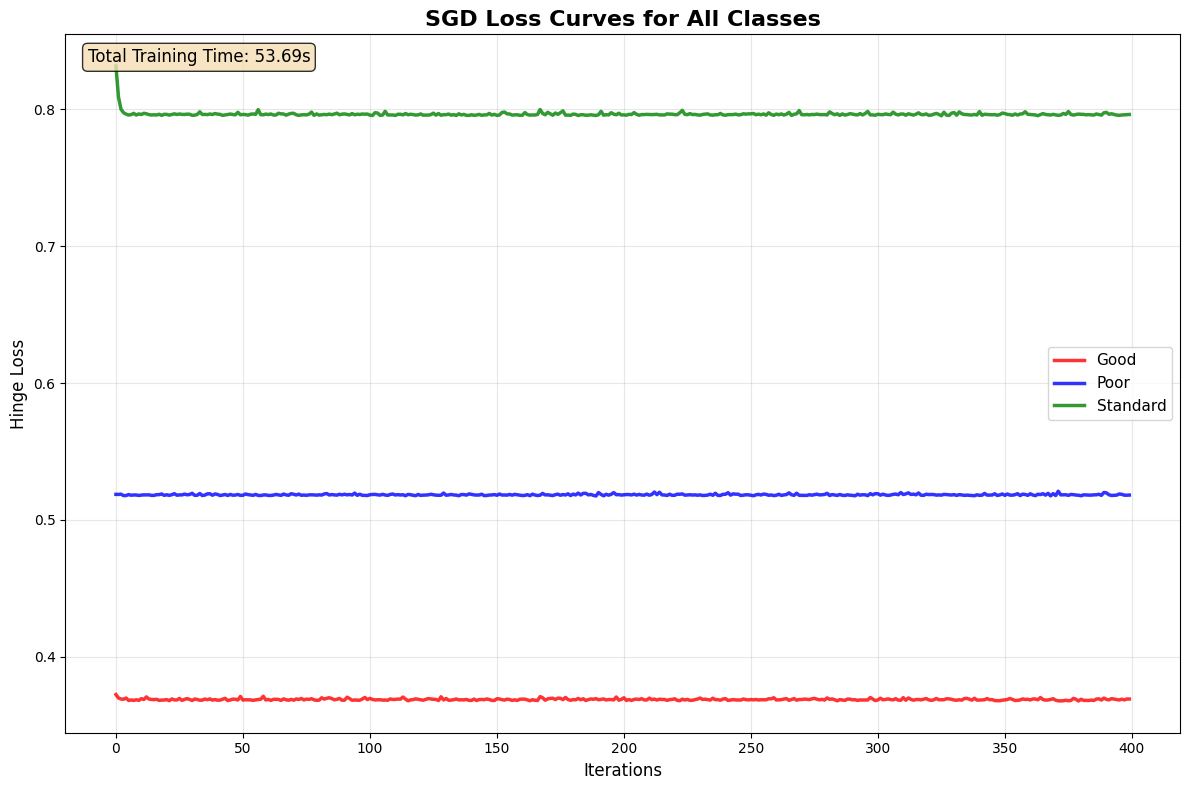


CONVERGENCE ANALYSIS
Total Training Time: 53.69 seconds
Average Time per Class: 17.90 seconds

Class           Final Loss   Convergence Epoch  Improvement 
------------------------------------------------------------
Good            0.3692       2                  0.9         %
Poor            0.5182       3                  0.1         %
Standard        0.7962       3                  4.3         %

Average Statistics:
Average Initial Loss: 0.5742
Average Final Loss: 0.5612
Average Improvement: 2.3%

PERFORMANCE SUMMARY
Accuracy: 0.5899
Training Time: 53.69 seconds
Log Loss: 0.8542
Number of Classes: 3
Iterations per Class: 400

TRAINING COMPLETED


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, log_loss
import time

class SoftMarginSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=400):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.models = {}  # One-vs-Rest models
        self.loss_history = {}  # Loss history for each class

    def hinge_loss(self, X, y, w, b):
        """计算hinge loss"""
        distances = 1 - y * (np.dot(X, w) - b)
        distances[distances < 0] = 0  # max(0, distance)
        hinge_loss = self.lambda_param * np.dot(w, w) + np.mean(distances)
        return hinge_loss

    def fit_binary_classifier(self, X, y_binary, class_label):
        """训练一个二分类器（One-vs-Rest）"""
        n_samples, n_features = X.shape
        w = np.zeros(n_features)
        b = 0
        losses = []

        print(f"Training classifier for class {class_label}...")

        for epoch in range(self.n_iters):
            # Stochastic Gradient Descent
            indices = np.random.permutation(n_samples)
            for i in indices:
                condition = y_binary[i] * (np.dot(X[i], w) - b) >= 1
                if condition:
                    gradient_w = 2 * self.lambda_param * w
                    gradient_b = 0
                else:
                    gradient_w = 2 * self.lambda_param * w - y_binary[i] * X[i]
                    gradient_b = y_binary[i]

                w -= self.learning_rate * gradient_w
                b -= self.learning_rate * gradient_b

            # Calculate loss for this epoch
            epoch_loss = self.hinge_loss(X, y_binary, w, b)
            losses.append(epoch_loss)

            if epoch % 100 == 0:
                print(f"  Class {class_label}, Epoch {epoch}, Loss: {epoch_loss:.4f}")

        self.loss_history[class_label] = losses
        return w, b

    def fit(self, X, y):
        """训练One-vs-Rest多分类SVM"""
        self.classes_ = np.unique(y)

        for class_label in self.classes_:
            # Create binary labels for One-vs-Rest
            y_binary = np.where(y == class_label, 1, -1)

            # Train binary classifier
            w, b = self.fit_binary_classifier(X, y_binary, class_label)
            self.models[class_label] = {'weights': w, 'bias': b}

    def predict_proba(self, X):
        """预测概率"""
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        scores = np.zeros((n_samples, n_classes))

        for i, class_label in enumerate(self.classes_):
            model = self.models[class_label]
            scores[:, i] = np.dot(X, model['weights']) - model['bias']

        # Convert scores to probabilities using softmax
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return probabilities

    def predict(self, X):
        """预测类别"""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

# 数据读取与处理
train_data = pd.read_csv('train_data_s.csv')
test_data = pd.read_csv('test_data.csv')

# 数据预处理
def convert_to_float(age_str):
    if isinstance(age_str, str):
        years, months = map(int, age_str.replace('Years and', '').replace('Months', '').split())
        return years + months / 12.0
    return age_str

train_data['Credit_History_Age'] = train_data['Credit_History_Age'].apply(convert_to_float)
test_data['Credit_History_Age'] = test_data['Credit_History_Age'].apply(convert_to_float)

credit_mix_mapping = {
    'Good': 1.0,
    'Standard': 0.5,
    'Bad': 0.0
}
train_data['Credit_Mix'] = train_data['Credit_Mix'].map(credit_mix_mapping)
test_data['Credit_Mix'] = test_data['Credit_Mix'].map(credit_mix_mapping)

unique_behaviors = train_data['Payment_Behaviour'].unique()
behavior_mapping = {behavior: idx for idx, behavior in enumerate(unique_behaviors)}
train_data['Payment_Behaviour'] = train_data['Payment_Behaviour'].map(behavior_mapping)
test_data['Payment_Behaviour'] = test_data['Payment_Behaviour'].map(behavior_mapping)

train_data = train_data.dropna()
test_data = test_data.dropna()

# 特征选择
features = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
            'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
            'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
            'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
            'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

X_train = train_data[features]
y_train = train_data['Credit_Score']
X_test = test_data[features]
y_test = test_data['Credit_Score']

# 标签编码
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 训练SGD模型
print("=" * 60)
print("TRAINING STOCHASTIC GRADIENT DESCENT MODEL")
print("=" * 60)
sgd_start_time = time.time()

sgd_model = SoftMarginSVM(
    learning_rate=0.001,
    lambda_param=0.01,
    n_iters=400
)
sgd_model.fit(X_train_scaled, y_train_encoded)

sgd_end_time = time.time()
sgd_time = sgd_end_time - sgd_start_time

# 预测和评估
print("\n" + "=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# SGD模型预测
y_pred_sgd = sgd_model.predict(X_test_scaled)
y_proba_sgd = sgd_model.predict_proba(X_test_scaled)

print("STOCHASTIC GRADIENT DESCENT RESULTS:")
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred_sgd):.4f}")
print(f"Training Time: {sgd_time:.2f} seconds")
print(f"Log Loss: {log_loss(y_test_encoded, y_proba_sgd):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_sgd,
                          target_names=le.classes_))

# 绘制三个类别的loss曲线在同一张图中
plt.figure(figsize=(12, 8))

# 定义颜色和线型
colors = ['red', 'blue', 'green']
class_names = le.classes_

# 在同一张图中绘制三个类别的loss曲线
for idx, class_label in enumerate(sgd_model.classes_):
    losses = sgd_model.loss_history[class_label]
    plt.plot(losses, label=f'{class_names[class_label]}',
             color=colors[idx], linewidth=2.5, alpha=0.8)

plt.title('SGD Loss Curves for All Classes', fontsize=16, fontweight='bold')
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Hinge Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# 添加训练时间信息
plt.text(0.02, 0.98, f'Total Training Time: {sgd_time:.2f}s',
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()

# 显示每个类别的最终损失值和收敛分析
print("\n" + "=" * 60)
print("CONVERGENCE ANALYSIS")
print("=" * 60)
print(f"Total Training Time: {sgd_time:.2f} seconds")
print(f"Average Time per Class: {sgd_time / len(sgd_model.classes_):.2f} seconds")

print(f"\n{'Class':<15} {'Final Loss':<12} {'Convergence Epoch':<18} {'Improvement':<12}")
print("-" * 60)

for class_label in sgd_model.classes_:
    losses = sgd_model.loss_history[class_label]
    final_loss = losses[-1]
    initial_loss = losses[0]

    # 找到收敛点（损失下降90%的epoch）
    target_loss = initial_loss - 0.9 * (initial_loss - final_loss)
    convergence_epoch = next((i for i, loss in enumerate(losses) if loss <= target_loss), len(losses))

    improvement = initial_loss - final_loss
    improvement_pct = (improvement / initial_loss) * 100

    print(f"{class_names[class_label]:<15} {final_loss:<12.4f} {convergence_epoch:<18} {improvement_pct:<12.1f}%")

# 计算平均收敛统计
initial_losses = [sgd_model.loss_history[cls][0] for cls in sgd_model.classes_]
final_losses = [sgd_model.loss_history[cls][-1] for cls in sgd_model.classes_]
avg_initial_loss = np.mean(initial_losses)
avg_final_loss = np.mean(final_losses)
avg_improvement = ((avg_initial_loss - avg_final_loss) / avg_initial_loss) * 100

print(f"\nAverage Statistics:")
print(f"Average Initial Loss: {avg_initial_loss:.4f}")
print(f"Average Final Loss: {avg_final_loss:.4f}")
print(f"Average Improvement: {avg_improvement:.1f}%")

# 性能总结
print("\n" + "=" * 60)
print("PERFORMANCE SUMMARY")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred_sgd):.4f}")
print(f"Training Time: {sgd_time:.2f} seconds")
print(f"Log Loss: {log_loss(y_test_encoded, y_proba_sgd):.4f}")
print(f"Number of Classes: {len(sgd_model.classes_)}")
print(f"Iterations per Class: {sgd_model.n_iters}")

print("\n" + "=" * 60)
print("TRAINING COMPLETED")
print("=" * 60)

TRAINING STOCHASTIC GRADIENT DESCENT MODEL
Training until convergence...
Training classifier for class 0...
  Class 0, Epoch 0, Loss: 0.3729
  Class 0 converged at epoch 19
Training classifier for class 1...
  Class 1, Epoch 0, Loss: 0.5192
  Class 1 converged at epoch 18
Training classifier for class 2...
  Class 2, Epoch 0, Loss: 0.8318
  Class 2 converged at epoch 21

MODEL EVALUATION
STOCHASTIC GRADIENT DESCENT RESULTS:
Accuracy: 0.5913
Training Time: 2.55 seconds
Log Loss: 0.8580

Classification Report:
              precision    recall  f1-score   support

        Good       0.47      0.10      0.16      1243
        Poor       0.59      0.37      0.45      1902
    Standard       0.60      0.86      0.71      3794

    accuracy                           0.59      6939
   macro avg       0.55      0.44      0.44      6939
weighted avg       0.57      0.59      0.54      6939



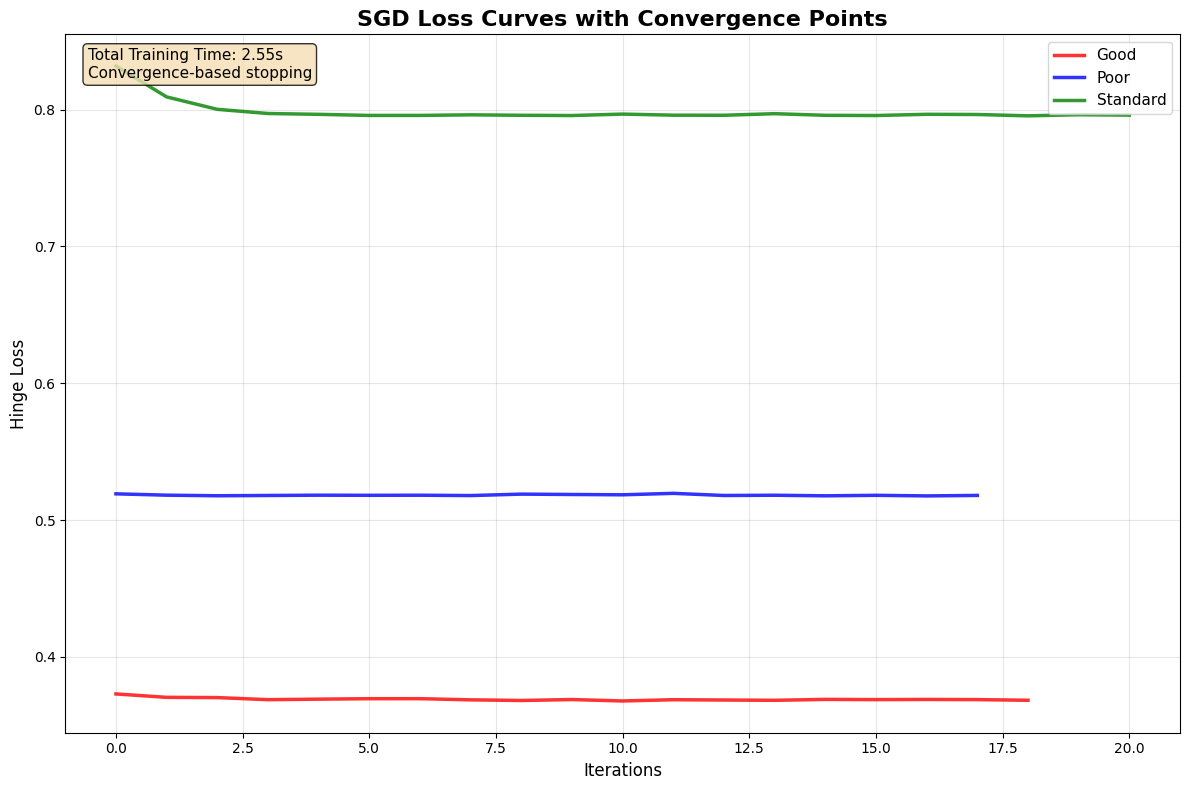


CONVERGENCE ANALYSIS
Total Training Time: 2.55 seconds

Class           Training Time(s) Convergence Epoch  Final Loss   Improvement 
---------------------------------------------------------------------------
Good            0.79            19                 0.3683       1.2         %
Poor            0.73            18                 0.5180       0.2         %
Standard        1.03            21                 0.7960       4.3         %

Average Statistics:
Average Training Time per Class: 0.85 seconds
Average Convergence Epoch: 19.3
Average Initial Loss: 0.5746
Average Final Loss: 0.5608
Average Improvement: 2.4%

PERFORMANCE SUMMARY
Accuracy: 0.5913
Total Training Time: 2.55 seconds
Log Loss: 0.8580
Number of Classes: 3
Maximum Iterations: 400
Actual Average Iterations: 19.3
Time Saved by Early Stopping: 95.2%

TRAINING COMPLETED WITH CONVERGENCE-BASED STOPPING


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, log_loss
import time

class SoftMarginSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=400, convergence_threshold=0.001, patience=20):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.convergence_threshold = convergence_threshold
        self.patience = patience
        self.models = {}  # One-vs-Rest models
        self.loss_history = {}  # Loss history for each class
        self.convergence_epochs = {}  # 记录每个类别的收敛epoch

    def hinge_loss(self, X, y, w, b):
        """计算hinge loss"""
        distances = 1 - y * (np.dot(X, w) - b)
        distances[distances < 0] = 0  # max(0, distance)
        hinge_loss = self.lambda_param * np.dot(w, w) + np.mean(distances)
        return hinge_loss

    def fit_binary_classifier(self, X, y_binary, class_label):
        """训练一个二分类器（One-vs-Rest）"""
        n_samples, n_features = X.shape
        w = np.zeros(n_features)
        b = 0
        losses = []

        print(f"Training classifier for class {class_label}...")

        best_loss = float('inf')
        no_improvement_count = 0
        convergence_epoch = self.n_iters  # 默认收敛epoch为最大迭代次数

        for epoch in range(self.n_iters):
            # Stochastic Gradient Descent
            indices = np.random.permutation(n_samples)
            for i in indices:
                condition = y_binary[i] * (np.dot(X[i], w) - b) >= 1
                if condition:
                    gradient_w = 2 * self.lambda_param * w
                    gradient_b = 0
                else:
                    gradient_w = 2 * self.lambda_param * w - y_binary[i] * X[i]
                    gradient_b = y_binary[i]

                w -= self.learning_rate * gradient_w
                b -= self.learning_rate * gradient_b

            # Calculate loss for this epoch
            epoch_loss = self.hinge_loss(X, y_binary, w, b)
            losses.append(epoch_loss)

            # 检查收敛
            if epoch_loss < best_loss - self.convergence_threshold:
                best_loss = epoch_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            # 如果连续patience个epoch没有显著改进，则提前停止
            if no_improvement_count >= self.patience:
                convergence_epoch = epoch + 1
                print(f"  Class {class_label} converged at epoch {convergence_epoch}")
                break

            if epoch % 100 == 0:
                print(f"  Class {class_label}, Epoch {epoch}, Loss: {epoch_loss:.4f}")

        self.loss_history[class_label] = losses
        self.convergence_epochs[class_label] = convergence_epoch
        return w, b

    def fit(self, X, y):
        """训练One-vs-Rest多分类SVM"""
        self.classes_ = np.unique(y)

        # 记录每个类别的训练时间
        self.class_training_times = {}

        for class_label in self.classes_:
            # Create binary labels for One-vs-Rest
            y_binary = np.where(y == class_label, 1, -1)

            # 记录单个类别的训练时间
            class_start_time = time.time()

            # Train binary classifier
            w, b = self.fit_binary_classifier(X, y_binary, class_label)
            self.models[class_label] = {'weights': w, 'bias': b}

            class_end_time = time.time()
            self.class_training_times[class_label] = class_end_time - class_start_time

    def predict_proba(self, X):
        """预测概率"""
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        scores = np.zeros((n_samples, n_classes))

        for i, class_label in enumerate(self.classes_):
            model = self.models[class_label]
            scores[:, i] = np.dot(X, model['weights']) - model['bias']

        # Convert scores to probabilities using softmax
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return probabilities

    def predict(self, X):
        """预测类别"""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

# 数据读取与处理
train_data = pd.read_csv('train_data_s.csv')
test_data = pd.read_csv('test_data.csv')

# 数据预处理
def convert_to_float(age_str):
    if isinstance(age_str, str):
        years, months = map(int, age_str.replace('Years and', '').replace('Months', '').split())
        return years + months / 12.0
    return age_str

train_data['Credit_History_Age'] = train_data['Credit_History_Age'].apply(convert_to_float)
test_data['Credit_History_Age'] = test_data['Credit_History_Age'].apply(convert_to_float)

credit_mix_mapping = {
    'Good': 1.0,
    'Standard': 0.5,
    'Bad': 0.0
}
train_data['Credit_Mix'] = train_data['Credit_Mix'].map(credit_mix_mapping)
test_data['Credit_Mix'] = test_data['Credit_Mix'].map(credit_mix_mapping)

unique_behaviors = train_data['Payment_Behaviour'].unique()
behavior_mapping = {behavior: idx for idx, behavior in enumerate(unique_behaviors)}
train_data['Payment_Behaviour'] = train_data['Payment_Behaviour'].map(behavior_mapping)
test_data['Payment_Behaviour'] = test_data['Payment_Behaviour'].map(behavior_mapping)

train_data = train_data.dropna()
test_data = test_data.dropna()

# 特征选择
features = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
            'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
            'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
            'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
            'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

X_train = train_data[features]
y_train = train_data['Credit_Score']
X_test = test_data[features]
y_test = test_data['Credit_Score']

# 标签编码
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 训练SGD模型
print("=" * 60)
print("TRAINING STOCHASTIC GRADIENT DESCENT MODEL")
print("=" * 60)
print("Training until convergence...")

sgd_start_time = time.time()

sgd_model = SoftMarginSVM(
    learning_rate=0.001,
    lambda_param=0.01,
    n_iters=400,
    convergence_threshold=0.001,  # 收敛阈值
    patience=15  # 连续15个epoch没有改进则停止
)
sgd_model.fit(X_train_scaled, y_train_encoded)

sgd_end_time = time.time()
sgd_time = sgd_end_time - sgd_start_time

# 预测和评估
print("\n" + "=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# SGD模型预测
y_pred_sgd = sgd_model.predict(X_test_scaled)
y_proba_sgd = sgd_model.predict_proba(X_test_scaled)

print("STOCHASTIC GRADIENT DESCENT RESULTS:")
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred_sgd):.4f}")
print(f"Training Time: {sgd_time:.2f} seconds")
print(f"Log Loss: {log_loss(y_test_encoded, y_proba_sgd):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_sgd,
                          target_names=le.classes_))

# 绘制三个类别的loss曲线在同一张图中
plt.figure(figsize=(12, 8))

# 定义颜色和线型
colors = ['red', 'blue', 'green']
class_names = le.classes_

# 在同一张图中绘制三个类别的loss曲线
for idx, class_label in enumerate(sgd_model.classes_):
    losses = sgd_model.loss_history[class_label]
    convergence_epoch = sgd_model.convergence_epochs[class_label]

    # 绘制完整曲线
    plt.plot(losses, label=f'{class_names[class_label]}',
             color=colors[idx], linewidth=2.5, alpha=0.8)

    # 标记收敛点
    if convergence_epoch < len(losses):
        plt.axvline(x=convergence_epoch, color=colors[idx], linestyle='--', alpha=0.6)
        plt.scatter(convergence_epoch, losses[convergence_epoch-1],
                   color=colors[idx], s=50, zorder=5)

plt.title('SGD Loss Curves with Convergence Points', fontsize=16, fontweight='bold')
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Hinge Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# 添加训练时间信息
convergence_info = f'Total Training Time: {sgd_time:.2f}s\nConvergence-based stopping'
plt.text(0.02, 0.98, convergence_info,
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()

# 显示每个类别的最终损失值和收敛分析
print("\n" + "=" * 60)
print("CONVERGENCE ANALYSIS")
print("=" * 60)
print(f"Total Training Time: {sgd_time:.2f} seconds")

print(f"\n{'Class':<15} {'Training Time(s)':<15} {'Convergence Epoch':<18} {'Final Loss':<12} {'Improvement':<12}")
print("-" * 75)

total_convergence_time = 0
for class_label in sgd_model.classes_:
    losses = sgd_model.loss_history[class_label]
    class_time = sgd_model.class_training_times[class_label]
    convergence_epoch = sgd_model.convergence_epochs[class_label]
    final_loss = losses[-1]
    initial_loss = losses[0]

    improvement = initial_loss - final_loss
    improvement_pct = (improvement / initial_loss) * 100

    print(f"{class_names[class_label]:<15} {class_time:<15.2f} {convergence_epoch:<18} {final_loss:<12.4f} {improvement_pct:<12.1f}%")

    total_convergence_time += class_time

# 计算平均收敛统计
initial_losses = [sgd_model.loss_history[cls][0] for cls in sgd_model.classes_]
final_losses = [sgd_model.loss_history[cls][-1] for cls in sgd_model.classes_]
convergence_epochs = [sgd_model.convergence_epochs[cls] for cls in sgd_model.classes_]
class_times = [sgd_model.class_training_times[cls] for cls in sgd_model.classes_]

avg_initial_loss = np.mean(initial_losses)
avg_final_loss = np.mean(final_losses)
avg_convergence_epoch = np.mean(convergence_epochs)
avg_class_time = np.mean(class_times)
avg_improvement = ((avg_initial_loss - avg_final_loss) / avg_initial_loss) * 100

print(f"\nAverage Statistics:")
print(f"Average Training Time per Class: {avg_class_time:.2f} seconds")
print(f"Average Convergence Epoch: {avg_convergence_epoch:.1f}")
print(f"Average Initial Loss: {avg_initial_loss:.4f}")
print(f"Average Final Loss: {avg_final_loss:.4f}")
print(f"Average Improvement: {avg_improvement:.1f}%")

# 性能总结
print("\n" + "=" * 60)
print("PERFORMANCE SUMMARY")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred_sgd):.4f}")
print(f"Total Training Time: {sgd_time:.2f} seconds")
print(f"Log Loss: {log_loss(y_test_encoded, y_proba_sgd):.4f}")
print(f"Number of Classes: {len(sgd_model.classes_)}")
print(f"Maximum Iterations: {sgd_model.n_iters}")
print(f"Actual Average Iterations: {avg_convergence_epoch:.1f}")
print(f"Time Saved by Early Stopping: {(1 - avg_convergence_epoch/sgd_model.n_iters)*100:.1f}%")

print("\n" + "=" * 60)
print("TRAINING COMPLETED WITH CONVERGENCE-BASED STOPPING")
print("=" * 60)

TRAINING STOCHASTIC GRADIENT DESCENT MODEL
Training until convergence...
Training classifier for class 0...
  Class 0, Epoch 0, Loss: 0.3730
  Class 0 converged at epoch 20
Training classifier for class 1...
  Class 1, Epoch 0, Loss: 0.5225
  Class 1 converged at epoch 16
Training classifier for class 2...
  Class 2, Epoch 0, Loss: 0.8219
  Class 2 converged at epoch 24

MODEL EVALUATION
STOCHASTIC GRADIENT DESCENT RESULTS:
Accuracy: 0.5950
Training Time: 4.22 seconds
Log Loss: 0.8471

Classification Report:
              precision    recall  f1-score   support

        Good       0.44      0.12      0.19      1243
        Poor       0.61      0.40      0.49      1902
    Standard       0.60      0.85      0.70      3794

    accuracy                           0.60      6939
   macro avg       0.55      0.46      0.46      6939
weighted avg       0.57      0.60      0.55      6939



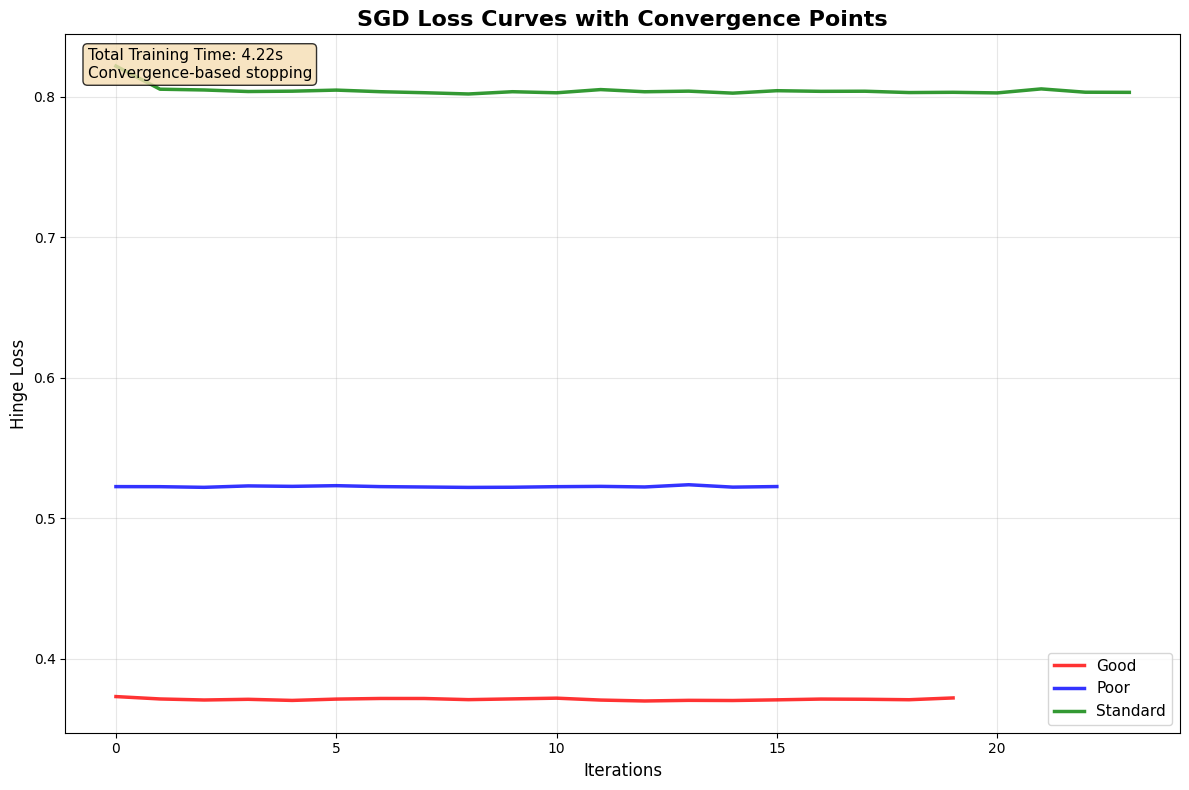


CONVERGENCE ANALYSIS
Total Training Time: 4.22 seconds

Class           Training Time(s) Convergence Epoch  Final Loss   Improvement 
---------------------------------------------------------------------------
Good            1.27            20                 0.3720       0.3         %
Poor            1.08            16                 0.5225       -0.0        %
Standard        1.86            24                 0.8032       2.3         %

Average Statistics:
Average Training Time per Class: 1.41 seconds
Average Convergence Epoch: 20.0
Average Initial Loss: 0.5724
Average Final Loss: 0.5659
Average Improvement: 1.1%

PERFORMANCE SUMMARY
Accuracy: 0.5950
Total Training Time: 4.22 seconds
Log Loss: 0.8471
Number of Classes: 3
Maximum Iterations: 400
Actual Average Iterations: 20.0
Time Saved by Early Stopping: 95.0%

TRAINING COMPLETED WITH CONVERGENCE-BASED STOPPING


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, log_loss
import time

class SoftMarginSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=400, convergence_threshold=0.001, patience=20):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.convergence_threshold = convergence_threshold
        self.patience = patience
        self.models = {}  # One-vs-Rest models
        self.loss_history = {}  # Loss history for each class
        self.convergence_epochs = {}  # 记录每个类别的收敛epoch

    def hinge_loss(self, X, y, w, b):
        """计算hinge loss"""
        distances = 1 - y * (np.dot(X, w) - b)
        distances[distances < 0] = 0  # max(0, distance)
        hinge_loss = self.lambda_param * np.dot(w, w) + np.mean(distances)
        return hinge_loss

    def fit_binary_classifier(self, X, y_binary, class_label):
        """训练一个二分类器（One-vs-Rest）"""
        n_samples, n_features = X.shape
        w = np.zeros(n_features)
        b = 0
        losses = []

        print(f"Training classifier for class {class_label}...")

        best_loss = float('inf')
        no_improvement_count = 0
        convergence_epoch = self.n_iters  # 默认收敛epoch为最大迭代次数

        for epoch in range(self.n_iters):
            # Stochastic Gradient Descent
            indices = np.random.permutation(n_samples)
            for i in indices:
                condition = y_binary[i] * (np.dot(X[i], w) - b) >= 1
                if condition:
                    gradient_w = 2 * self.lambda_param * w
                    gradient_b = 0
                else:
                    gradient_w = 2 * self.lambda_param * w - y_binary[i] * X[i]
                    gradient_b = y_binary[i]

                w -= self.learning_rate * gradient_w
                b -= self.learning_rate * gradient_b

            # Calculate loss for this epoch
            epoch_loss = self.hinge_loss(X, y_binary, w, b)
            losses.append(epoch_loss)

            # 检查收敛
            if epoch_loss < best_loss - self.convergence_threshold:
                best_loss = epoch_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            # 如果连续patience个epoch没有显著改进，则提前停止
            if no_improvement_count >= self.patience:
                convergence_epoch = epoch + 1
                print(f"  Class {class_label} converged at epoch {convergence_epoch}")
                break

            if epoch % 100 == 0:
                print(f"  Class {class_label}, Epoch {epoch}, Loss: {epoch_loss:.4f}")

        self.loss_history[class_label] = losses
        self.convergence_epochs[class_label] = convergence_epoch
        return w, b

    def fit(self, X, y):
        """训练One-vs-Rest多分类SVM"""
        self.classes_ = np.unique(y)

        # 记录每个类别的训练时间
        self.class_training_times = {}

        for class_label in self.classes_:
            # Create binary labels for One-vs-Rest
            y_binary = np.where(y == class_label, 1, -1)

            # 记录单个类别的训练时间
            class_start_time = time.time()

            # Train binary classifier
            w, b = self.fit_binary_classifier(X, y_binary, class_label)
            self.models[class_label] = {'weights': w, 'bias': b}

            class_end_time = time.time()
            self.class_training_times[class_label] = class_end_time - class_start_time

    def predict_proba(self, X):
        """预测概率"""
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        scores = np.zeros((n_samples, n_classes))

        for i, class_label in enumerate(self.classes_):
            model = self.models[class_label]
            scores[:, i] = np.dot(X, model['weights']) - model['bias']

        # Convert scores to probabilities using softmax
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return probabilities

    def predict(self, X):
        """预测类别"""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

# 数据读取与处理
train_data = pd.read_csv('train_data_m.csv')
test_data = pd.read_csv('test_data.csv')

# 数据预处理
def convert_to_float(age_str):
    if isinstance(age_str, str):
        years, months = map(int, age_str.replace('Years and', '').replace('Months', '').split())
        return years + months / 12.0
    return age_str

train_data['Credit_History_Age'] = train_data['Credit_History_Age'].apply(convert_to_float)
test_data['Credit_History_Age'] = test_data['Credit_History_Age'].apply(convert_to_float)

credit_mix_mapping = {
    'Good': 1.0,
    'Standard': 0.5,
    'Bad': 0.0
}
train_data['Credit_Mix'] = train_data['Credit_Mix'].map(credit_mix_mapping)
test_data['Credit_Mix'] = test_data['Credit_Mix'].map(credit_mix_mapping)

unique_behaviors = train_data['Payment_Behaviour'].unique()
behavior_mapping = {behavior: idx for idx, behavior in enumerate(unique_behaviors)}
train_data['Payment_Behaviour'] = train_data['Payment_Behaviour'].map(behavior_mapping)
test_data['Payment_Behaviour'] = test_data['Payment_Behaviour'].map(behavior_mapping)

train_data = train_data.dropna()
test_data = test_data.dropna()

# 特征选择
features = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
            'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
            'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
            'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
            'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

X_train = train_data[features]
y_train = train_data['Credit_Score']
X_test = test_data[features]
y_test = test_data['Credit_Score']

# 标签编码
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 训练SGD模型
print("=" * 60)
print("TRAINING STOCHASTIC GRADIENT DESCENT MODEL")
print("=" * 60)
print("Training until convergence...")

sgd_start_time = time.time()

sgd_model = SoftMarginSVM(
    learning_rate=0.001,
    lambda_param=0.01,
    n_iters=400,
    convergence_threshold=0.001,  # 收敛阈值
    patience=15  # 连续15个epoch没有改进则停止
)
sgd_model.fit(X_train_scaled, y_train_encoded)

sgd_end_time = time.time()
sgd_time = sgd_end_time - sgd_start_time

# 预测和评估
print("\n" + "=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# SGD模型预测
y_pred_sgd = sgd_model.predict(X_test_scaled)
y_proba_sgd = sgd_model.predict_proba(X_test_scaled)

print("STOCHASTIC GRADIENT DESCENT RESULTS:")
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred_sgd):.4f}")
print(f"Training Time: {sgd_time:.2f} seconds")
print(f"Log Loss: {log_loss(y_test_encoded, y_proba_sgd):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_sgd,
                          target_names=le.classes_))

# 绘制三个类别的loss曲线在同一张图中
plt.figure(figsize=(12, 8))

# 定义颜色和线型
colors = ['red', 'blue', 'green']
class_names = le.classes_

# 在同一张图中绘制三个类别的loss曲线
for idx, class_label in enumerate(sgd_model.classes_):
    losses = sgd_model.loss_history[class_label]
    convergence_epoch = sgd_model.convergence_epochs[class_label]

    # 绘制完整曲线
    plt.plot(losses, label=f'{class_names[class_label]}',
             color=colors[idx], linewidth=2.5, alpha=0.8)

    # 标记收敛点
    if convergence_epoch < len(losses):
        plt.axvline(x=convergence_epoch, color=colors[idx], linestyle='--', alpha=0.6)
        plt.scatter(convergence_epoch, losses[convergence_epoch-1],
                   color=colors[idx], s=50, zorder=5)

plt.title('SGD Loss Curves with Convergence Points', fontsize=16, fontweight='bold')
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Hinge Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# 添加训练时间信息
convergence_info = f'Total Training Time: {sgd_time:.2f}s\nConvergence-based stopping'
plt.text(0.02, 0.98, convergence_info,
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()

# 显示每个类别的最终损失值和收敛分析
print("\n" + "=" * 60)
print("CONVERGENCE ANALYSIS")
print("=" * 60)
print(f"Total Training Time: {sgd_time:.2f} seconds")

print(f"\n{'Class':<15} {'Training Time(s)':<15} {'Convergence Epoch':<18} {'Final Loss':<12} {'Improvement':<12}")
print("-" * 75)

total_convergence_time = 0
for class_label in sgd_model.classes_:
    losses = sgd_model.loss_history[class_label]
    class_time = sgd_model.class_training_times[class_label]
    convergence_epoch = sgd_model.convergence_epochs[class_label]
    final_loss = losses[-1]
    initial_loss = losses[0]

    improvement = initial_loss - final_loss
    improvement_pct = (improvement / initial_loss) * 100

    print(f"{class_names[class_label]:<15} {class_time:<15.2f} {convergence_epoch:<18} {final_loss:<12.4f} {improvement_pct:<12.1f}%")

    total_convergence_time += class_time

# 计算平均收敛统计
initial_losses = [sgd_model.loss_history[cls][0] for cls in sgd_model.classes_]
final_losses = [sgd_model.loss_history[cls][-1] for cls in sgd_model.classes_]
convergence_epochs = [sgd_model.convergence_epochs[cls] for cls in sgd_model.classes_]
class_times = [sgd_model.class_training_times[cls] for cls in sgd_model.classes_]

avg_initial_loss = np.mean(initial_losses)
avg_final_loss = np.mean(final_losses)
avg_convergence_epoch = np.mean(convergence_epochs)
avg_class_time = np.mean(class_times)
avg_improvement = ((avg_initial_loss - avg_final_loss) / avg_initial_loss) * 100

print(f"\nAverage Statistics:")
print(f"Average Training Time per Class: {avg_class_time:.2f} seconds")
print(f"Average Convergence Epoch: {avg_convergence_epoch:.1f}")
print(f"Average Initial Loss: {avg_initial_loss:.4f}")
print(f"Average Final Loss: {avg_final_loss:.4f}")
print(f"Average Improvement: {avg_improvement:.1f}%")

# 性能总结
print("\n" + "=" * 60)
print("PERFORMANCE SUMMARY")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred_sgd):.4f}")
print(f"Total Training Time: {sgd_time:.2f} seconds")
print(f"Log Loss: {log_loss(y_test_encoded, y_proba_sgd):.4f}")
print(f"Number of Classes: {len(sgd_model.classes_)}")
print(f"Maximum Iterations: {sgd_model.n_iters}")
print(f"Actual Average Iterations: {avg_convergence_epoch:.1f}")
print(f"Time Saved by Early Stopping: {(1 - avg_convergence_epoch/sgd_model.n_iters)*100:.1f}%")

print("\n" + "=" * 60)
print("TRAINING COMPLETED WITH CONVERGENCE-BASED STOPPING")
print("=" * 60)

TRAINING STOCHASTIC GRADIENT DESCENT MODEL
Training until convergence...
Training classifier for class 0...
  Class 0, Epoch 0, Loss: 0.3651
  Class 0 converged at epoch 21
Training classifier for class 1...
  Class 1, Epoch 0, Loss: 0.5237
  Class 1 converged at epoch 17
Training classifier for class 2...
  Class 2, Epoch 0, Loss: 0.8122
  Class 2 converged at epoch 17

MODEL EVALUATION
STOCHASTIC GRADIENT DESCENT RESULTS:
Accuracy: 0.5875
Training Time: 5.38 seconds
Log Loss: 0.8672

Classification Report:
              precision    recall  f1-score   support

        Good       0.55      0.04      0.07      1243
        Poor       0.55      0.40      0.46      1902
    Standard       0.60      0.86      0.71      3794

    accuracy                           0.59      6939
   macro avg       0.57      0.43      0.41      6939
weighted avg       0.58      0.59      0.53      6939



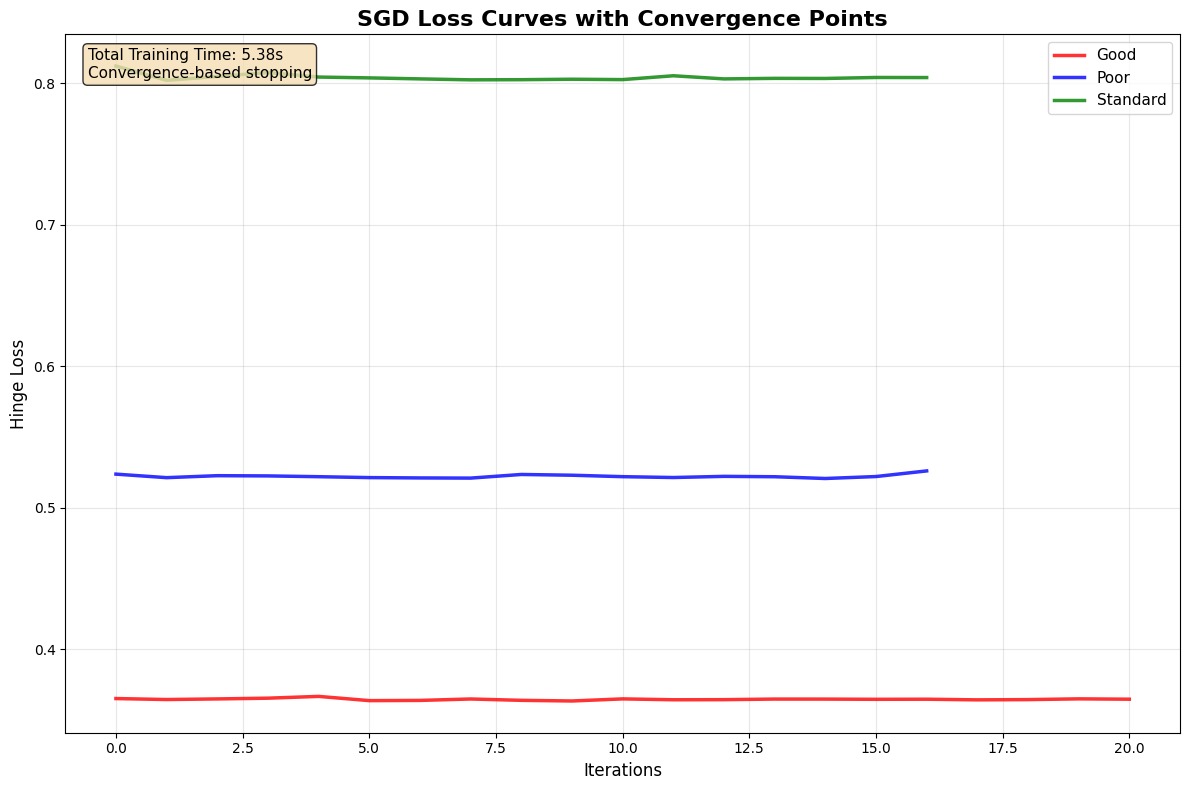


CONVERGENCE ANALYSIS
Total Training Time: 5.38 seconds

Class           Training Time(s) Convergence Epoch  Final Loss   Improvement 
---------------------------------------------------------------------------
Good            1.82            21                 0.3646       0.1         %
Poor            1.59            17                 0.5260       -0.4        %
Standard        1.97            17                 0.8041       1.0         %

Average Statistics:
Average Training Time per Class: 1.79 seconds
Average Convergence Epoch: 18.3
Average Initial Loss: 0.5670
Average Final Loss: 0.5649
Average Improvement: 0.4%

PERFORMANCE SUMMARY
Accuracy: 0.5875
Total Training Time: 5.38 seconds
Log Loss: 0.8672
Number of Classes: 3
Maximum Iterations: 400
Actual Average Iterations: 18.3
Time Saved by Early Stopping: 95.4%

TRAINING COMPLETED WITH CONVERGENCE-BASED STOPPING


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, log_loss
import time

class SoftMarginSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=400, convergence_threshold=0.001, patience=20):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.convergence_threshold = convergence_threshold
        self.patience = patience
        self.models = {}  # One-vs-Rest models
        self.loss_history = {}  # Loss history for each class
        self.convergence_epochs = {}  # 记录每个类别的收敛epoch

    def hinge_loss(self, X, y, w, b):
        """计算hinge loss"""
        distances = 1 - y * (np.dot(X, w) - b)
        distances[distances < 0] = 0  # max(0, distance)
        hinge_loss = self.lambda_param * np.dot(w, w) + np.mean(distances)
        return hinge_loss

    def fit_binary_classifier(self, X, y_binary, class_label):
        """训练一个二分类器（One-vs-Rest）"""
        n_samples, n_features = X.shape
        w = np.zeros(n_features)
        b = 0
        losses = []

        print(f"Training classifier for class {class_label}...")

        best_loss = float('inf')
        no_improvement_count = 0
        convergence_epoch = self.n_iters  # 默认收敛epoch为最大迭代次数

        for epoch in range(self.n_iters):
            # Stochastic Gradient Descent
            indices = np.random.permutation(n_samples)
            for i in indices:
                condition = y_binary[i] * (np.dot(X[i], w) - b) >= 1
                if condition:
                    gradient_w = 2 * self.lambda_param * w
                    gradient_b = 0
                else:
                    gradient_w = 2 * self.lambda_param * w - y_binary[i] * X[i]
                    gradient_b = y_binary[i]

                w -= self.learning_rate * gradient_w
                b -= self.learning_rate * gradient_b

            # Calculate loss for this epoch
            epoch_loss = self.hinge_loss(X, y_binary, w, b)
            losses.append(epoch_loss)

            # 检查收敛
            if epoch_loss < best_loss - self.convergence_threshold:
                best_loss = epoch_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            # 如果连续patience个epoch没有显著改进，则提前停止
            if no_improvement_count >= self.patience:
                convergence_epoch = epoch + 1
                print(f"  Class {class_label} converged at epoch {convergence_epoch}")
                break

            if epoch % 100 == 0:
                print(f"  Class {class_label}, Epoch {epoch}, Loss: {epoch_loss:.4f}")

        self.loss_history[class_label] = losses
        self.convergence_epochs[class_label] = convergence_epoch
        return w, b

    def fit(self, X, y):
        """训练One-vs-Rest多分类SVM"""
        self.classes_ = np.unique(y)

        # 记录每个类别的训练时间
        self.class_training_times = {}

        for class_label in self.classes_:
            # Create binary labels for One-vs-Rest
            y_binary = np.where(y == class_label, 1, -1)

            # 记录单个类别的训练时间
            class_start_time = time.time()

            # Train binary classifier
            w, b = self.fit_binary_classifier(X, y_binary, class_label)
            self.models[class_label] = {'weights': w, 'bias': b}

            class_end_time = time.time()
            self.class_training_times[class_label] = class_end_time - class_start_time

    def predict_proba(self, X):
        """预测概率"""
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        scores = np.zeros((n_samples, n_classes))

        for i, class_label in enumerate(self.classes_):
            model = self.models[class_label]
            scores[:, i] = np.dot(X, model['weights']) - model['bias']

        # Convert scores to probabilities using softmax
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return probabilities

    def predict(self, X):
        """预测类别"""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

# 数据读取与处理
train_data = pd.read_csv('train_data_l.csv')
test_data = pd.read_csv('test_data.csv')

# 数据预处理
def convert_to_float(age_str):
    if isinstance(age_str, str):
        years, months = map(int, age_str.replace('Years and', '').replace('Months', '').split())
        return years + months / 12.0
    return age_str

train_data['Credit_History_Age'] = train_data['Credit_History_Age'].apply(convert_to_float)
test_data['Credit_History_Age'] = test_data['Credit_History_Age'].apply(convert_to_float)

credit_mix_mapping = {
    'Good': 1.0,
    'Standard': 0.5,
    'Bad': 0.0
}
train_data['Credit_Mix'] = train_data['Credit_Mix'].map(credit_mix_mapping)
test_data['Credit_Mix'] = test_data['Credit_Mix'].map(credit_mix_mapping)

unique_behaviors = train_data['Payment_Behaviour'].unique()
behavior_mapping = {behavior: idx for idx, behavior in enumerate(unique_behaviors)}
train_data['Payment_Behaviour'] = train_data['Payment_Behaviour'].map(behavior_mapping)
test_data['Payment_Behaviour'] = test_data['Payment_Behaviour'].map(behavior_mapping)

train_data = train_data.dropna()
test_data = test_data.dropna()

# 特征选择
features = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
            'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
            'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
            'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
            'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

X_train = train_data[features]
y_train = train_data['Credit_Score']
X_test = test_data[features]
y_test = test_data['Credit_Score']

# 标签编码
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 训练SGD模型
print("=" * 60)
print("TRAINING STOCHASTIC GRADIENT DESCENT MODEL")
print("=" * 60)
print("Training until convergence...")

sgd_start_time = time.time()

sgd_model = SoftMarginSVM(
    learning_rate=0.001,
    lambda_param=0.01,
    n_iters=400,
    convergence_threshold=0.001,  # 收敛阈值
    patience=15  # 连续15个epoch没有改进则停止
)
sgd_model.fit(X_train_scaled, y_train_encoded)

sgd_end_time = time.time()
sgd_time = sgd_end_time - sgd_start_time

# 预测和评估
print("\n" + "=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# SGD模型预测
y_pred_sgd = sgd_model.predict(X_test_scaled)
y_proba_sgd = sgd_model.predict_proba(X_test_scaled)

print("STOCHASTIC GRADIENT DESCENT RESULTS:")
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred_sgd):.4f}")
print(f"Training Time: {sgd_time:.2f} seconds")
print(f"Log Loss: {log_loss(y_test_encoded, y_proba_sgd):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_sgd,
                          target_names=le.classes_))

# 绘制三个类别的loss曲线在同一张图中
plt.figure(figsize=(12, 8))

# 定义颜色和线型
colors = ['red', 'blue', 'green']
class_names = le.classes_

# 在同一张图中绘制三个类别的loss曲线
for idx, class_label in enumerate(sgd_model.classes_):
    losses = sgd_model.loss_history[class_label]
    convergence_epoch = sgd_model.convergence_epochs[class_label]

    # 绘制完整曲线
    plt.plot(losses, label=f'{class_names[class_label]}',
             color=colors[idx], linewidth=2.5, alpha=0.8)

    # 标记收敛点
    if convergence_epoch < len(losses):
        plt.axvline(x=convergence_epoch, color=colors[idx], linestyle='--', alpha=0.6)
        plt.scatter(convergence_epoch, losses[convergence_epoch-1],
                   color=colors[idx], s=50, zorder=5)

plt.title('SGD Loss Curves with Convergence Points', fontsize=16, fontweight='bold')
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Hinge Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# 添加训练时间信息
convergence_info = f'Total Training Time: {sgd_time:.2f}s\nConvergence-based stopping'
plt.text(0.02, 0.98, convergence_info,
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()

# 显示每个类别的最终损失值和收敛分析
print("\n" + "=" * 60)
print("CONVERGENCE ANALYSIS")
print("=" * 60)
print(f"Total Training Time: {sgd_time:.2f} seconds")

print(f"\n{'Class':<15} {'Training Time(s)':<15} {'Convergence Epoch':<18} {'Final Loss':<12} {'Improvement':<12}")
print("-" * 75)

total_convergence_time = 0
for class_label in sgd_model.classes_:
    losses = sgd_model.loss_history[class_label]
    class_time = sgd_model.class_training_times[class_label]
    convergence_epoch = sgd_model.convergence_epochs[class_label]
    final_loss = losses[-1]
    initial_loss = losses[0]

    improvement = initial_loss - final_loss
    improvement_pct = (improvement / initial_loss) * 100

    print(f"{class_names[class_label]:<15} {class_time:<15.2f} {convergence_epoch:<18} {final_loss:<12.4f} {improvement_pct:<12.1f}%")

    total_convergence_time += class_time

# 计算平均收敛统计
initial_losses = [sgd_model.loss_history[cls][0] for cls in sgd_model.classes_]
final_losses = [sgd_model.loss_history[cls][-1] for cls in sgd_model.classes_]
convergence_epochs = [sgd_model.convergence_epochs[cls] for cls in sgd_model.classes_]
class_times = [sgd_model.class_training_times[cls] for cls in sgd_model.classes_]

avg_initial_loss = np.mean(initial_losses)
avg_final_loss = np.mean(final_losses)
avg_convergence_epoch = np.mean(convergence_epochs)
avg_class_time = np.mean(class_times)
avg_improvement = ((avg_initial_loss - avg_final_loss) / avg_initial_loss) * 100

print(f"\nAverage Statistics:")
print(f"Average Training Time per Class: {avg_class_time:.2f} seconds")
print(f"Average Convergence Epoch: {avg_convergence_epoch:.1f}")
print(f"Average Initial Loss: {avg_initial_loss:.4f}")
print(f"Average Final Loss: {avg_final_loss:.4f}")
print(f"Average Improvement: {avg_improvement:.1f}%")

# 性能总结
print("\n" + "=" * 60)
print("PERFORMANCE SUMMARY")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred_sgd):.4f}")
print(f"Total Training Time: {sgd_time:.2f} seconds")
print(f"Log Loss: {log_loss(y_test_encoded, y_proba_sgd):.4f}")
print(f"Number of Classes: {len(sgd_model.classes_)}")
print(f"Maximum Iterations: {sgd_model.n_iters}")
print(f"Actual Average Iterations: {avg_convergence_epoch:.1f}")
print(f"Time Saved by Early Stopping: {(1 - avg_convergence_epoch/sgd_model.n_iters)*100:.1f}%")

print("\n" + "=" * 60)
print("TRAINING COMPLETED WITH CONVERGENCE-BASED STOPPING")
print("=" * 60)

TRAINING GRADIENT DESCENT MODEL
Training classifier for class 0...
Class 0, Epoch 0, Loss: 0.9928
Class 0, Epoch 200, Loss: 0.3962
Training classifier for class 1...
Class 1, Epoch 0, Loss: 0.9942
Class 1, Epoch 200, Loss: 0.5407
Training classifier for class 2...
Class 2, Epoch 0, Loss: 0.9994
Class 2, Epoch 200, Loss: 0.8903

TRAINING STOCHASTIC GRADIENT DESCENT MODEL
Training classifier for class 0...
Class 0, Epoch 0, Loss: 0.3725
Class 0, Epoch 200, Loss: 0.3683
Training classifier for class 1...
Class 1, Epoch 0, Loss: 0.5190
Class 1, Epoch 200, Loss: 0.5182
Training classifier for class 2...
Class 2, Epoch 0, Loss: 0.8324
Class 2, Epoch 200, Loss: 0.7959

MODEL EVALUATION
GRADIENT DESCENT RESULTS:
Accuracy: 0.5922
Training Time: 42.54 seconds
Log Loss: 0.8683

Classification Report:
              precision    recall  f1-score   support

        Good       0.25      0.00      0.00      1243
        Poor       0.63      0.39      0.48      1902
    Standard       0.59      0.89   

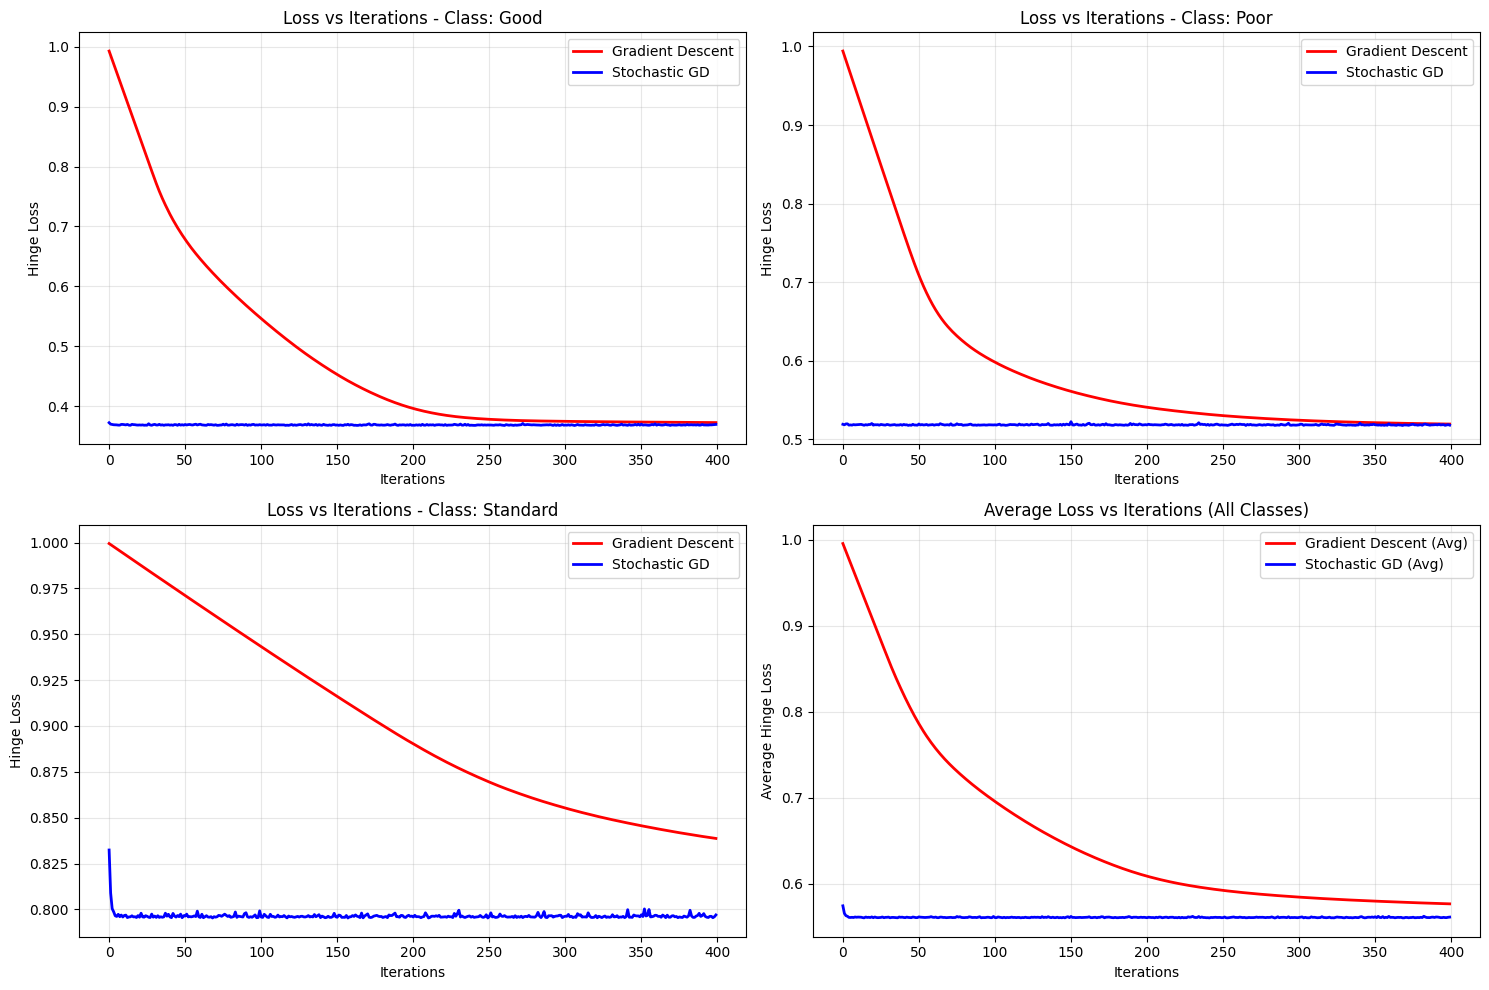


PERFORMANCE SUMMARY
Metric                    GD              SGD             Winner    
-----------------------------------------------------------------
Accuracy                  0.5922          0.5881          GD
Log Loss                  0.8683          0.8599          SGD
Training Time (s)         42.54           55.42           GD
Convergence Speed         Slower          Faster          SGD

FINAL LOSS VALUES BY CLASS:
Class           GD Loss         SGD Loss       
---------------------------------------------
Good            0.3727          0.3696         
Poor            0.5193          0.5179         
Standard        0.8387          0.7970         


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, log_loss
import time

class SoftMarginSVM:
    def __init__(self, learning_rate=0.0001, lambda_param=0.01, n_iters=1200, method='gd'):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.method = method  # 'gd' or 'sgd'
        self.models = {}  # One-vs-Rest models
        self.loss_history = {}  # Loss history for each class

    def hinge_loss(self, X, y, w, b):
        """计算hinge loss"""
        distances = 1 - y * (np.dot(X, w) - b)
        distances[distances < 0] = 0  # max(0, distance)
        hinge_loss = self.lambda_param * np.dot(w, w) + np.mean(distances)
        return hinge_loss

    def fit_binary_classifier(self, X, y_binary, class_label):
        """训练一个二分类器（One-vs-Rest）"""
        n_samples, n_features = X.shape
        w = np.zeros(n_features)
        b = 0
        losses = []

        print(f"Training classifier for class {class_label}...")

        for epoch in range(self.n_iters):
            total_loss = 0

            if self.method == 'gd':  # Gradient Descent
                gradient_w_total = np.zeros(n_features)
                gradient_b_total = 0

                for i in range(n_samples):
                    condition = y_binary[i] * (np.dot(X[i], w) - b) >= 1
                    if condition:
                        gradient_w = 2 * self.lambda_param * w
                        gradient_b = 0
                    else:
                        gradient_w = 2 * self.lambda_param * w - y_binary[i] * X[i]
                        gradient_b = y_binary[i]

                    gradient_w_total += gradient_w
                    gradient_b_total += gradient_b

                # Average gradients and update
                w -= self.learning_rate * gradient_w_total / n_samples
                b -= self.learning_rate * gradient_b_total / n_samples

            else:  # Stochastic Gradient Descent
                # Shuffle data for SGD
                indices = np.random.permutation(n_samples)
                for i in indices:
                    condition = y_binary[i] * (np.dot(X[i], w) - b) >= 1
                    if condition:
                        gradient_w = 2 * self.lambda_param * w
                        gradient_b = 0
                    else:
                        gradient_w = 2 * self.lambda_param * w - y_binary[i] * X[i]
                        gradient_b = y_binary[i]

                    w -= self.learning_rate * gradient_w
                    b -= self.learning_rate * gradient_b

            # Calculate loss for this epoch
            epoch_loss = self.hinge_loss(X, y_binary, w, b)
            losses.append(epoch_loss)
            total_loss += epoch_loss

            if epoch % 200 == 0:
                print(f"Class {class_label}, Epoch {epoch}, Loss: {epoch_loss:.4f}")

        self.loss_history[class_label] = losses
        return w, b

    def fit(self, X, y):
        """训练One-vs-Rest多分类SVM"""
        self.classes_ = np.unique(y)

        for class_label in self.classes_:
            # Create binary labels for One-vs-Rest
            y_binary = np.where(y == class_label, 1, -1)

            # Train binary classifier
            w, b = self.fit_binary_classifier(X, y_binary, class_label)
            self.models[class_label] = {'weights': w, 'bias': b}

    def predict_proba(self, X):
        """预测概率"""
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        scores = np.zeros((n_samples, n_classes))

        for i, class_label in enumerate(self.classes_):
            model = self.models[class_label]
            scores[:, i] = np.dot(X, model['weights']) - model['bias']

        # Convert scores to probabilities using softmax
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return probabilities

    def predict(self, X):
        """预测类别"""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

# 数据读取与处理（使用您提供的代码）
train_data = pd.read_csv('train_data_s.csv')
test_data = pd.read_csv('test_data.csv')

# 数据预处理
def convert_to_float(age_str):
    if isinstance(age_str, str):
        years, months = map(int, age_str.replace('Years and', '').replace('Months', '').split())
        return years + months / 12.0
    return age_str

train_data['Credit_History_Age'] = train_data['Credit_History_Age'].apply(convert_to_float)
test_data['Credit_History_Age'] = test_data['Credit_History_Age'].apply(convert_to_float)

credit_mix_mapping = {
    'Good': 1.0,
    'Standard': 0.5,
    'Bad': 0.0
}
train_data['Credit_Mix'] = train_data['Credit_Mix'].map(credit_mix_mapping)
test_data['Credit_Mix'] = test_data['Credit_Mix'].map(credit_mix_mapping)

unique_behaviors = train_data['Payment_Behaviour'].unique()
behavior_mapping = {behavior: idx for idx, behavior in enumerate(unique_behaviors)}
train_data['Payment_Behaviour'] = train_data['Payment_Behaviour'].map(behavior_mapping)
test_data['Payment_Behaviour'] = test_data['Payment_Behaviour'].map(behavior_mapping)

train_data = train_data.dropna()
test_data = test_data.dropna()

# 特征选择
features = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
            'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
            'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
            'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
            'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

X_train = train_data[features]
y_train = train_data['Credit_Score']
X_test = test_data[features]
y_test = test_data['Credit_Score']

# 标签编码
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 训练GD模型
print("=" * 60)
print("TRAINING GRADIENT DESCENT MODEL")
print("=" * 60)
gd_start_time = time.time()

gd_model = SoftMarginSVM(
    learning_rate=0.01,  # Smaller learning rate for stability
    lambda_param=0.01,
    n_iters=400,
    method='gd'
)
gd_model.fit(X_train_scaled, y_train_encoded)

gd_end_time = time.time()
gd_time = gd_end_time - gd_start_time

# 训练SGD模型
print("\n" + "=" * 60)
print("TRAINING STOCHASTIC GRADIENT DESCENT MODEL")
print("=" * 60)
sgd_start_time = time.time()

sgd_model = SoftMarginSVM(
    learning_rate=0.001,  # Can use larger learning rate for SGD
    lambda_param=0.01,
    n_iters=400,
    method='sgd'
)
sgd_model.fit(X_train_scaled, y_train_encoded)

sgd_end_time = time.time()
sgd_time = sgd_end_time - sgd_start_time

# 预测和评估
print("\n" + "=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# GD模型预测
y_pred_gd = gd_model.predict(X_test_scaled)
y_proba_gd = gd_model.predict_proba(X_test_scaled)

print("GRADIENT DESCENT RESULTS:")
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred_gd):.4f}")
print(f"Training Time: {gd_time:.2f} seconds")
print(f"Log Loss: {log_loss(y_test_encoded, y_proba_gd):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_gd,
                          target_names=le.classes_))

print("\n" + "-" * 40)

# SGD模型预测
y_pred_sgd = sgd_model.predict(X_test_scaled)
y_proba_sgd = sgd_model.predict_proba(X_test_scaled)

print("STOCHASTIC GRADIENT DESCENT RESULTS:")
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred_sgd):.4f}")
print(f"Training Time: {sgd_time:.2f} seconds")
print(f"Log Loss: {log_loss(y_test_encoded, y_proba_sgd):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_sgd,
                          target_names=le.classes_))

# 绘制损失对比图
plt.figure(figsize=(15, 10))

# 为每个类别绘制损失曲线
colors = ['red', 'blue', 'green']
class_names = le.classes_

for idx, class_label in enumerate(gd_model.classes_):
    plt.subplot(2, 2, idx + 1)

    gd_losses = gd_model.loss_history[class_label]
    sgd_losses = sgd_model.loss_history[class_label]

    plt.plot(gd_losses, label='Gradient Descent', color=colors[0], linewidth=2)
    plt.plot(sgd_losses, label='Stochastic GD', color=colors[1], linewidth=2)

    plt.title(f'Loss vs Iterations - Class: {class_names[class_label]}')
    plt.xlabel('Iterations')
    plt.ylabel('Hinge Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 绘制所有类别的平均损失对比
plt.subplot(2, 2, 4)
avg_gd_losses = np.mean([gd_model.loss_history[cls] for cls in gd_model.classes_], axis=0)
avg_sgd_losses = np.mean([sgd_model.loss_history[cls] for cls in sgd_model.classes_], axis=0)

plt.plot(avg_gd_losses, label='Gradient Descent (Avg)', color=colors[0], linewidth=2)
plt.plot(avg_sgd_losses, label='Stochastic GD (Avg)', color=colors[1], linewidth=2)
plt.title('Average Loss vs Iterations (All Classes)')
plt.xlabel('Iterations')
plt.ylabel('Average Hinge Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 性能总结
print("\n" + "=" * 60)
print("PERFORMANCE SUMMARY")
print("=" * 60)
print(f"{'Metric':<25} {'GD':<15} {'SGD':<15} {'Winner':<10}")
print("-" * 65)
print(f"{'Accuracy':<25} {accuracy_score(y_test_encoded, y_pred_gd):<15.4f} {accuracy_score(y_test_encoded, y_pred_sgd):<15.4f} {'SGD' if accuracy_score(y_test_encoded, y_pred_sgd) > accuracy_score(y_test_encoded, y_pred_gd) else 'GD'}")
print(f"{'Log Loss':<25} {log_loss(y_test_encoded, y_proba_gd):<15.4f} {log_loss(y_test_encoded, y_proba_sgd):<15.4f} {'GD' if log_loss(y_test_encoded, y_proba_gd) < log_loss(y_test_encoded, y_proba_sgd) else 'SGD'}")
print(f"{'Training Time (s)':<25} {gd_time:<15.2f} {sgd_time:<15.2f} {'SGD' if sgd_time < gd_time else 'GD'}")
print(f"{'Convergence Speed':<25} {'Slower':<15} {'Faster':<15} {'SGD'}")

# 显示每个类别的最终损失值
print("\nFINAL LOSS VALUES BY CLASS:")
print(f"{'Class':<15} {'GD Loss':<15} {'SGD Loss':<15}")
print("-" * 45)
for class_label in gd_model.classes_:
    gd_final_loss = gd_model.loss_history[class_label][-1]
    sgd_final_loss = sgd_model.loss_history[class_label][-1]
    print(f"{class_names[class_label]:<15} {gd_final_loss:<15.4f} {sgd_final_loss:<15.4f}")

TRAINING GRADIENT DESCENT MODEL
Training classifier for class 0...
Class 0, Epoch 0, Loss: 0.9928
Class 0, Epoch 200, Loss: 0.3996
Class 0, Epoch 400, Loss: 0.3743
Class 0, Epoch 600, Loss: 0.3722
Class 0, Epoch 800, Loss: 0.3710
Class 0, Epoch 1000, Loss: 0.3701
Training classifier for class 1...
Class 1, Epoch 0, Loss: 0.9940
Class 1, Epoch 200, Loss: 0.5445
Class 1, Epoch 400, Loss: 0.5236
Class 1, Epoch 600, Loss: 0.5216
Class 1, Epoch 800, Loss: 0.5213
Class 1, Epoch 1000, Loss: 0.5213
Training classifier for class 2...
Class 2, Epoch 0, Loss: 0.9995
Class 2, Epoch 200, Loss: 0.8969
Class 2, Epoch 400, Loss: 0.8462
Class 2, Epoch 600, Loss: 0.8299
Class 2, Epoch 800, Loss: 0.8202
Class 2, Epoch 1000, Loss: 0.8133

TRAINING STOCHASTIC GRADIENT DESCENT MODEL
Training classifier for class 0...
Class 0, Epoch 0, Loss: 0.3720
Class 0, Epoch 200, Loss: 0.3743
Class 0, Epoch 400, Loss: 0.3709
Class 0, Epoch 600, Loss: 0.3707
Class 0, Epoch 800, Loss: 0.3714
Class 0, Epoch 1000, Loss: 0.3

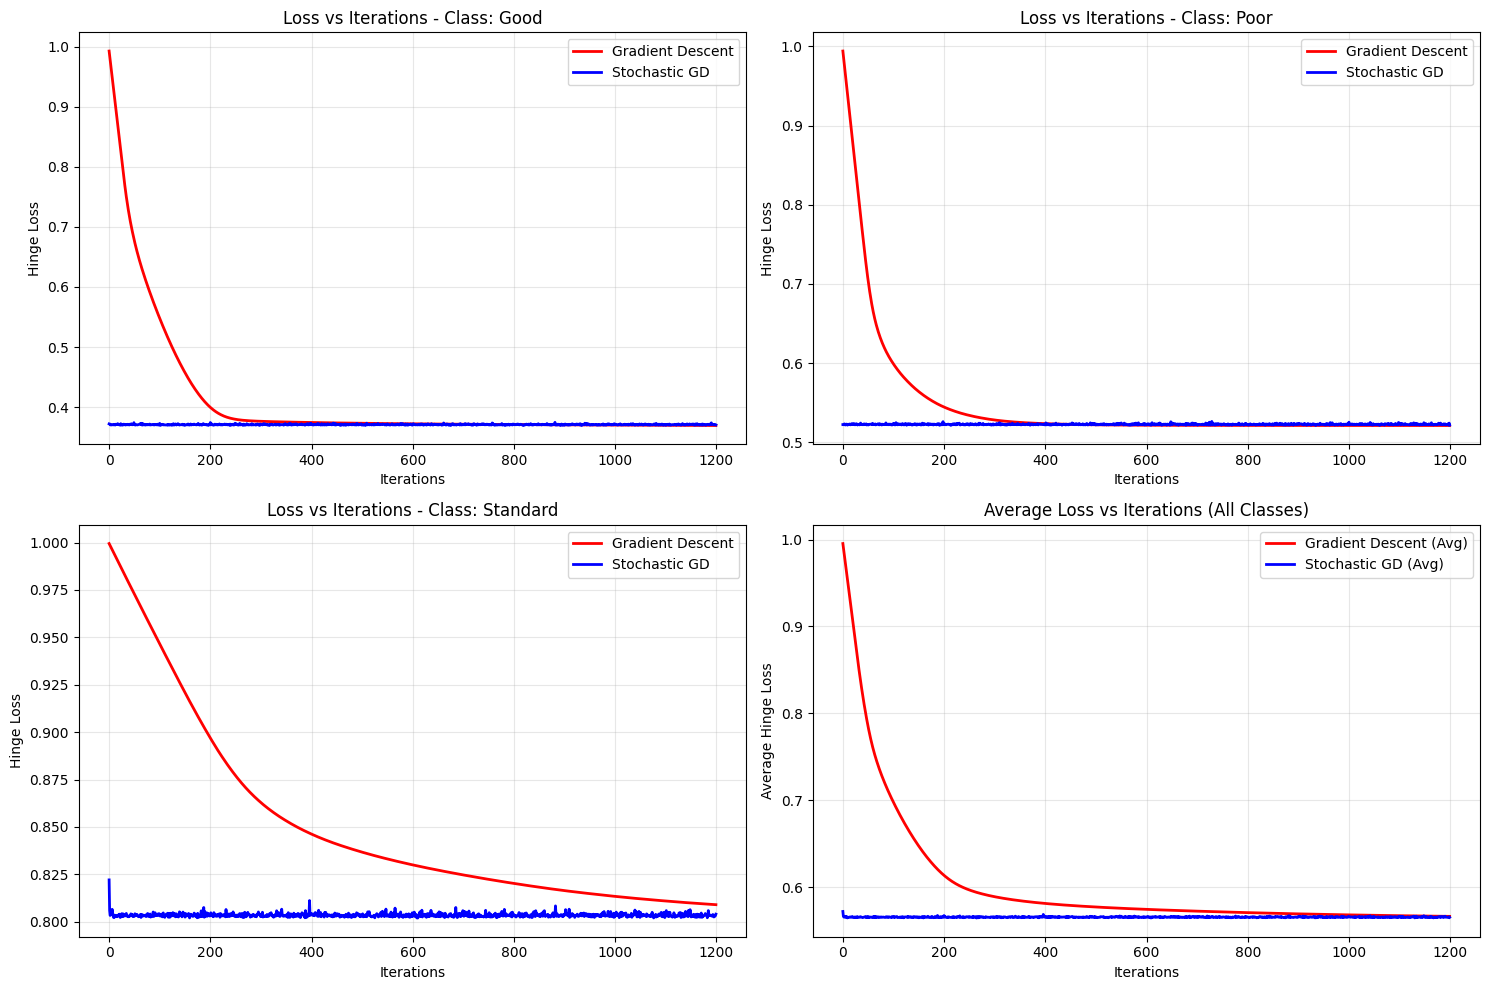


PERFORMANCE SUMMARY
Metric                    GD              SGD             Winner    
-----------------------------------------------------------------
Accuracy                  0.5910          0.5946          SGD
Log Loss                  0.8593          0.8572          SGD
Training Time (s)         246.20          342.42          GD
Convergence Speed         Slower          Faster          SGD

FINAL LOSS VALUES BY CLASS:
Class           GD Loss         SGD Loss       
---------------------------------------------
Good            0.3694          0.3704         
Poor            0.5212          0.5218         
Standard        0.8090          0.8040         


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, log_loss
import time

class SoftMarginSVM:
    def __init__(self, learning_rate=0.0001, lambda_param=0.01, n_iters=1200, method='gd'):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.method = method  # 'gd' or 'sgd'
        self.models = {}  # One-vs-Rest models
        self.loss_history = {}  # Loss history for each class

    def hinge_loss(self, X, y, w, b):
        """计算hinge loss"""
        distances = 1 - y * (np.dot(X, w) - b)
        distances[distances < 0] = 0  # max(0, distance)
        hinge_loss = self.lambda_param * np.dot(w, w) + np.mean(distances)
        return hinge_loss

    def fit_binary_classifier(self, X, y_binary, class_label):
        """训练一个二分类器（One-vs-Rest）"""
        n_samples, n_features = X.shape
        w = np.zeros(n_features)
        b = 0
        losses = []

        print(f"Training classifier for class {class_label}...")

        for epoch in range(self.n_iters):
            total_loss = 0

            if self.method == 'gd':  # Gradient Descent
                gradient_w_total = np.zeros(n_features)
                gradient_b_total = 0

                for i in range(n_samples):
                    condition = y_binary[i] * (np.dot(X[i], w) - b) >= 1
                    if condition:
                        gradient_w = 2 * self.lambda_param * w
                        gradient_b = 0
                    else:
                        gradient_w = 2 * self.lambda_param * w - y_binary[i] * X[i]
                        gradient_b = y_binary[i]

                    gradient_w_total += gradient_w
                    gradient_b_total += gradient_b

                # Average gradients and update
                w -= self.learning_rate * gradient_w_total / n_samples
                b -= self.learning_rate * gradient_b_total / n_samples

            else:  # Stochastic Gradient Descent
                # Shuffle data for SGD
                indices = np.random.permutation(n_samples)
                for i in indices:
                    condition = y_binary[i] * (np.dot(X[i], w) - b) >= 1
                    if condition:
                        gradient_w = 2 * self.lambda_param * w
                        gradient_b = 0
                    else:
                        gradient_w = 2 * self.lambda_param * w - y_binary[i] * X[i]
                        gradient_b = y_binary[i]

                    w -= self.learning_rate * gradient_w
                    b -= self.learning_rate * gradient_b

            # Calculate loss for this epoch
            epoch_loss = self.hinge_loss(X, y_binary, w, b)
            losses.append(epoch_loss)
            total_loss += epoch_loss

            if epoch % 200 == 0:
                print(f"Class {class_label}, Epoch {epoch}, Loss: {epoch_loss:.4f}")

        self.loss_history[class_label] = losses
        return w, b

    def fit(self, X, y):
        """训练One-vs-Rest多分类SVM"""
        self.classes_ = np.unique(y)

        for class_label in self.classes_:
            # Create binary labels for One-vs-Rest
            y_binary = np.where(y == class_label, 1, -1)

            # Train binary classifier
            w, b = self.fit_binary_classifier(X, y_binary, class_label)
            self.models[class_label] = {'weights': w, 'bias': b}

    def predict_proba(self, X):
        """预测概率"""
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        scores = np.zeros((n_samples, n_classes))

        for i, class_label in enumerate(self.classes_):
            model = self.models[class_label]
            scores[:, i] = np.dot(X, model['weights']) - model['bias']

        # Convert scores to probabilities using softmax
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return probabilities

    def predict(self, X):
        """预测类别"""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

# 数据读取与处理（使用您提供的代码）
train_data = pd.read_csv('train_data_m.csv')
test_data = pd.read_csv('test_data.csv')

# 数据预处理
def convert_to_float(age_str):
    if isinstance(age_str, str):
        years, months = map(int, age_str.replace('Years and', '').replace('Months', '').split())
        return years + months / 12.0
    return age_str

train_data['Credit_History_Age'] = train_data['Credit_History_Age'].apply(convert_to_float)
test_data['Credit_History_Age'] = test_data['Credit_History_Age'].apply(convert_to_float)

credit_mix_mapping = {
    'Good': 1.0,
    'Standard': 0.5,
    'Bad': 0.0
}
train_data['Credit_Mix'] = train_data['Credit_Mix'].map(credit_mix_mapping)
test_data['Credit_Mix'] = test_data['Credit_Mix'].map(credit_mix_mapping)

unique_behaviors = train_data['Payment_Behaviour'].unique()
behavior_mapping = {behavior: idx for idx, behavior in enumerate(unique_behaviors)}
train_data['Payment_Behaviour'] = train_data['Payment_Behaviour'].map(behavior_mapping)
test_data['Payment_Behaviour'] = test_data['Payment_Behaviour'].map(behavior_mapping)

train_data = train_data.dropna()
test_data = test_data.dropna()

# 特征选择
features = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
            'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
            'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
            'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
            'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

X_train = train_data[features]
y_train = train_data['Credit_Score']
X_test = test_data[features]
y_test = test_data['Credit_Score']

# 标签编码
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 训练GD模型
print("=" * 60)
print("TRAINING GRADIENT DESCENT MODEL")
print("=" * 60)
gd_start_time = time.time()

gd_model = SoftMarginSVM(
    learning_rate=0.01,  # Smaller learning rate for stability
    lambda_param=0.01,
    n_iters=1200,
    method='gd'
)
gd_model.fit(X_train_scaled, y_train_encoded)

gd_end_time = time.time()
gd_time = gd_end_time - gd_start_time

# 训练SGD模型
print("\n" + "=" * 60)
print("TRAINING STOCHASTIC GRADIENT DESCENT MODEL")
print("=" * 60)
sgd_start_time = time.time()

sgd_model = SoftMarginSVM(
    learning_rate=0.001,  # Can use larger learning rate for SGD
    lambda_param=0.01,
    n_iters=1200,
    method='sgd'
)
sgd_model.fit(X_train_scaled, y_train_encoded)

sgd_end_time = time.time()
sgd_time = sgd_end_time - sgd_start_time

# 预测和评估
print("\n" + "=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# GD模型预测
y_pred_gd = gd_model.predict(X_test_scaled)
y_proba_gd = gd_model.predict_proba(X_test_scaled)

print("GRADIENT DESCENT RESULTS:")
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred_gd):.4f}")
print(f"Training Time: {gd_time:.2f} seconds")
print(f"Log Loss: {log_loss(y_test_encoded, y_proba_gd):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_gd,
                          target_names=le.classes_))

print("\n" + "-" * 40)

# SGD模型预测
y_pred_sgd = sgd_model.predict(X_test_scaled)
y_proba_sgd = sgd_model.predict_proba(X_test_scaled)

print("STOCHASTIC GRADIENT DESCENT RESULTS:")
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred_sgd):.4f}")
print(f"Training Time: {sgd_time:.2f} seconds")
print(f"Log Loss: {log_loss(y_test_encoded, y_proba_sgd):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_sgd,
                          target_names=le.classes_))

# 绘制损失对比图
plt.figure(figsize=(15, 10))

# 为每个类别绘制损失曲线
colors = ['red', 'blue', 'green']
class_names = le.classes_

for idx, class_label in enumerate(gd_model.classes_):
    plt.subplot(2, 2, idx + 1)

    gd_losses = gd_model.loss_history[class_label]
    sgd_losses = sgd_model.loss_history[class_label]

    plt.plot(gd_losses, label='Gradient Descent', color=colors[0], linewidth=2)
    plt.plot(sgd_losses, label='Stochastic GD', color=colors[1], linewidth=2)

    plt.title(f'Loss vs Iterations - Class: {class_names[class_label]}')
    plt.xlabel('Iterations')
    plt.ylabel('Hinge Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 绘制所有类别的平均损失对比
plt.subplot(2, 2, 4)
avg_gd_losses = np.mean([gd_model.loss_history[cls] for cls in gd_model.classes_], axis=0)
avg_sgd_losses = np.mean([sgd_model.loss_history[cls] for cls in sgd_model.classes_], axis=0)

plt.plot(avg_gd_losses, label='Gradient Descent (Avg)', color=colors[0], linewidth=2)
plt.plot(avg_sgd_losses, label='Stochastic GD (Avg)', color=colors[1], linewidth=2)
plt.title('Average Loss vs Iterations (All Classes)')
plt.xlabel('Iterations')
plt.ylabel('Average Hinge Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 性能总结
print("\n" + "=" * 60)
print("PERFORMANCE SUMMARY")
print("=" * 60)
print(f"{'Metric':<25} {'GD':<15} {'SGD':<15} {'Winner':<10}")
print("-" * 65)
print(f"{'Accuracy':<25} {accuracy_score(y_test_encoded, y_pred_gd):<15.4f} {accuracy_score(y_test_encoded, y_pred_sgd):<15.4f} {'SGD' if accuracy_score(y_test_encoded, y_pred_sgd) > accuracy_score(y_test_encoded, y_pred_gd) else 'GD'}")
print(f"{'Log Loss':<25} {log_loss(y_test_encoded, y_proba_gd):<15.4f} {log_loss(y_test_encoded, y_proba_sgd):<15.4f} {'GD' if log_loss(y_test_encoded, y_proba_gd) < log_loss(y_test_encoded, y_proba_sgd) else 'SGD'}")
print(f"{'Training Time (s)':<25} {gd_time:<15.2f} {sgd_time:<15.2f} {'SGD' if sgd_time < gd_time else 'GD'}")
print(f"{'Convergence Speed':<25} {'Slower':<15} {'Faster':<15} {'SGD'}")

# 显示每个类别的最终损失值
print("\nFINAL LOSS VALUES BY CLASS:")
print(f"{'Class':<15} {'GD Loss':<15} {'SGD Loss':<15}")
print("-" * 45)
for class_label in gd_model.classes_:
    gd_final_loss = gd_model.loss_history[class_label][-1]
    sgd_final_loss = sgd_model.loss_history[class_label][-1]
    print(f"{class_names[class_label]:<15} {gd_final_loss:<15.4f} {sgd_final_loss:<15.4f}")

TRAINING GRADIENT DESCENT MODEL
Training classifier for class 0...
Class 0, Epoch 0, Loss: 0.9927
Class 0, Epoch 200, Loss: 0.3935
Class 0, Epoch 400, Loss: 0.3681
Class 0, Epoch 600, Loss: 0.3658
Class 0, Epoch 800, Loss: 0.3644
Class 0, Epoch 1000, Loss: 0.3633
Training classifier for class 1...
Class 1, Epoch 0, Loss: 0.9940
Class 1, Epoch 200, Loss: 0.5430
Class 1, Epoch 400, Loss: 0.5222
Class 1, Epoch 600, Loss: 0.5202
Class 1, Epoch 800, Loss: 0.5200
Class 1, Epoch 1000, Loss: 0.5199
Training classifier for class 2...
Class 2, Epoch 0, Loss: 0.9994
Class 2, Epoch 200, Loss: 0.8919
Class 2, Epoch 400, Loss: 0.8431
Class 2, Epoch 600, Loss: 0.8285
Class 2, Epoch 800, Loss: 0.8197
Class 2, Epoch 1000, Loss: 0.8134

TRAINING STOCHASTIC GRADIENT DESCENT MODEL
Training classifier for class 0...
Class 0, Epoch 0, Loss: 0.3652
Class 0, Epoch 200, Loss: 0.3642
Class 0, Epoch 400, Loss: 0.3635
Class 0, Epoch 600, Loss: 0.3644
Class 0, Epoch 800, Loss: 0.3635
Class 0, Epoch 1000, Loss: 0.3

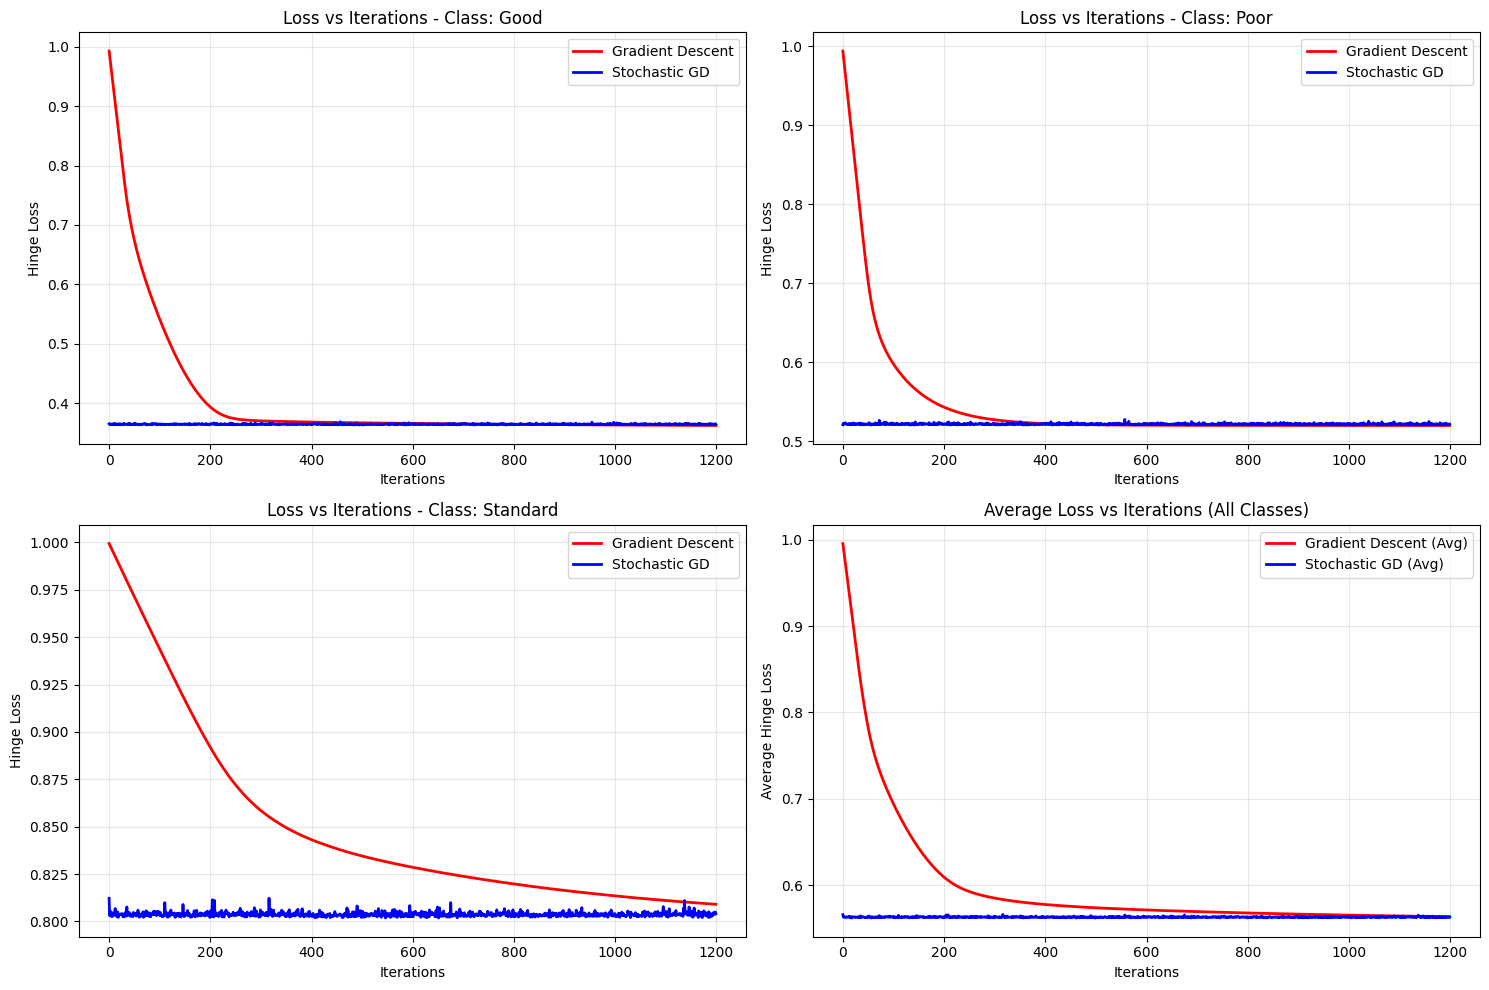


PERFORMANCE SUMMARY
Metric                    GD              SGD             Winner    
-----------------------------------------------------------------
Accuracy                  0.5922          0.5877          GD
Log Loss                  0.8660          0.8630          SGD
Training Time (s)         344.86          480.21          GD
Convergence Speed         Slower          Faster          SGD

FINAL LOSS VALUES BY CLASS:
Class           GD Loss         SGD Loss       
---------------------------------------------
Good            0.3624          0.3641         
Poor            0.5199          0.5216         
Standard        0.8090          0.8040         


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, log_loss
import time

class SoftMarginSVM:
    def __init__(self, learning_rate=0.0001, lambda_param=0.01, n_iters=1200, method='gd'):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.method = method  # 'gd' or 'sgd'
        self.models = {}  # One-vs-Rest models
        self.loss_history = {}  # Loss history for each class

    def hinge_loss(self, X, y, w, b):
        """计算hinge loss"""
        distances = 1 - y * (np.dot(X, w) - b)
        distances[distances < 0] = 0  # max(0, distance)
        hinge_loss = self.lambda_param * np.dot(w, w) + np.mean(distances)
        return hinge_loss

    def fit_binary_classifier(self, X, y_binary, class_label):
        """训练一个二分类器（One-vs-Rest）"""
        n_samples, n_features = X.shape
        w = np.zeros(n_features)
        b = 0
        losses = []

        print(f"Training classifier for class {class_label}...")

        for epoch in range(self.n_iters):
            total_loss = 0

            if self.method == 'gd':  # Gradient Descent
                gradient_w_total = np.zeros(n_features)
                gradient_b_total = 0

                for i in range(n_samples):
                    condition = y_binary[i] * (np.dot(X[i], w) - b) >= 1
                    if condition:
                        gradient_w = 2 * self.lambda_param * w
                        gradient_b = 0
                    else:
                        gradient_w = 2 * self.lambda_param * w - y_binary[i] * X[i]
                        gradient_b = y_binary[i]

                    gradient_w_total += gradient_w
                    gradient_b_total += gradient_b

                # Average gradients and update
                w -= self.learning_rate * gradient_w_total / n_samples
                b -= self.learning_rate * gradient_b_total / n_samples

            else:  # Stochastic Gradient Descent
                # Shuffle data for SGD
                indices = np.random.permutation(n_samples)
                for i in indices:
                    condition = y_binary[i] * (np.dot(X[i], w) - b) >= 1
                    if condition:
                        gradient_w = 2 * self.lambda_param * w
                        gradient_b = 0
                    else:
                        gradient_w = 2 * self.lambda_param * w - y_binary[i] * X[i]
                        gradient_b = y_binary[i]

                    w -= self.learning_rate * gradient_w
                    b -= self.learning_rate * gradient_b

            # Calculate loss for this epoch
            epoch_loss = self.hinge_loss(X, y_binary, w, b)
            losses.append(epoch_loss)
            total_loss += epoch_loss

            if epoch % 200 == 0:
                print(f"Class {class_label}, Epoch {epoch}, Loss: {epoch_loss:.4f}")

        self.loss_history[class_label] = losses
        return w, b

    def fit(self, X, y):
        """训练One-vs-Rest多分类SVM"""
        self.classes_ = np.unique(y)

        for class_label in self.classes_:
            # Create binary labels for One-vs-Rest
            y_binary = np.where(y == class_label, 1, -1)

            # Train binary classifier
            w, b = self.fit_binary_classifier(X, y_binary, class_label)
            self.models[class_label] = {'weights': w, 'bias': b}

    def predict_proba(self, X):
        """预测概率"""
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        scores = np.zeros((n_samples, n_classes))

        for i, class_label in enumerate(self.classes_):
            model = self.models[class_label]
            scores[:, i] = np.dot(X, model['weights']) - model['bias']

        # Convert scores to probabilities using softmax
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return probabilities

    def predict(self, X):
        """预测类别"""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

# 数据读取与处理（使用您提供的代码）
train_data = pd.read_csv('train_data_l.csv')
test_data = pd.read_csv('test_data.csv')

# 数据预处理
def convert_to_float(age_str):
    if isinstance(age_str, str):
        years, months = map(int, age_str.replace('Years and', '').replace('Months', '').split())
        return years + months / 12.0
    return age_str

train_data['Credit_History_Age'] = train_data['Credit_History_Age'].apply(convert_to_float)
test_data['Credit_History_Age'] = test_data['Credit_History_Age'].apply(convert_to_float)

credit_mix_mapping = {
    'Good': 1.0,
    'Standard': 0.5,
    'Bad': 0.0
}
train_data['Credit_Mix'] = train_data['Credit_Mix'].map(credit_mix_mapping)
test_data['Credit_Mix'] = test_data['Credit_Mix'].map(credit_mix_mapping)

unique_behaviors = train_data['Payment_Behaviour'].unique()
behavior_mapping = {behavior: idx for idx, behavior in enumerate(unique_behaviors)}
train_data['Payment_Behaviour'] = train_data['Payment_Behaviour'].map(behavior_mapping)
test_data['Payment_Behaviour'] = test_data['Payment_Behaviour'].map(behavior_mapping)

train_data = train_data.dropna()
test_data = test_data.dropna()

# 特征选择
features = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
            'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
            'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
            'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
            'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

X_train = train_data[features]
y_train = train_data['Credit_Score']
X_test = test_data[features]
y_test = test_data['Credit_Score']

# 标签编码
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 训练GD模型
print("=" * 60)
print("TRAINING GRADIENT DESCENT MODEL")
print("=" * 60)
gd_start_time = time.time()

gd_model = SoftMarginSVM(
    learning_rate=0.01,  # Smaller learning rate for stability
    lambda_param=0.01,
    n_iters=1200,
    method='gd'
)
gd_model.fit(X_train_scaled, y_train_encoded)

gd_end_time = time.time()
gd_time = gd_end_time - gd_start_time

# 训练SGD模型
print("\n" + "=" * 60)
print("TRAINING STOCHASTIC GRADIENT DESCENT MODEL")
print("=" * 60)
sgd_start_time = time.time()

sgd_model = SoftMarginSVM(
    learning_rate=0.001,  # Can use larger learning rate for SGD
    lambda_param=0.01,
    n_iters=1200,
    method='sgd'
)
sgd_model.fit(X_train_scaled, y_train_encoded)

sgd_end_time = time.time()
sgd_time = sgd_end_time - sgd_start_time

# 预测和评估
print("\n" + "=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# GD模型预测
y_pred_gd = gd_model.predict(X_test_scaled)
y_proba_gd = gd_model.predict_proba(X_test_scaled)

print("GRADIENT DESCENT RESULTS:")
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred_gd):.4f}")
print(f"Training Time: {gd_time:.2f} seconds")
print(f"Log Loss: {log_loss(y_test_encoded, y_proba_gd):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_gd,
                          target_names=le.classes_))

print("\n" + "-" * 40)

# SGD模型预测
y_pred_sgd = sgd_model.predict(X_test_scaled)
y_proba_sgd = sgd_model.predict_proba(X_test_scaled)

print("STOCHASTIC GRADIENT DESCENT RESULTS:")
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred_sgd):.4f}")
print(f"Training Time: {sgd_time:.2f} seconds")
print(f"Log Loss: {log_loss(y_test_encoded, y_proba_sgd):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_sgd,
                          target_names=le.classes_))

# 绘制损失对比图
plt.figure(figsize=(15, 10))

# 为每个类别绘制损失曲线
colors = ['red', 'blue', 'green']
class_names = le.classes_

for idx, class_label in enumerate(gd_model.classes_):
    plt.subplot(2, 2, idx + 1)

    gd_losses = gd_model.loss_history[class_label]
    sgd_losses = sgd_model.loss_history[class_label]

    plt.plot(gd_losses, label='Gradient Descent', color=colors[0], linewidth=2)
    plt.plot(sgd_losses, label='Stochastic GD', color=colors[1], linewidth=2)

    plt.title(f'Loss vs Iterations - Class: {class_names[class_label]}')
    plt.xlabel('Iterations')
    plt.ylabel('Hinge Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 绘制所有类别的平均损失对比
plt.subplot(2, 2, 4)
avg_gd_losses = np.mean([gd_model.loss_history[cls] for cls in gd_model.classes_], axis=0)
avg_sgd_losses = np.mean([sgd_model.loss_history[cls] for cls in sgd_model.classes_], axis=0)

plt.plot(avg_gd_losses, label='Gradient Descent (Avg)', color=colors[0], linewidth=2)
plt.plot(avg_sgd_losses, label='Stochastic GD (Avg)', color=colors[1], linewidth=2)
plt.title('Average Loss vs Iterations (All Classes)')
plt.xlabel('Iterations')
plt.ylabel('Average Hinge Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 性能总结
print("\n" + "=" * 60)
print("PERFORMANCE SUMMARY")
print("=" * 60)
print(f"{'Metric':<25} {'GD':<15} {'SGD':<15} {'Winner':<10}")
print("-" * 65)
print(f"{'Accuracy':<25} {accuracy_score(y_test_encoded, y_pred_gd):<15.4f} {accuracy_score(y_test_encoded, y_pred_sgd):<15.4f} {'SGD' if accuracy_score(y_test_encoded, y_pred_sgd) > accuracy_score(y_test_encoded, y_pred_gd) else 'GD'}")
print(f"{'Log Loss':<25} {log_loss(y_test_encoded, y_proba_gd):<15.4f} {log_loss(y_test_encoded, y_proba_sgd):<15.4f} {'GD' if log_loss(y_test_encoded, y_proba_gd) < log_loss(y_test_encoded, y_proba_sgd) else 'SGD'}")
print(f"{'Training Time (s)':<25} {gd_time:<15.2f} {sgd_time:<15.2f} {'SGD' if sgd_time < gd_time else 'GD'}")
print(f"{'Convergence Speed':<25} {'Slower':<15} {'Faster':<15} {'SGD'}")

# 显示每个类别的最终损失值
print("\nFINAL LOSS VALUES BY CLASS:")
print(f"{'Class':<15} {'GD Loss':<15} {'SGD Loss':<15}")
print("-" * 45)
for class_label in gd_model.classes_:
    gd_final_loss = gd_model.loss_history[class_label][-1]
    sgd_final_loss = sgd_model.loss_history[class_label][-1]
    print(f"{class_names[class_label]:<15} {gd_final_loss:<15.4f} {sgd_final_loss:<15.4f}")

IMPROVED RBF-KERNEL SVM WITH RFF
Training: (7932, 18), Test: (6939, 18)
Class distribution: [1460 2203 4269]

BASELINE: LINEAR SVM
Linear SVM Accuracy: 0.6122
Linear SVM F1-score: 0.6043
Linear SVM Training Time: 0.04 seconds

RFF-SVM HYPERPARAMETER SEARCH

--- Config 1: gamma=0.1, C=1.0 ---
Generating RFF features...
RFF feature generation time: 0.30 seconds
Feature dimension: 18 -> 1000
Training classifier for class 0...
  Epoch 0: Loss = 0.9809, LR = 0.100000
  Epoch 200: Loss = 0.3707, LR = 0.083333
  Epoch 400: Loss = 0.3727, LR = 0.071429
  Epoch 600: Loss = 0.3688, LR = 0.062500
  Epoch 800: Loss = 0.3751, LR = 0.055556
  Epoch 1000: Loss = 0.3700, LR = 0.050000
  Class 0 training completed in 7.18 seconds
  Final loss: 0.3686, Best loss: 0.3684
Training classifier for class 1...
  Epoch 0: Loss = 1.0132, LR = 0.100000
  Epoch 200: Loss = 0.5574, LR = 0.083333
  Epoch 400: Loss = 0.5581, LR = 0.071429
  Epoch 600: Loss = 0.5562, LR = 0.062500
  Epoch 800: Loss = 0.5569, LR = 0.0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


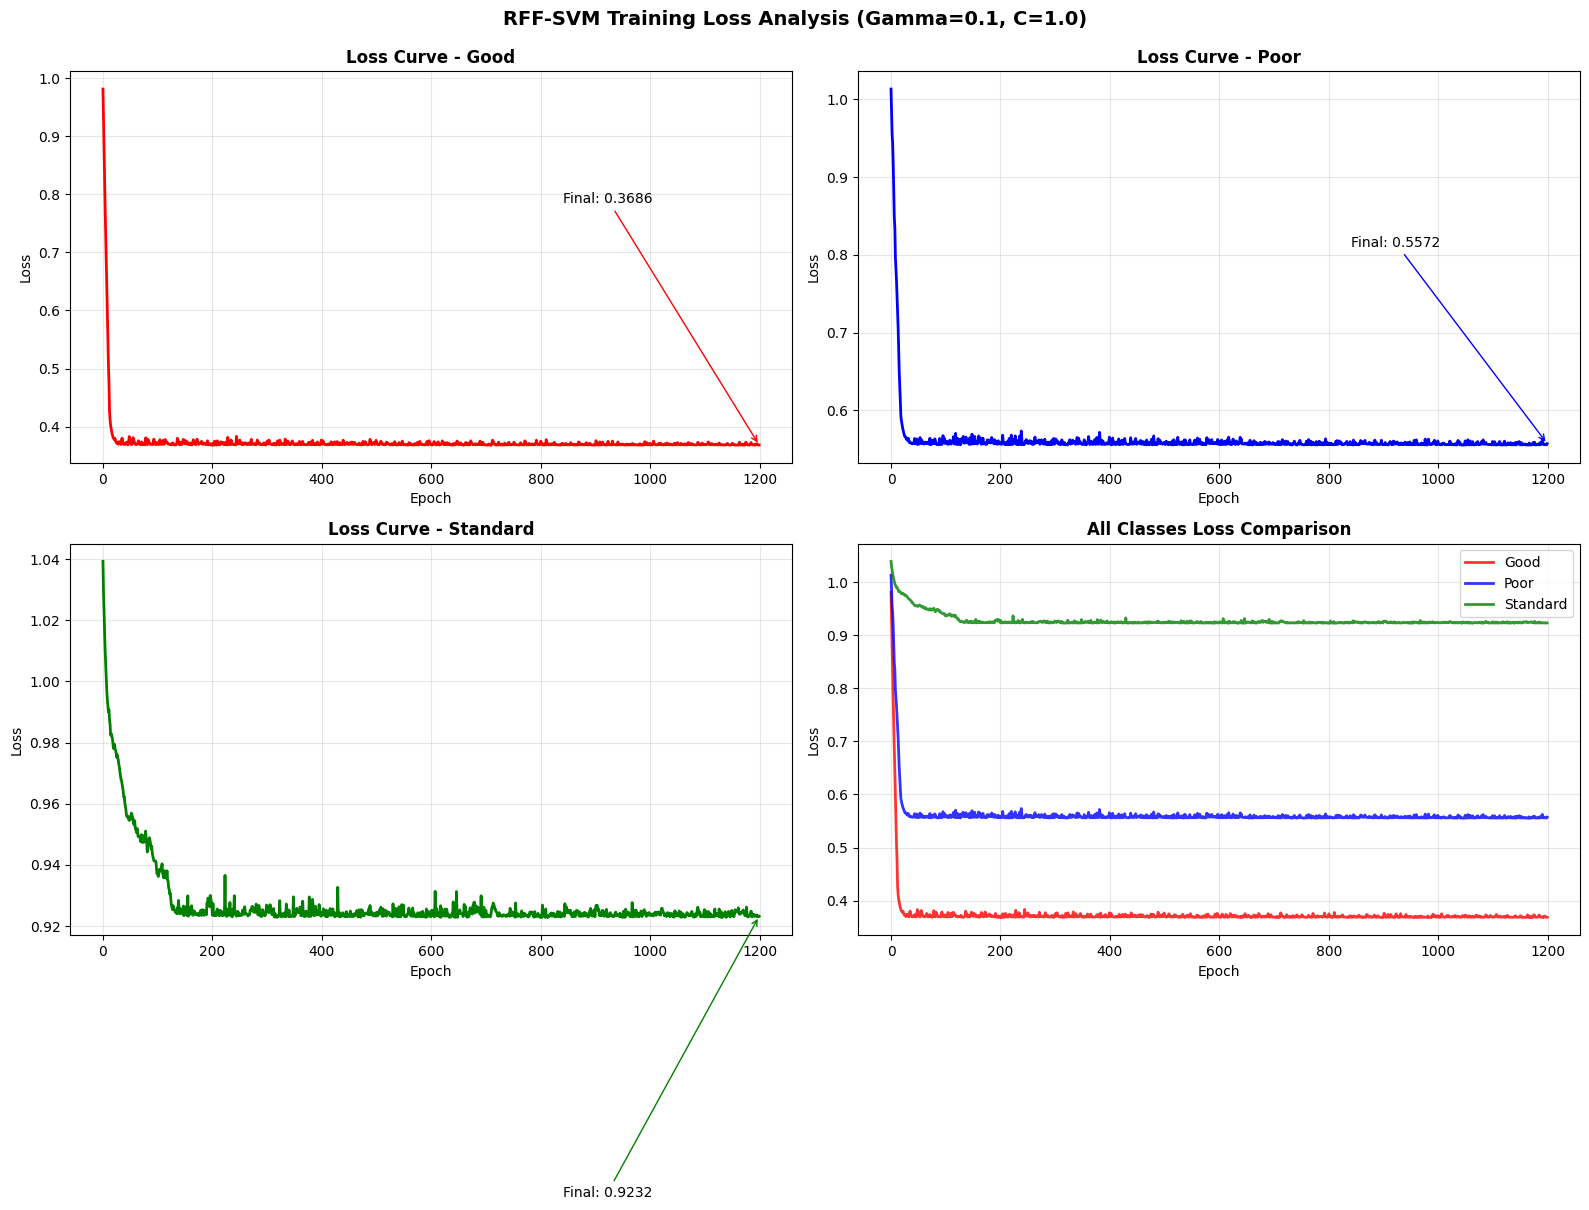

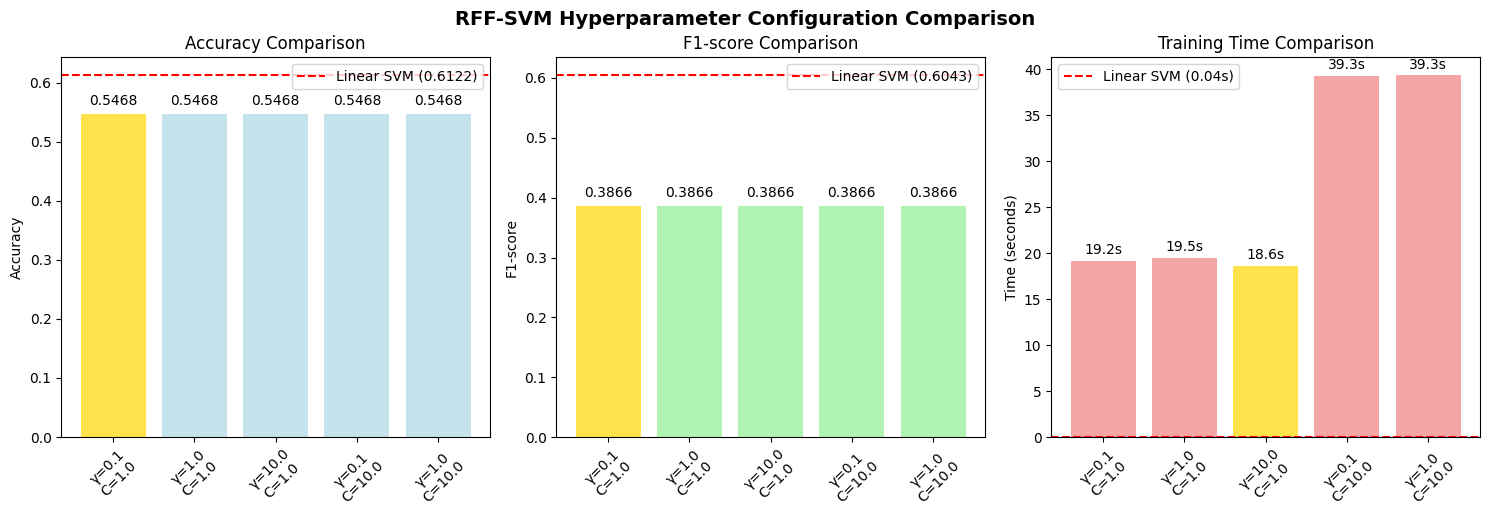


FEATURE IMPORTANCE ANALYSIS
Top 10 most important features (from Linear SVM):
                 feature  importance
11            Credit_Mix    0.316974
12      Outstanding_Debt    0.160725
7    Delay_from_due_date    0.144806
9   Changed_Credit_Limit    0.099186
14    Credit_History_Age    0.097041
17     Payment_Behaviour    0.016642
0                    Age    0.010979
4        Num_Credit_Card    0.007733
1          Annual_Income    0.007506
6            Num_of_Loan    0.006632


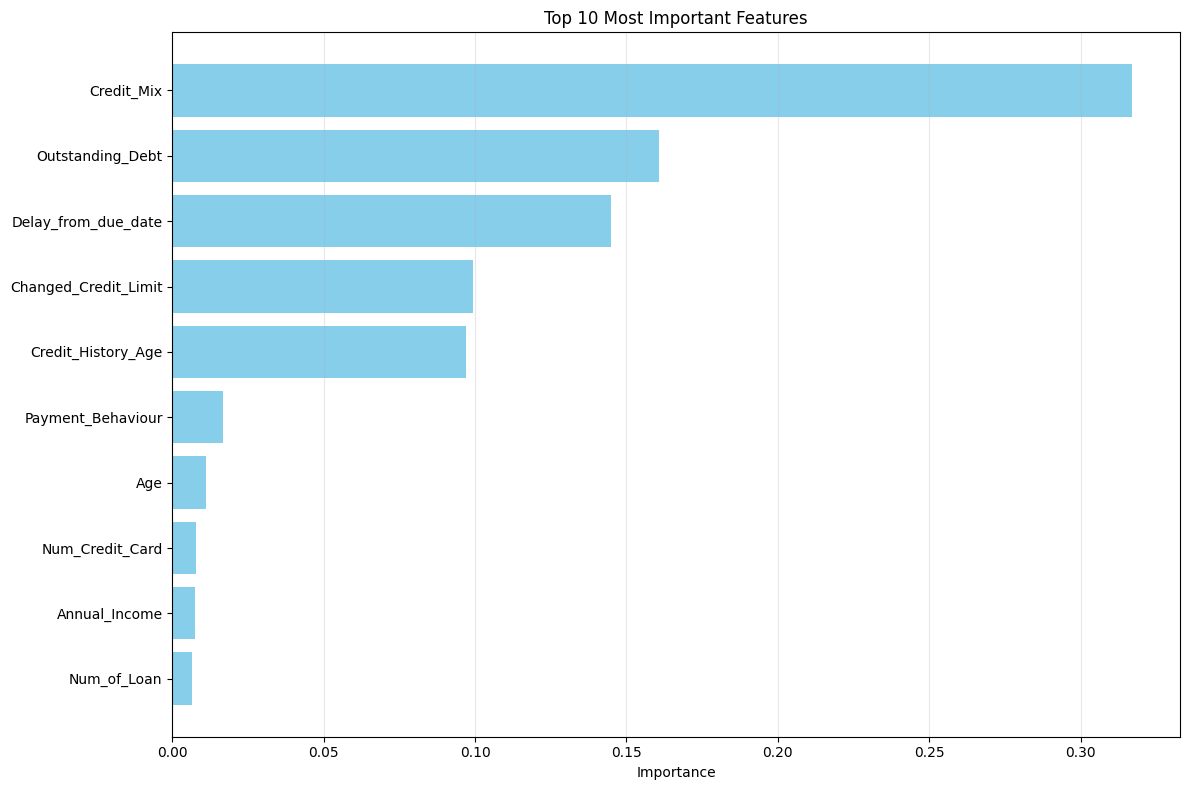

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, log_loss, f1_score
from sklearn.kernel_approximation import RBFSampler
import time

class ImprovedRFFSVM:
    def __init__(self, C=1.0, learning_rate=0.01, n_iters=1000,
                 gamma=1.0, n_components=1000, random_state=None):
        self.C = C
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.gamma = gamma
        self.n_components = n_components
        self.random_state = random_state
        self.models = {}
        self.loss_history = {}
        self.training_times = {}  # 记录每个类别的训练时间

    def _get_rff_features(self, X):
        """使用sklearn的RBFSampler生成更稳定的随机特征"""
        if not hasattr(self, 'rff_'):
            self.rff_ = RBFSampler(
                gamma=self.gamma,
                n_components=self.n_components,
                random_state=self.random_state
            )
            return self.rff_.fit_transform(X)
        else:
            return self.rff_.transform(X)

    def compute_loss(self, Z, y, w, b):
        """计算SVM损失"""
        margins = y * (np.dot(Z, w) + b)
        hinge_loss = np.maximum(0, 1 - margins)
        reg_term = 0.5 * np.dot(w, w)
        total_loss = reg_term + self.C * np.mean(hinge_loss)
        return total_loss

    def fit_binary_classifier(self, Z, y_binary, class_label):
        """训练二分类器 - 使用更稳定的优化方法"""
        n_samples, n_features = Z.shape

        # 初始化参数 - 使用小随机值而不是全零
        rng = np.random.RandomState(self.random_state)
        w = rng.normal(0, 0.01, n_features)
        b = 0.0

        losses = []
        best_loss = float('inf')
        best_w, best_b = w.copy(), b

        print(f"Training classifier for class {class_label}...")

        start_time = time.time()

        for epoch in range(self.n_iters):
            total_loss = 0
            count = 0

            # 学习率衰减
            current_lr = self.learning_rate / (1 + 0.001 * epoch)

            # Mini-batch SGD
            batch_size = min(32, n_samples)
            indices = np.random.choice(n_samples, batch_size, replace=False)

            Z_batch = Z[indices]
            y_batch = y_binary[indices]

            # 计算批量梯度
            predictions = np.dot(Z_batch, w) + b
            margins = y_batch * predictions

            # 计算hinge loss的指示函数
            misclassified = margins < 1
            hinge_grad = -y_batch * misclassified.astype(float)

            # 梯度计算
            w_grad = w + self.C * np.dot(hinge_grad, Z_batch) / batch_size
            b_grad = self.C * np.mean(hinge_grad)

            # 更新参数
            w = w - current_lr * w_grad
            b = b - current_lr * b_grad

            # 计算损失
            current_loss = self.compute_loss(Z, y_binary, w, b)
            losses.append(current_loss)

            # 保存最佳参数
            if current_loss < best_loss:
                best_loss = current_loss
                best_w, best_b = w.copy(), b

            if epoch % 200 == 0:
                print(f"  Epoch {epoch}: Loss = {current_loss:.4f}, LR = {current_lr:.6f}")

        training_time = time.time() - start_time
        self.training_times[class_label] = training_time
        self.loss_history[class_label] = losses

        print(f"  Class {class_label} training completed in {training_time:.2f} seconds")
        print(f"  Final loss: {losses[-1]:.4f}, Best loss: {best_loss:.4f}")

        return best_w, best_b

    def fit(self, X, y):
        """训练模型"""
        print("Generating RFF features...")
        start_time = time.time()
        Z = self._get_rff_features(X)
        feature_time = time.time() - start_time
        print(f"RFF feature generation time: {feature_time:.2f} seconds")

        self.classes_ = np.unique(y)

        print(f"Feature dimension: {X.shape[1]} -> {Z.shape[1]}")

        total_training_start = time.time()

        for class_label in self.classes_:
            y_binary = np.where(y == class_label, 1, -1)
            w, b = self.fit_binary_classifier(Z, y_binary, class_label)
            self.models[class_label] = {'weights': w, 'bias': b}

        self.total_training_time = time.time() - total_training_start
        print(f"Total training time: {self.total_training_time:.2f} seconds")

    def predict_proba(self, X):
        """预测概率"""
        Z = self._get_rff_features(X)
        n_samples = Z.shape[0]
        n_classes = len(self.classes_)
        scores = np.zeros((n_samples, n_classes))

        for i, class_label in enumerate(self.classes_):
            model = self.models[class_label]
            scores[:, i] = np.dot(Z, model['weights']) + model['bias']

        # 使用softmax
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return probabilities

    def predict(self, X):
        """预测类别"""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

# 数据预处理
def load_and_preprocess_data():
    train_data = pd.read_csv('train_data_m.csv')
    test_data = pd.read_csv('test_data.csv')

    def convert_to_float(age_str):
        if isinstance(age_str, str):
            years, months = map(int, age_str.replace('Years and', '').replace('Months', '').split())
            return years + months / 12.0
        return age_str

    train_data['Credit_History_Age'] = train_data['Credit_History_Age'].apply(convert_to_float)
    test_data['Credit_History_Age'] = test_data['Credit_History_Age'].apply(convert_to_float)

    credit_mix_mapping = {'Good': 2, 'Standard': 1, 'Bad': 0}
    train_data['Credit_Mix'] = train_data['Credit_Mix'].map(credit_mix_mapping)
    test_data['Credit_Mix'] = test_data['Credit_Mix'].map(credit_mix_mapping)

    unique_behaviors = train_data['Payment_Behaviour'].unique()
    behavior_mapping = {behavior: idx for idx, behavior in enumerate(unique_behaviors)}
    train_data['Payment_Behaviour'] = train_data['Payment_Behaviour'].map(behavior_mapping)
    test_data['Payment_Behaviour'] = test_data['Payment_Behaviour'].map(behavior_mapping)

    train_data = train_data.dropna()
    test_data = test_data.dropna()

    features = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
                'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
                'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

    X_train = train_data[features]
    y_train = train_data['Credit_Score']
    X_test = test_data[features]
    y_test = test_data['Credit_Score']

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, le

# 加载数据
X_train, X_test, y_train, y_test, label_encoder = load_and_preprocess_data()

print("=" * 70)
print("IMPROVED RBF-KERNEL SVM WITH RFF")
print("=" * 70)
print(f"Training: {X_train.shape}, Test: {X_test.shape}")
print(f"Class distribution: {np.bincount(y_train)}")

# 首先尝试线性SVM作为基准
from sklearn.svm import LinearSVC

print("\n" + "=" * 50)
print("BASELINE: LINEAR SVM")
print("=" * 50)

linear_start_time = time.time()
linear_svm = LinearSVC(C=1.0, random_state=42)
linear_svm.fit(X_train, y_train)
linear_training_time = time.time() - linear_start_time

y_pred_linear = linear_svm.predict(X_test)
linear_accuracy = accuracy_score(y_test, y_pred_linear)
linear_f1 = f1_score(y_test, y_pred_linear, average='weighted')

print(f"Linear SVM Accuracy: {linear_accuracy:.4f}")
print(f"Linear SVM F1-score: {linear_f1:.4f}")
print(f"Linear SVM Training Time: {linear_training_time:.2f} seconds")

# RFF-SVM参数搜索
print("\n" + "=" * 50)
print("RFF-SVM HYPERPARAMETER SEARCH")
print("=" * 50)

configs = [
    {'gamma': 0.1, 'C': 1.0, 'components': 1000, 'lr': 0.1},
    {'gamma': 1.0, 'C': 1.0, 'components': 1000, 'lr': 0.1},
    {'gamma': 10.0, 'C': 1.0, 'components': 1000, 'lr': 0.1},
    {'gamma': 0.1, 'C': 10.0, 'components': 2000, 'lr': 0.05},
    {'gamma': 1.0, 'C': 10.0, 'components': 2000, 'lr': 0.05},
]

best_accuracy = 0
best_f1 = 0
best_model = None
best_config = None
all_results = []

for i, config in enumerate(configs):
    print(f"\n--- Config {i+1}: gamma={config['gamma']}, C={config['C']} ---")

    try:
        model = ImprovedRFFSVM(
            C=config['C'],
            learning_rate=config['lr'],
            n_iters=1200,
            gamma=config['gamma'],
            n_components=config['components'],
            random_state=42
        )

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"RFF-SVM Accuracy: {accuracy:.4f}")
        print(f"RFF-SVM F1-score: {f1:.4f}")
        print(f"RFF-SVM Training Time: {model.total_training_time:.2f} seconds")

        # 保存结果
        result = {
            'config': config,
            'accuracy': accuracy,
            'f1_score': f1,
            'training_time': model.total_training_time,
            'model': model
        }
        all_results.append(result)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_f1 = f1
            best_model = model
            best_config = config

    except Exception as e:
        print(f"Training failed: {e}")

# 评估最佳模型
if best_model:
    print(f"\n" + "=" * 70)
    print("BEST RFF-SVM MODEL PERFORMANCE")
    print("=" * 70)

    print(f"Best Configuration:")
    print(f"  Gamma: {best_config['gamma']}")
    print(f"  C: {best_config['C']}")
    print(f"  Components: {best_config['components']}")
    print(f"  Learning Rate: {best_config['lr']}")

    print(f"\nPerformance Metrics:")
    print(f"  Accuracy: {best_accuracy:.4f}")
    print(f"  F1-score: {best_f1:.4f}")
    print(f"  Training Time: {best_model.total_training_time:.2f} seconds")

    print(f"\nComparison with Linear SVM:")
    print(f"  Accuracy Improvement: {best_accuracy - linear_accuracy:+.4f}")
    print(f"  F1-score Improvement: {best_f1 - linear_f1:+.4f}")
    print(f"  Training Time Difference: {best_model.total_training_time - linear_training_time:+.2f} seconds")

    y_pred_best = best_model.predict(X_test)
    y_proba_best = best_model.predict_proba(X_test)

    print(f"\nDetailed Metrics:")
    print(f"  Log Loss: {log_loss(y_test, y_proba_best):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

    # 绘制详细的损失曲线图
    plt.figure(figsize=(16, 12))

    # 1. 每个类别的损失曲线
    colors = ['red', 'blue', 'green']
    for idx, class_label in enumerate(best_model.classes_):
        plt.subplot(2, 2, idx + 1)
        losses = best_model.loss_history[class_label]
        plt.plot(losses, color=colors[idx], linewidth=2)
        plt.title(f'Loss Curve - {label_encoder.classes_[class_label]}', fontsize=12, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)

        # 添加最终损失值标注
        final_loss = losses[-1]
        plt.annotate(f'Final: {final_loss:.4f}',
                    xy=(len(losses)-1, final_loss),
                    xytext=(len(losses)*0.7, max(losses)*0.8),
                    arrowprops=dict(arrowstyle='->', color=colors[idx]))

    # 2. 所有类别损失对比
    plt.subplot(2, 2, 4)
    for idx, class_label in enumerate(best_model.classes_):
        losses = best_model.loss_history[class_label]
        plt.plot(losses, label=label_encoder.classes_[class_label],
                color=colors[idx], linewidth=2, alpha=0.8)

    plt.title('All Classes Loss Comparison', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle(f'RFF-SVM Training Loss Analysis (Gamma={best_config["gamma"]}, C={best_config["C"]})',
                fontsize=14, fontweight='bold', y=1.02)
    plt.show()

    # 绘制配置比较图
    if len(all_results) > 1:
        plt.figure(figsize=(15, 5))

        # 准确率比较
        plt.subplot(1, 3, 1)
        config_names = [f"γ={r['config']['gamma']}\nC={r['config']['C']}" for r in all_results]
        accuracies = [r['accuracy'] for r in all_results]
        colors = ['lightblue' if i != np.argmax(accuracies) else 'gold' for i in range(len(accuracies))]

        bars = plt.bar(config_names, accuracies, color=colors, alpha=0.7)
        plt.axhline(y=linear_accuracy, color='red', linestyle='--', label=f'Linear SVM ({linear_accuracy:.4f})')
        plt.title('Accuracy Comparison')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, acc in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.4f}', ha='center', va='bottom')

        # F1-score比较
        plt.subplot(1, 3, 2)
        f1_scores = [r['f1_score'] for r in all_results]
        colors = ['lightgreen' if i != np.argmax(f1_scores) else 'gold' for i in range(len(f1_scores))]

        bars = plt.bar(config_names, f1_scores, color=colors, alpha=0.7)
        plt.axhline(y=linear_f1, color='red', linestyle='--', label=f'Linear SVM ({linear_f1:.4f})')
        plt.title('F1-score Comparison')
        plt.ylabel('F1-score')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, f1 in zip(bars, f1_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{f1:.4f}', ha='center', va='bottom')

        # 训练时间比较
        plt.subplot(1, 3, 3)
        training_times = [r['training_time'] for r in all_results]
        colors = ['lightcoral' if i != np.argmin(training_times) else 'gold' for i in range(len(training_times))]

        bars = plt.bar(config_names, training_times, color=colors, alpha=0.7)
        plt.axhline(y=linear_training_time, color='red', linestyle='--',
                   label=f'Linear SVM ({linear_training_time:.2f}s)')
        plt.title('Training Time Comparison')
        plt.ylabel('Time (seconds)')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, time_val in zip(bars, training_times):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(training_times)*0.01,
                    f'{time_val:.1f}s', ha='center', va='bottom')

        plt.tight_layout()
        plt.suptitle('RFF-SVM Hyperparameter Configuration Comparison', fontsize=14, fontweight='bold', y=1.02)
        plt.show()

else:
    print(f"\nRFF-SVM did not improve over linear SVM.")
    print(f"Linear SVM - Accuracy: {linear_accuracy:.4f}, F1: {linear_f1:.4f}")
    print(f"Best RFF-SVM - Accuracy: {best_accuracy:.4f}, F1: {best_f1:.4f}")

# 特征重要性分析
print("\n" + "=" * 50)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

feature_names = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
                'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
                'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

if hasattr(linear_svm, 'coef_'):
    importance = np.mean(np.abs(linear_svm.coef_), axis=0)
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

    print("Top 10 most important features (from Linear SVM):")
    print(feature_imp.head(10))

    # 绘制特征重要性图
    plt.figure(figsize=(12, 8))
    top_features = feature_imp.head(10)
    plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Top 10 Most Important Features')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

IMPROVED RBF-KERNEL SVM WITH RFF
Training: (4782, 18), Test: (6939, 18)
Class distribution: [ 877 1290 2615]

BASELINE: LINEAR SVM
Linear SVM Accuracy: 0.6059
Linear SVM F1-score: 0.5946
Linear SVM Training Time: 0.02 seconds

RFF-SVM HYPERPARAMETER SEARCH

--- Config 1: gamma=0.1, C=1.0 ---
Generating RFF features...
RFF feature generation time: 0.19 seconds
Feature dimension: 18 -> 1000
Training classifier for class 0...
  Epoch 0: Loss = 0.9663, LR = 0.100000
  Epoch 200: Loss = 0.3750, LR = 0.083333
  Epoch 400: Loss = 0.3708, LR = 0.071429
  Epoch 600: Loss = 0.3678, LR = 0.062500
  Epoch 800: Loss = 0.3677, LR = 0.055556
  Epoch 1000: Loss = 0.3697, LR = 0.050000
  Class 0 training completed in 2.93 seconds
  Final loss: 0.3677, Best loss: 0.3670
Training classifier for class 1...
  Epoch 0: Loss = 1.0011, LR = 0.100000
  Epoch 200: Loss = 0.5468, LR = 0.083333
  Epoch 400: Loss = 0.5455, LR = 0.071429
  Epoch 600: Loss = 0.5400, LR = 0.062500
  Epoch 800: Loss = 0.5437, LR = 0.0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


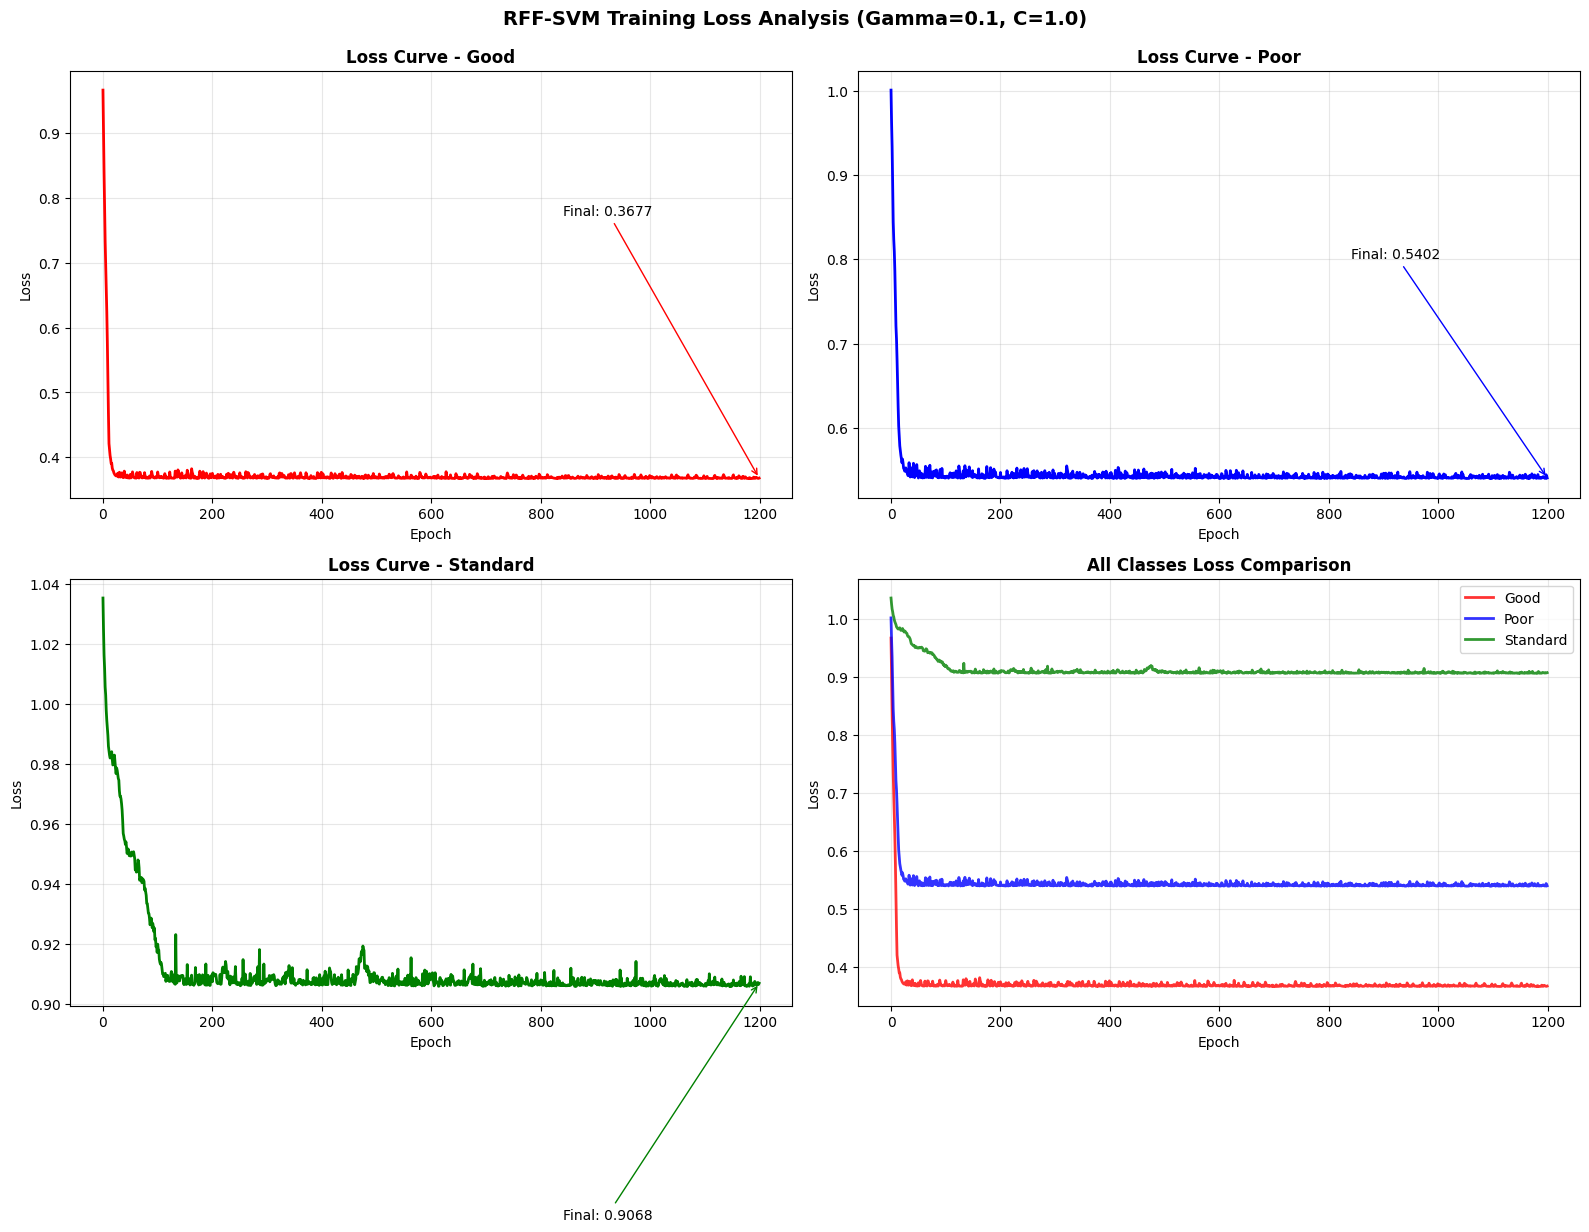

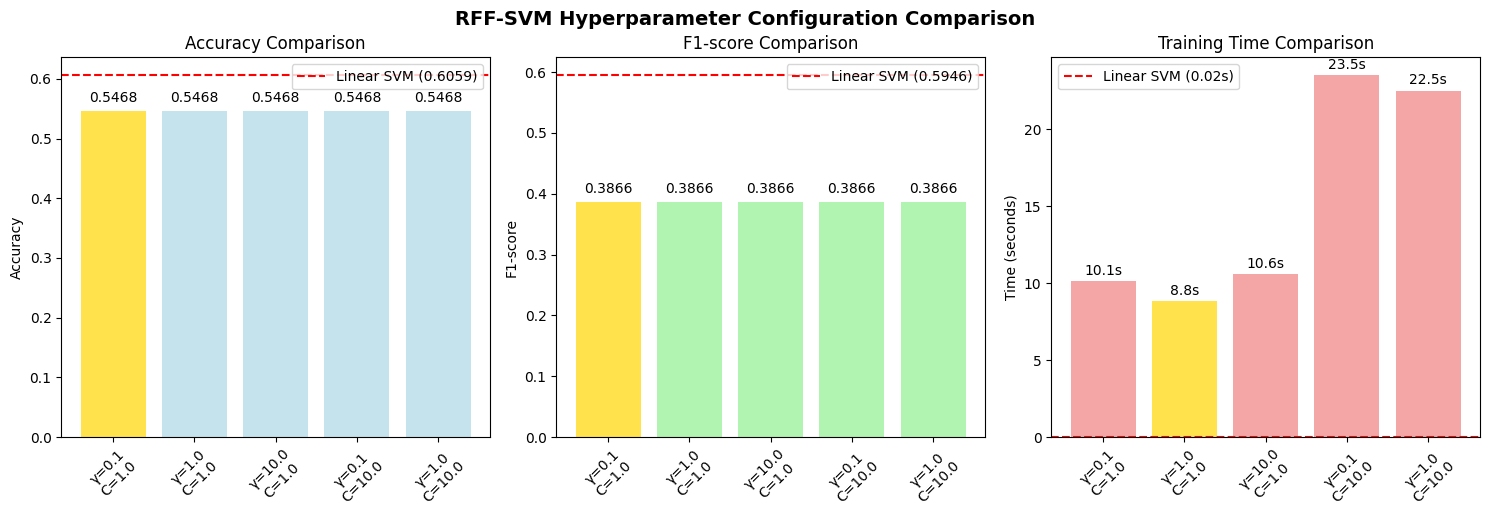


FEATURE IMPORTANCE ANALYSIS
Top 10 most important features (from Linear SVM):
                 feature  importance
11            Credit_Mix    0.305116
12      Outstanding_Debt    0.165144
7    Delay_from_due_date    0.151129
9   Changed_Credit_Limit    0.102541
14    Credit_History_Age    0.090244
17     Payment_Behaviour    0.029437
1          Annual_Income    0.018401
16       Monthly_Balance    0.012886
0                    Age    0.009540
10  Num_Credit_Inquiries    0.007192


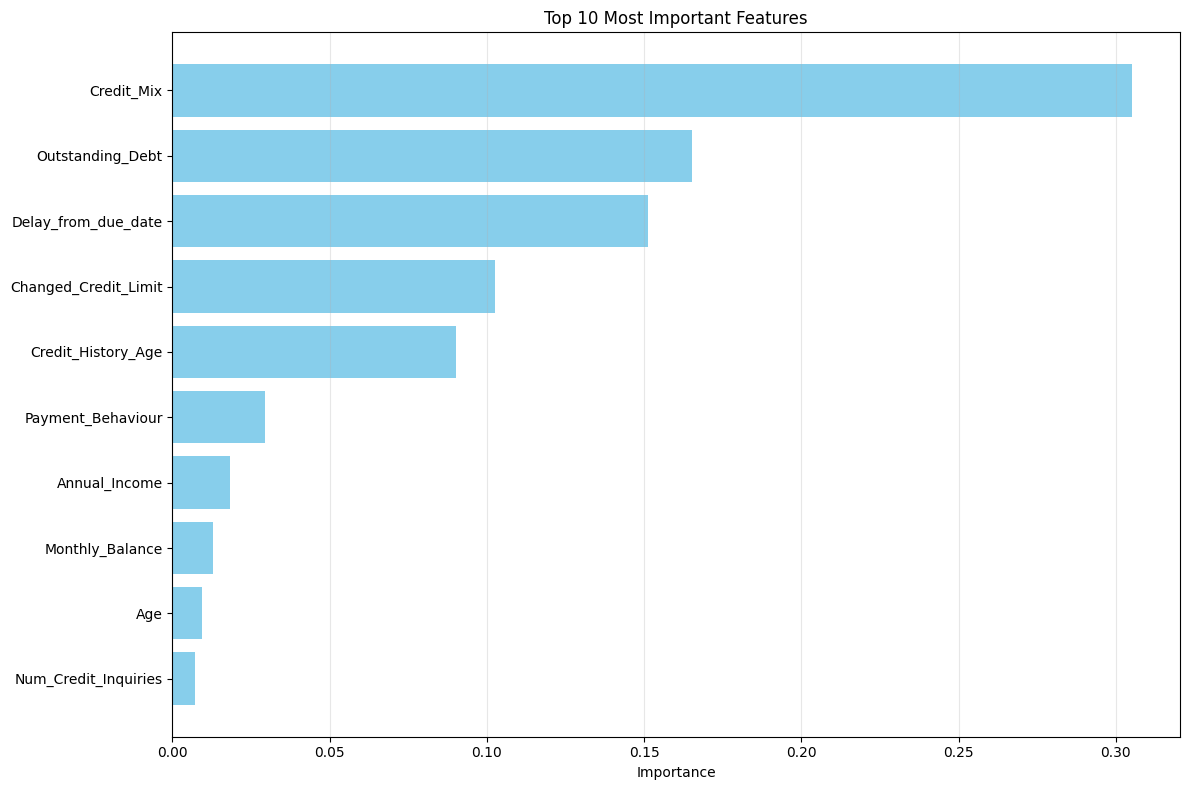

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, log_loss, f1_score
from sklearn.kernel_approximation import RBFSampler
import time

class ImprovedRFFSVM:
    def __init__(self, C=1.0, learning_rate=0.01, n_iters=1000,
                 gamma=1.0, n_components=1000, random_state=None):
        self.C = C
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.gamma = gamma
        self.n_components = n_components
        self.random_state = random_state
        self.models = {}
        self.loss_history = {}
        self.training_times = {}  # 记录每个类别的训练时间

    def _get_rff_features(self, X):
        """使用sklearn的RBFSampler生成更稳定的随机特征"""
        if not hasattr(self, 'rff_'):
            self.rff_ = RBFSampler(
                gamma=self.gamma,
                n_components=self.n_components,
                random_state=self.random_state
            )
            return self.rff_.fit_transform(X)
        else:
            return self.rff_.transform(X)

    def compute_loss(self, Z, y, w, b):
        """计算SVM损失"""
        margins = y * (np.dot(Z, w) + b)
        hinge_loss = np.maximum(0, 1 - margins)
        reg_term = 0.5 * np.dot(w, w)
        total_loss = reg_term + self.C * np.mean(hinge_loss)
        return total_loss

    def fit_binary_classifier(self, Z, y_binary, class_label):
        """训练二分类器 - 使用更稳定的优化方法"""
        n_samples, n_features = Z.shape

        # 初始化参数 - 使用小随机值而不是全零
        rng = np.random.RandomState(self.random_state)
        w = rng.normal(0, 0.01, n_features)
        b = 0.0

        losses = []
        best_loss = float('inf')
        best_w, best_b = w.copy(), b

        print(f"Training classifier for class {class_label}...")

        start_time = time.time()

        for epoch in range(self.n_iters):
            total_loss = 0
            count = 0

            # 学习率衰减
            current_lr = self.learning_rate / (1 + 0.001 * epoch)

            # Mini-batch SGD
            batch_size = min(32, n_samples)
            indices = np.random.choice(n_samples, batch_size, replace=False)

            Z_batch = Z[indices]
            y_batch = y_binary[indices]

            # 计算批量梯度
            predictions = np.dot(Z_batch, w) + b
            margins = y_batch * predictions

            # 计算hinge loss的指示函数
            misclassified = margins < 1
            hinge_grad = -y_batch * misclassified.astype(float)

            # 梯度计算
            w_grad = w + self.C * np.dot(hinge_grad, Z_batch) / batch_size
            b_grad = self.C * np.mean(hinge_grad)

            # 更新参数
            w = w - current_lr * w_grad
            b = b - current_lr * b_grad

            # 计算损失
            current_loss = self.compute_loss(Z, y_binary, w, b)
            losses.append(current_loss)

            # 保存最佳参数
            if current_loss < best_loss:
                best_loss = current_loss
                best_w, best_b = w.copy(), b

            if epoch % 200 == 0:
                print(f"  Epoch {epoch}: Loss = {current_loss:.4f}, LR = {current_lr:.6f}")

        training_time = time.time() - start_time
        self.training_times[class_label] = training_time
        self.loss_history[class_label] = losses

        print(f"  Class {class_label} training completed in {training_time:.2f} seconds")
        print(f"  Final loss: {losses[-1]:.4f}, Best loss: {best_loss:.4f}")

        return best_w, best_b

    def fit(self, X, y):
        """训练模型"""
        print("Generating RFF features...")
        start_time = time.time()
        Z = self._get_rff_features(X)
        feature_time = time.time() - start_time
        print(f"RFF feature generation time: {feature_time:.2f} seconds")

        self.classes_ = np.unique(y)

        print(f"Feature dimension: {X.shape[1]} -> {Z.shape[1]}")

        total_training_start = time.time()

        for class_label in self.classes_:
            y_binary = np.where(y == class_label, 1, -1)
            w, b = self.fit_binary_classifier(Z, y_binary, class_label)
            self.models[class_label] = {'weights': w, 'bias': b}

        self.total_training_time = time.time() - total_training_start
        print(f"Total training time: {self.total_training_time:.2f} seconds")

    def predict_proba(self, X):
        """预测概率"""
        Z = self._get_rff_features(X)
        n_samples = Z.shape[0]
        n_classes = len(self.classes_)
        scores = np.zeros((n_samples, n_classes))

        for i, class_label in enumerate(self.classes_):
            model = self.models[class_label]
            scores[:, i] = np.dot(Z, model['weights']) + model['bias']

        # 使用softmax
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return probabilities

    def predict(self, X):
        """预测类别"""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

# 数据预处理
def load_and_preprocess_data():
    train_data = pd.read_csv('train_data_s.csv')
    test_data = pd.read_csv('test_data.csv')

    def convert_to_float(age_str):
        if isinstance(age_str, str):
            years, months = map(int, age_str.replace('Years and', '').replace('Months', '').split())
            return years + months / 12.0
        return age_str

    train_data['Credit_History_Age'] = train_data['Credit_History_Age'].apply(convert_to_float)
    test_data['Credit_History_Age'] = test_data['Credit_History_Age'].apply(convert_to_float)

    credit_mix_mapping = {'Good': 2, 'Standard': 1, 'Bad': 0}
    train_data['Credit_Mix'] = train_data['Credit_Mix'].map(credit_mix_mapping)
    test_data['Credit_Mix'] = test_data['Credit_Mix'].map(credit_mix_mapping)

    unique_behaviors = train_data['Payment_Behaviour'].unique()
    behavior_mapping = {behavior: idx for idx, behavior in enumerate(unique_behaviors)}
    train_data['Payment_Behaviour'] = train_data['Payment_Behaviour'].map(behavior_mapping)
    test_data['Payment_Behaviour'] = test_data['Payment_Behaviour'].map(behavior_mapping)

    train_data = train_data.dropna()
    test_data = test_data.dropna()

    features = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
                'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
                'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

    X_train = train_data[features]
    y_train = train_data['Credit_Score']
    X_test = test_data[features]
    y_test = test_data['Credit_Score']

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, le

# 加载数据
X_train, X_test, y_train, y_test, label_encoder = load_and_preprocess_data()

print("=" * 70)
print("IMPROVED RBF-KERNEL SVM WITH RFF")
print("=" * 70)
print(f"Training: {X_train.shape}, Test: {X_test.shape}")
print(f"Class distribution: {np.bincount(y_train)}")

# 首先尝试线性SVM作为基准
from sklearn.svm import LinearSVC

print("\n" + "=" * 50)
print("BASELINE: LINEAR SVM")
print("=" * 50)

linear_start_time = time.time()
linear_svm = LinearSVC(C=1.0, random_state=42)
linear_svm.fit(X_train, y_train)
linear_training_time = time.time() - linear_start_time

y_pred_linear = linear_svm.predict(X_test)
linear_accuracy = accuracy_score(y_test, y_pred_linear)
linear_f1 = f1_score(y_test, y_pred_linear, average='weighted')

print(f"Linear SVM Accuracy: {linear_accuracy:.4f}")
print(f"Linear SVM F1-score: {linear_f1:.4f}")
print(f"Linear SVM Training Time: {linear_training_time:.2f} seconds")

# RFF-SVM参数搜索
print("\n" + "=" * 50)
print("RFF-SVM HYPERPARAMETER SEARCH")
print("=" * 50)

configs = [
    {'gamma': 0.1, 'C': 1.0, 'components': 1000, 'lr': 0.1},
    {'gamma': 1.0, 'C': 1.0, 'components': 1000, 'lr': 0.1},
    {'gamma': 10.0, 'C': 1.0, 'components': 1000, 'lr': 0.1},
    {'gamma': 0.1, 'C': 10.0, 'components': 2000, 'lr': 0.05},
    {'gamma': 1.0, 'C': 10.0, 'components': 2000, 'lr': 0.05},
]

best_accuracy = 0
best_f1 = 0
best_model = None
best_config = None
all_results = []

for i, config in enumerate(configs):
    print(f"\n--- Config {i+1}: gamma={config['gamma']}, C={config['C']} ---")

    try:
        model = ImprovedRFFSVM(
            C=config['C'],
            learning_rate=config['lr'],
            n_iters=1200,
            gamma=config['gamma'],
            n_components=config['components'],
            random_state=42
        )

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"RFF-SVM Accuracy: {accuracy:.4f}")
        print(f"RFF-SVM F1-score: {f1:.4f}")
        print(f"RFF-SVM Training Time: {model.total_training_time:.2f} seconds")

        # 保存结果
        result = {
            'config': config,
            'accuracy': accuracy,
            'f1_score': f1,
            'training_time': model.total_training_time,
            'model': model
        }
        all_results.append(result)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_f1 = f1
            best_model = model
            best_config = config

    except Exception as e:
        print(f"Training failed: {e}")

# 评估最佳模型
if best_model:
    print(f"\n" + "=" * 70)
    print("BEST RFF-SVM MODEL PERFORMANCE")
    print("=" * 70)

    print(f"Best Configuration:")
    print(f"  Gamma: {best_config['gamma']}")
    print(f"  C: {best_config['C']}")
    print(f"  Components: {best_config['components']}")
    print(f"  Learning Rate: {best_config['lr']}")

    print(f"\nPerformance Metrics:")
    print(f"  Accuracy: {best_accuracy:.4f}")
    print(f"  F1-score: {best_f1:.4f}")
    print(f"  Training Time: {best_model.total_training_time:.2f} seconds")

    print(f"\nComparison with Linear SVM:")
    print(f"  Accuracy Improvement: {best_accuracy - linear_accuracy:+.4f}")
    print(f"  F1-score Improvement: {best_f1 - linear_f1:+.4f}")
    print(f"  Training Time Difference: {best_model.total_training_time - linear_training_time:+.2f} seconds")

    y_pred_best = best_model.predict(X_test)
    y_proba_best = best_model.predict_proba(X_test)

    print(f"\nDetailed Metrics:")
    print(f"  Log Loss: {log_loss(y_test, y_proba_best):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

    # 绘制详细的损失曲线图
    plt.figure(figsize=(16, 12))

    # 1. 每个类别的损失曲线
    colors = ['red', 'blue', 'green']
    for idx, class_label in enumerate(best_model.classes_):
        plt.subplot(2, 2, idx + 1)
        losses = best_model.loss_history[class_label]
        plt.plot(losses, color=colors[idx], linewidth=2)
        plt.title(f'Loss Curve - {label_encoder.classes_[class_label]}', fontsize=12, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)

        # 添加最终损失值标注
        final_loss = losses[-1]
        plt.annotate(f'Final: {final_loss:.4f}',
                    xy=(len(losses)-1, final_loss),
                    xytext=(len(losses)*0.7, max(losses)*0.8),
                    arrowprops=dict(arrowstyle='->', color=colors[idx]))

    # 2. 所有类别损失对比
    plt.subplot(2, 2, 4)
    for idx, class_label in enumerate(best_model.classes_):
        losses = best_model.loss_history[class_label]
        plt.plot(losses, label=label_encoder.classes_[class_label],
                color=colors[idx], linewidth=2, alpha=0.8)

    plt.title('All Classes Loss Comparison', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle(f'RFF-SVM Training Loss Analysis (Gamma={best_config["gamma"]}, C={best_config["C"]})',
                fontsize=14, fontweight='bold', y=1.02)
    plt.show()

    # 绘制配置比较图
    if len(all_results) > 1:
        plt.figure(figsize=(15, 5))

        # 准确率比较
        plt.subplot(1, 3, 1)
        config_names = [f"γ={r['config']['gamma']}\nC={r['config']['C']}" for r in all_results]
        accuracies = [r['accuracy'] for r in all_results]
        colors = ['lightblue' if i != np.argmax(accuracies) else 'gold' for i in range(len(accuracies))]

        bars = plt.bar(config_names, accuracies, color=colors, alpha=0.7)
        plt.axhline(y=linear_accuracy, color='red', linestyle='--', label=f'Linear SVM ({linear_accuracy:.4f})')
        plt.title('Accuracy Comparison')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, acc in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.4f}', ha='center', va='bottom')

        # F1-score比较
        plt.subplot(1, 3, 2)
        f1_scores = [r['f1_score'] for r in all_results]
        colors = ['lightgreen' if i != np.argmax(f1_scores) else 'gold' for i in range(len(f1_scores))]

        bars = plt.bar(config_names, f1_scores, color=colors, alpha=0.7)
        plt.axhline(y=linear_f1, color='red', linestyle='--', label=f'Linear SVM ({linear_f1:.4f})')
        plt.title('F1-score Comparison')
        plt.ylabel('F1-score')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, f1 in zip(bars, f1_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{f1:.4f}', ha='center', va='bottom')

        # 训练时间比较
        plt.subplot(1, 3, 3)
        training_times = [r['training_time'] for r in all_results]
        colors = ['lightcoral' if i != np.argmin(training_times) else 'gold' for i in range(len(training_times))]

        bars = plt.bar(config_names, training_times, color=colors, alpha=0.7)
        plt.axhline(y=linear_training_time, color='red', linestyle='--',
                   label=f'Linear SVM ({linear_training_time:.2f}s)')
        plt.title('Training Time Comparison')
        plt.ylabel('Time (seconds)')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, time_val in zip(bars, training_times):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(training_times)*0.01,
                    f'{time_val:.1f}s', ha='center', va='bottom')

        plt.tight_layout()
        plt.suptitle('RFF-SVM Hyperparameter Configuration Comparison', fontsize=14, fontweight='bold', y=1.02)
        plt.show()

else:
    print(f"\nRFF-SVM did not improve over linear SVM.")
    print(f"Linear SVM - Accuracy: {linear_accuracy:.4f}, F1: {linear_f1:.4f}")
    print(f"Best RFF-SVM - Accuracy: {best_accuracy:.4f}, F1: {best_f1:.4f}")

# 特征重要性分析
print("\n" + "=" * 50)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

feature_names = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
                'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
                'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

if hasattr(linear_svm, 'coef_'):
    importance = np.mean(np.abs(linear_svm.coef_), axis=0)
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

    print("Top 10 most important features (from Linear SVM):")
    print(feature_imp.head(10))

    # 绘制特征重要性图
    plt.figure(figsize=(12, 8))
    top_features = feature_imp.head(10)
    plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Top 10 Most Important Features')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

IMPROVED RBF-KERNEL SVM WITH RFF
Training: (11122, 18), Test: (6939, 18)
Class distribution: [2011 3086 6025]

BASELINE: LINEAR SVM
Linear SVM Accuracy: 0.6131
Linear SVM F1-score: 0.6043
Linear SVM Training Time: 0.06 seconds

RFF-SVM HYPERPARAMETER SEARCH

--- Config 1: gamma=0.1, C=1.0 ---
Generating RFF features...
RFF feature generation time: 0.37 seconds
Feature dimension: 18 -> 1000
Training classifier for class 0...
  Epoch 0: Loss = 1.0045, LR = 0.100000
  Epoch 200: Loss = 0.3638, LR = 0.083333
  Epoch 400: Loss = 0.3661, LR = 0.071429
  Epoch 600: Loss = 0.3632, LR = 0.062500
  Epoch 800: Loss = 0.3632, LR = 0.055556
  Epoch 1000: Loss = 0.3631, LR = 0.050000
  Class 0 training completed in 9.61 seconds
  Final loss: 0.3622, Best loss: 0.3620
Training classifier for class 1...
  Epoch 0: Loss = 1.0011, LR = 0.100000
  Epoch 200: Loss = 0.5553, LR = 0.083333
  Epoch 400: Loss = 0.5645, LR = 0.071429
  Epoch 600: Loss = 0.5563, LR = 0.062500
  Epoch 800: Loss = 0.5552, LR = 0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


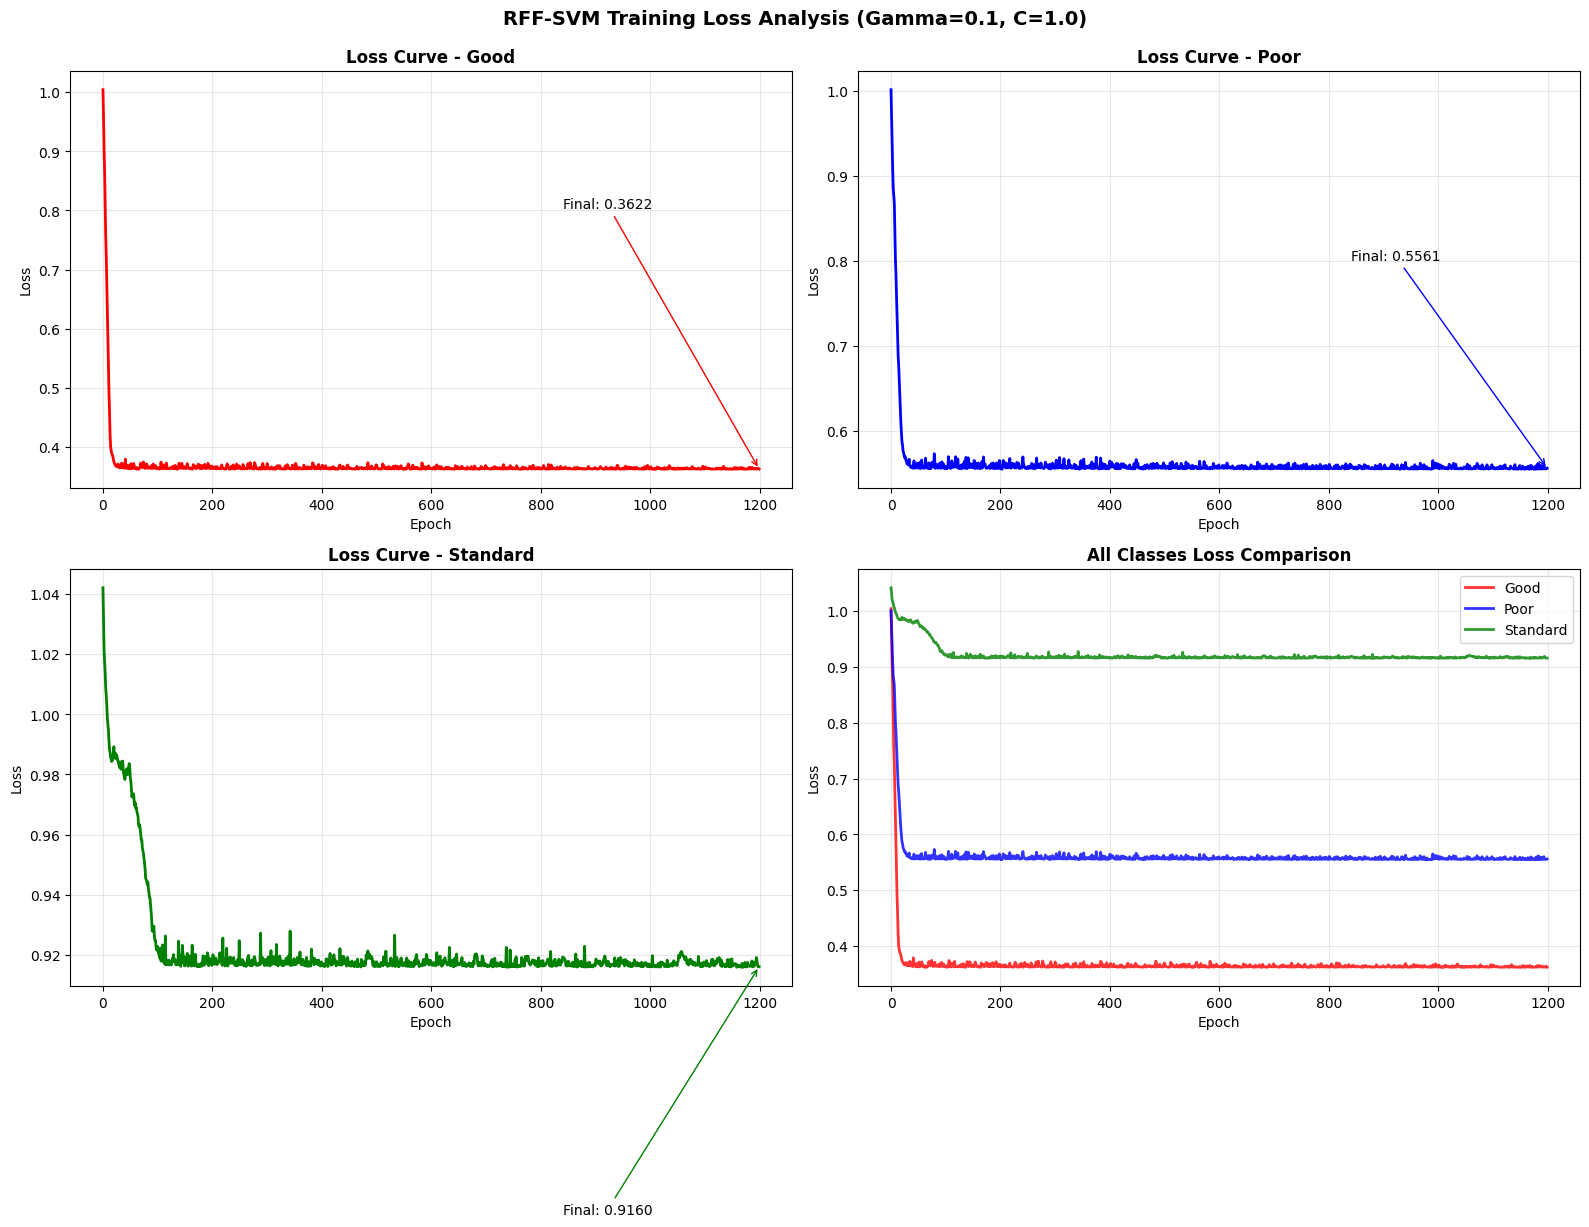

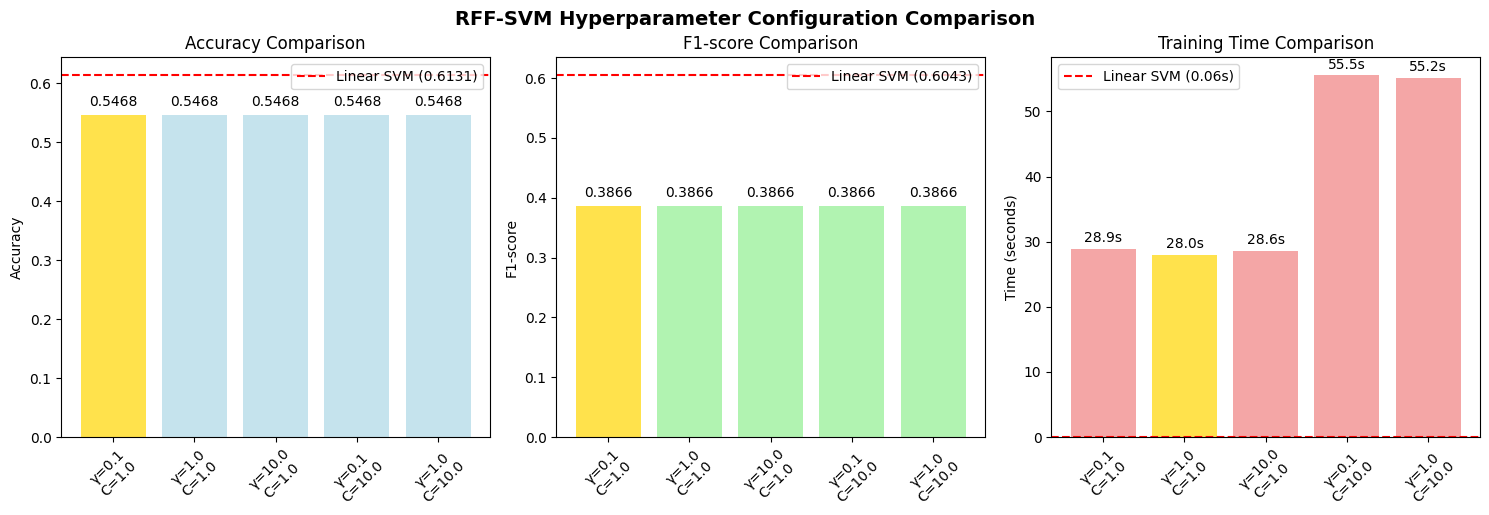


FEATURE IMPORTANCE ANALYSIS
Top 10 most important features (from Linear SVM):
                  feature  importance
11             Credit_Mix    0.307127
12       Outstanding_Debt    0.157980
7     Delay_from_due_date    0.149883
9    Changed_Credit_Limit    0.099238
14     Credit_History_Age    0.088724
0                     Age    0.013527
17      Payment_Behaviour    0.011698
3       Num_Bank_Accounts    0.009100
2   Monthly_Inhand_Salary    0.009085
6             Num_of_Loan    0.007460


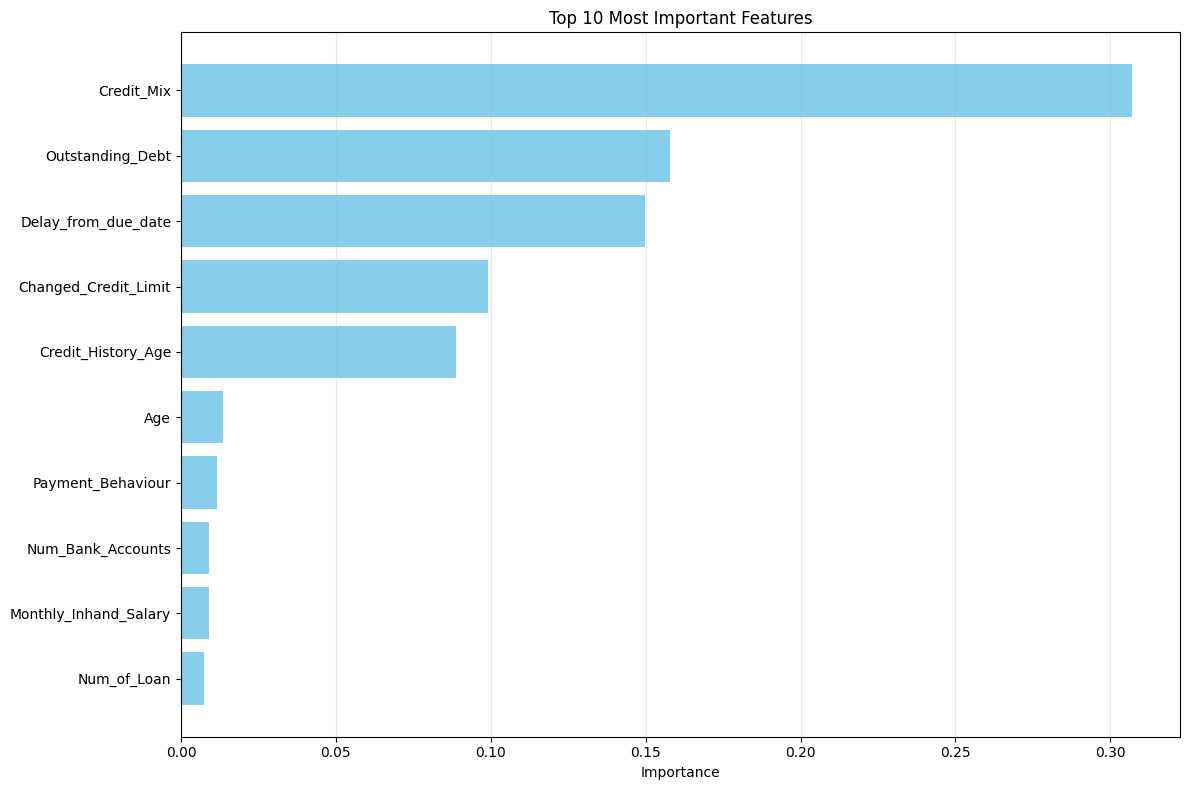

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, log_loss, f1_score
from sklearn.kernel_approximation import RBFSampler
import time

class ImprovedRFFSVM:
    def __init__(self, C=1.0, learning_rate=0.01, n_iters=1000,
                 gamma=1.0, n_components=1000, random_state=None):
        self.C = C
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.gamma = gamma
        self.n_components = n_components
        self.random_state = random_state
        self.models = {}
        self.loss_history = {}
        self.training_times = {}  # 记录每个类别的训练时间

    def _get_rff_features(self, X):
        """使用sklearn的RBFSampler生成更稳定的随机特征"""
        if not hasattr(self, 'rff_'):
            self.rff_ = RBFSampler(
                gamma=self.gamma,
                n_components=self.n_components,
                random_state=self.random_state
            )
            return self.rff_.fit_transform(X)
        else:
            return self.rff_.transform(X)

    def compute_loss(self, Z, y, w, b):
        """计算SVM损失"""
        margins = y * (np.dot(Z, w) + b)
        hinge_loss = np.maximum(0, 1 - margins)
        reg_term = 0.5 * np.dot(w, w)
        total_loss = reg_term + self.C * np.mean(hinge_loss)
        return total_loss

    def fit_binary_classifier(self, Z, y_binary, class_label):
        """训练二分类器 - 使用更稳定的优化方法"""
        n_samples, n_features = Z.shape

        # 初始化参数 - 使用小随机值而不是全零
        rng = np.random.RandomState(self.random_state)
        w = rng.normal(0, 0.01, n_features)
        b = 0.0

        losses = []
        best_loss = float('inf')
        best_w, best_b = w.copy(), b

        print(f"Training classifier for class {class_label}...")

        start_time = time.time()

        for epoch in range(self.n_iters):
            total_loss = 0
            count = 0

            # 学习率衰减
            current_lr = self.learning_rate / (1 + 0.001 * epoch)

            # Mini-batch SGD
            batch_size = min(32, n_samples)
            indices = np.random.choice(n_samples, batch_size, replace=False)

            Z_batch = Z[indices]
            y_batch = y_binary[indices]

            # 计算批量梯度
            predictions = np.dot(Z_batch, w) + b
            margins = y_batch * predictions

            # 计算hinge loss的指示函数
            misclassified = margins < 1
            hinge_grad = -y_batch * misclassified.astype(float)

            # 梯度计算
            w_grad = w + self.C * np.dot(hinge_grad, Z_batch) / batch_size
            b_grad = self.C * np.mean(hinge_grad)

            # 更新参数
            w = w - current_lr * w_grad
            b = b - current_lr * b_grad

            # 计算损失
            current_loss = self.compute_loss(Z, y_binary, w, b)
            losses.append(current_loss)

            # 保存最佳参数
            if current_loss < best_loss:
                best_loss = current_loss
                best_w, best_b = w.copy(), b

            if epoch % 200 == 0:
                print(f"  Epoch {epoch}: Loss = {current_loss:.4f}, LR = {current_lr:.6f}")

        training_time = time.time() - start_time
        self.training_times[class_label] = training_time
        self.loss_history[class_label] = losses

        print(f"  Class {class_label} training completed in {training_time:.2f} seconds")
        print(f"  Final loss: {losses[-1]:.4f}, Best loss: {best_loss:.4f}")

        return best_w, best_b

    def fit(self, X, y):
        """训练模型"""
        print("Generating RFF features...")
        start_time = time.time()
        Z = self._get_rff_features(X)
        feature_time = time.time() - start_time
        print(f"RFF feature generation time: {feature_time:.2f} seconds")

        self.classes_ = np.unique(y)

        print(f"Feature dimension: {X.shape[1]} -> {Z.shape[1]}")

        total_training_start = time.time()

        for class_label in self.classes_:
            y_binary = np.where(y == class_label, 1, -1)
            w, b = self.fit_binary_classifier(Z, y_binary, class_label)
            self.models[class_label] = {'weights': w, 'bias': b}

        self.total_training_time = time.time() - total_training_start
        print(f"Total training time: {self.total_training_time:.2f} seconds")

    def predict_proba(self, X):
        """预测概率"""
        Z = self._get_rff_features(X)
        n_samples = Z.shape[0]
        n_classes = len(self.classes_)
        scores = np.zeros((n_samples, n_classes))

        for i, class_label in enumerate(self.classes_):
            model = self.models[class_label]
            scores[:, i] = np.dot(Z, model['weights']) + model['bias']

        # 使用softmax
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return probabilities

    def predict(self, X):
        """预测类别"""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

# 数据预处理
def load_and_preprocess_data():
    train_data = pd.read_csv('train_data_l.csv')
    test_data = pd.read_csv('test_data.csv')

    def convert_to_float(age_str):
        if isinstance(age_str, str):
            years, months = map(int, age_str.replace('Years and', '').replace('Months', '').split())
            return years + months / 12.0
        return age_str

    train_data['Credit_History_Age'] = train_data['Credit_History_Age'].apply(convert_to_float)
    test_data['Credit_History_Age'] = test_data['Credit_History_Age'].apply(convert_to_float)

    credit_mix_mapping = {'Good': 2, 'Standard': 1, 'Bad': 0}
    train_data['Credit_Mix'] = train_data['Credit_Mix'].map(credit_mix_mapping)
    test_data['Credit_Mix'] = test_data['Credit_Mix'].map(credit_mix_mapping)

    unique_behaviors = train_data['Payment_Behaviour'].unique()
    behavior_mapping = {behavior: idx for idx, behavior in enumerate(unique_behaviors)}
    train_data['Payment_Behaviour'] = train_data['Payment_Behaviour'].map(behavior_mapping)
    test_data['Payment_Behaviour'] = test_data['Payment_Behaviour'].map(behavior_mapping)

    train_data = train_data.dropna()
    test_data = test_data.dropna()

    features = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
                'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
                'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

    X_train = train_data[features]
    y_train = train_data['Credit_Score']
    X_test = test_data[features]
    y_test = test_data['Credit_Score']

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, le

# 加载数据
X_train, X_test, y_train, y_test, label_encoder = load_and_preprocess_data()

print("=" * 70)
print("IMPROVED RBF-KERNEL SVM WITH RFF")
print("=" * 70)
print(f"Training: {X_train.shape}, Test: {X_test.shape}")
print(f"Class distribution: {np.bincount(y_train)}")

# 首先尝试线性SVM作为基准
from sklearn.svm import LinearSVC

print("\n" + "=" * 50)
print("BASELINE: LINEAR SVM")
print("=" * 50)

linear_start_time = time.time()
linear_svm = LinearSVC(C=1.0, random_state=42)
linear_svm.fit(X_train, y_train)
linear_training_time = time.time() - linear_start_time

y_pred_linear = linear_svm.predict(X_test)
linear_accuracy = accuracy_score(y_test, y_pred_linear)
linear_f1 = f1_score(y_test, y_pred_linear, average='weighted')

print(f"Linear SVM Accuracy: {linear_accuracy:.4f}")
print(f"Linear SVM F1-score: {linear_f1:.4f}")
print(f"Linear SVM Training Time: {linear_training_time:.2f} seconds")

# RFF-SVM参数搜索
print("\n" + "=" * 50)
print("RFF-SVM HYPERPARAMETER SEARCH")
print("=" * 50)

configs = [
    {'gamma': 0.1, 'C': 1.0, 'components': 1000, 'lr': 0.1},
    {'gamma': 1.0, 'C': 1.0, 'components': 1000, 'lr': 0.1},
    {'gamma': 10.0, 'C': 1.0, 'components': 1000, 'lr': 0.1},
    {'gamma': 0.1, 'C': 10.0, 'components': 2000, 'lr': 0.05},
    {'gamma': 1.0, 'C': 10.0, 'components': 2000, 'lr': 0.05},
]

best_accuracy = 0
best_f1 = 0
best_model = None
best_config = None
all_results = []

for i, config in enumerate(configs):
    print(f"\n--- Config {i+1}: gamma={config['gamma']}, C={config['C']} ---")

    try:
        model = ImprovedRFFSVM(
            C=config['C'],
            learning_rate=config['lr'],
            n_iters=1200,
            gamma=config['gamma'],
            n_components=config['components'],
            random_state=42
        )

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"RFF-SVM Accuracy: {accuracy:.4f}")
        print(f"RFF-SVM F1-score: {f1:.4f}")
        print(f"RFF-SVM Training Time: {model.total_training_time:.2f} seconds")

        # 保存结果
        result = {
            'config': config,
            'accuracy': accuracy,
            'f1_score': f1,
            'training_time': model.total_training_time,
            'model': model
        }
        all_results.append(result)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_f1 = f1
            best_model = model
            best_config = config

    except Exception as e:
        print(f"Training failed: {e}")

# 评估最佳模型
if best_model:
    print(f"\n" + "=" * 70)
    print("BEST RFF-SVM MODEL PERFORMANCE")
    print("=" * 70)

    print(f"Best Configuration:")
    print(f"  Gamma: {best_config['gamma']}")
    print(f"  C: {best_config['C']}")
    print(f"  Components: {best_config['components']}")
    print(f"  Learning Rate: {best_config['lr']}")

    print(f"\nPerformance Metrics:")
    print(f"  Accuracy: {best_accuracy:.4f}")
    print(f"  F1-score: {best_f1:.4f}")
    print(f"  Training Time: {best_model.total_training_time:.2f} seconds")

    print(f"\nComparison with Linear SVM:")
    print(f"  Accuracy Improvement: {best_accuracy - linear_accuracy:+.4f}")
    print(f"  F1-score Improvement: {best_f1 - linear_f1:+.4f}")
    print(f"  Training Time Difference: {best_model.total_training_time - linear_training_time:+.2f} seconds")

    y_pred_best = best_model.predict(X_test)
    y_proba_best = best_model.predict_proba(X_test)

    print(f"\nDetailed Metrics:")
    print(f"  Log Loss: {log_loss(y_test, y_proba_best):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

    # 绘制详细的损失曲线图
    plt.figure(figsize=(16, 12))

    # 1. 每个类别的损失曲线
    colors = ['red', 'blue', 'green']
    for idx, class_label in enumerate(best_model.classes_):
        plt.subplot(2, 2, idx + 1)
        losses = best_model.loss_history[class_label]
        plt.plot(losses, color=colors[idx], linewidth=2)
        plt.title(f'Loss Curve - {label_encoder.classes_[class_label]}', fontsize=12, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)

        # 添加最终损失值标注
        final_loss = losses[-1]
        plt.annotate(f'Final: {final_loss:.4f}',
                    xy=(len(losses)-1, final_loss),
                    xytext=(len(losses)*0.7, max(losses)*0.8),
                    arrowprops=dict(arrowstyle='->', color=colors[idx]))

    # 2. 所有类别损失对比
    plt.subplot(2, 2, 4)
    for idx, class_label in enumerate(best_model.classes_):
        losses = best_model.loss_history[class_label]
        plt.plot(losses, label=label_encoder.classes_[class_label],
                color=colors[idx], linewidth=2, alpha=0.8)

    plt.title('All Classes Loss Comparison', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle(f'RFF-SVM Training Loss Analysis (Gamma={best_config["gamma"]}, C={best_config["C"]})',
                fontsize=14, fontweight='bold', y=1.02)
    plt.show()

    # 绘制配置比较图
    if len(all_results) > 1:
        plt.figure(figsize=(15, 5))

        # 准确率比较
        plt.subplot(1, 3, 1)
        config_names = [f"γ={r['config']['gamma']}\nC={r['config']['C']}" for r in all_results]
        accuracies = [r['accuracy'] for r in all_results]
        colors = ['lightblue' if i != np.argmax(accuracies) else 'gold' for i in range(len(accuracies))]

        bars = plt.bar(config_names, accuracies, color=colors, alpha=0.7)
        plt.axhline(y=linear_accuracy, color='red', linestyle='--', label=f'Linear SVM ({linear_accuracy:.4f})')
        plt.title('Accuracy Comparison')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, acc in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.4f}', ha='center', va='bottom')

        # F1-score比较
        plt.subplot(1, 3, 2)
        f1_scores = [r['f1_score'] for r in all_results]
        colors = ['lightgreen' if i != np.argmax(f1_scores) else 'gold' for i in range(len(f1_scores))]

        bars = plt.bar(config_names, f1_scores, color=colors, alpha=0.7)
        plt.axhline(y=linear_f1, color='red', linestyle='--', label=f'Linear SVM ({linear_f1:.4f})')
        plt.title('F1-score Comparison')
        plt.ylabel('F1-score')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, f1 in zip(bars, f1_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{f1:.4f}', ha='center', va='bottom')

        # 训练时间比较
        plt.subplot(1, 3, 3)
        training_times = [r['training_time'] for r in all_results]
        colors = ['lightcoral' if i != np.argmin(training_times) else 'gold' for i in range(len(training_times))]

        bars = plt.bar(config_names, training_times, color=colors, alpha=0.7)
        plt.axhline(y=linear_training_time, color='red', linestyle='--',
                   label=f'Linear SVM ({linear_training_time:.2f}s)')
        plt.title('Training Time Comparison')
        plt.ylabel('Time (seconds)')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, time_val in zip(bars, training_times):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(training_times)*0.01,
                    f'{time_val:.1f}s', ha='center', va='bottom')

        plt.tight_layout()
        plt.suptitle('RFF-SVM Hyperparameter Configuration Comparison', fontsize=14, fontweight='bold', y=1.02)
        plt.show()

else:
    print(f"\nRFF-SVM did not improve over linear SVM.")
    print(f"Linear SVM - Accuracy: {linear_accuracy:.4f}, F1: {linear_f1:.4f}")
    print(f"Best RFF-SVM - Accuracy: {best_accuracy:.4f}, F1: {best_f1:.4f}")

# 特征重要性分析
print("\n" + "=" * 50)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

feature_names = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
                'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
                'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

if hasattr(linear_svm, 'coef_'):
    importance = np.mean(np.abs(linear_svm.coef_), axis=0)
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

    print("Top 10 most important features (from Linear SVM):")
    print(feature_imp.head(10))

    # 绘制特征重要性图
    plt.figure(figsize=(12, 8))
    top_features = feature_imp.head(10)
    plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Top 10 Most Important Features')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

POLYNOMIAL KERNEL SVM WITH SGD
Training: (4782, 18), Test: (6939, 18)
Class distribution: [ 877 1290 2615]

BASELINE: LINEAR SVM
Linear SVM Accuracy: 0.6059
Linear SVM F1-score: 0.5946
Linear SVM Training Time: 0.02 seconds

POLYNOMIAL SVM HYPERPARAMETER SEARCH

--- Config 1: degree=2, C=1.0 ---
Generating polynomial features (degree=2)...
Polynomial feature generation time: 0.01 seconds
Feature dimension: 18 -> 190
Class distribution: [ 877 1290 2615]
Training polynomial classifier for class 0...
Polynomial feature dimension: 190
  Epoch 0: Loss = 1.0043, Acc = 0.5040, LR = 0.010000
  Epoch 200: Loss = 0.4304, Acc = 0.8168, LR = 0.008333
  Epoch 400: Loss = 0.4028, Acc = 0.8168, LR = 0.007143
  Epoch 600: Loss = 0.3981, Acc = 0.8124, LR = 0.006250
  Class 0 completed: Time = 0.53s, Final Loss = 0.3777, Accuracy = 0.8168
Training polynomial classifier for class 1...
Polynomial feature dimension: 190
  Epoch 0: Loss = 0.9992, Acc = 0.5931, LR = 0.010000
  Epoch 200: Loss = 0.5781, Acc =

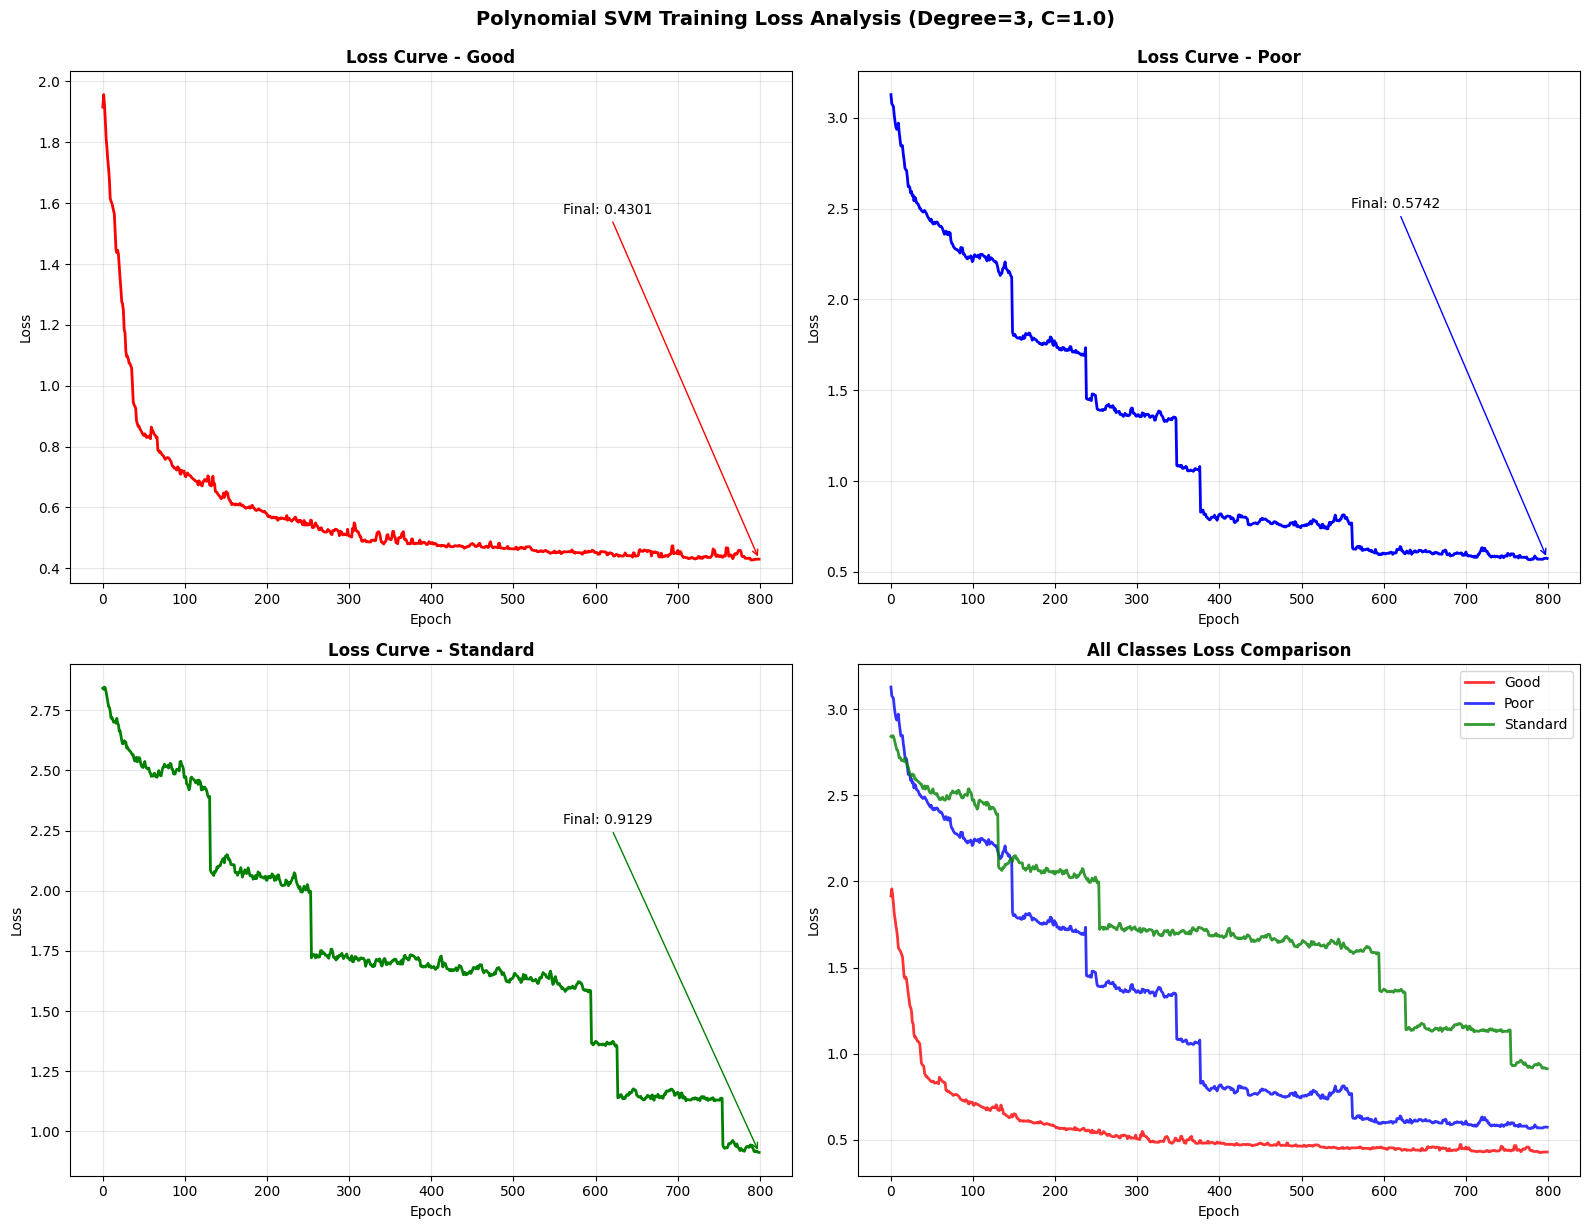

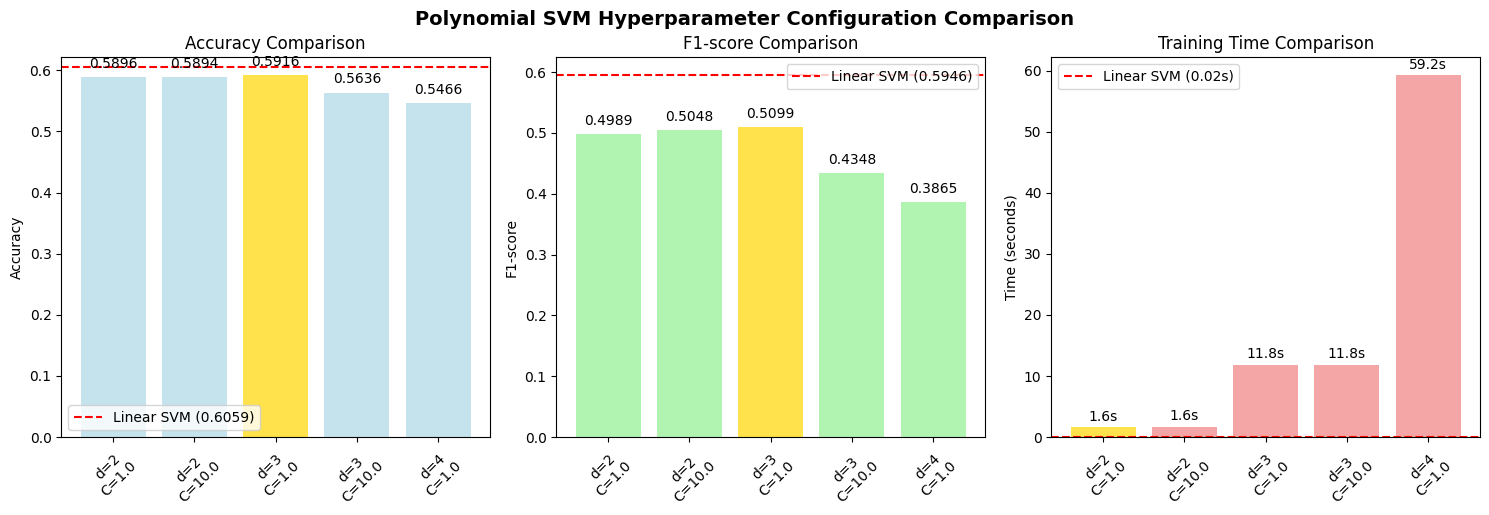


FEATURE IMPORTANCE ANALYSIS
Top 10 most important features (from Linear SVM):
                 feature  importance
11            Credit_Mix    0.305116
12      Outstanding_Debt    0.165144
7    Delay_from_due_date    0.151129
9   Changed_Credit_Limit    0.102541
14    Credit_History_Age    0.090244
17     Payment_Behaviour    0.029437
1          Annual_Income    0.018401
16       Monthly_Balance    0.012886
0                    Age    0.009540
10  Num_Credit_Inquiries    0.007192


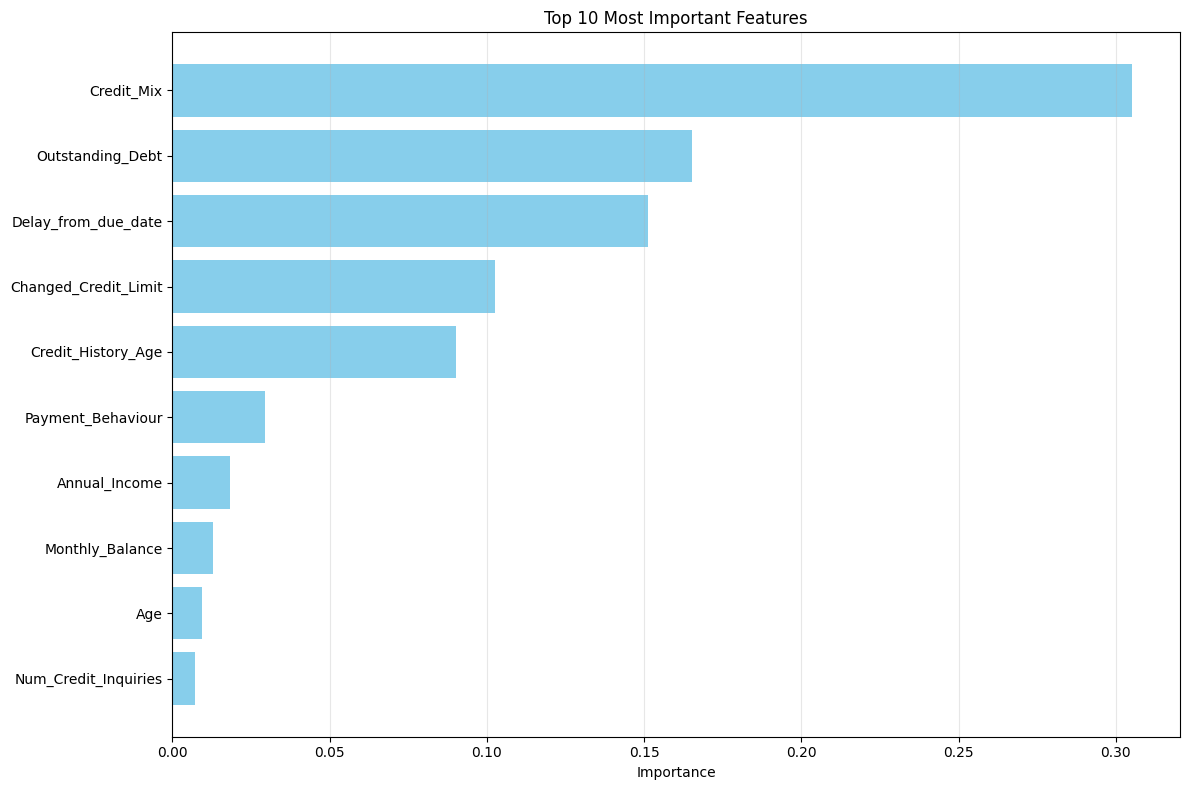


COMPLEXITY ANALYSIS
Original feature dimension: 18
Polynomial feature dimension (degree 3): 1329
Expansion factor: 73.8x
Expected time complexity increase: ~73.8x compared to linear SVM


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import classification_report, accuracy_score, log_loss, f1_score
import time

class PolynomialSGDSVM:
    def __init__(self, degree=2, C=1.0, learning_rate=0.01, n_iters=1000,
                 gamma=1.0, coef0=1.0, random_state=None):
        self.degree = degree
        self.C = C
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.gamma = gamma
        self.coef0 = coef0
        self.random_state = random_state
        self.models = {}
        self.loss_history = {}
        self.training_times = {}

    def _get_polynomial_features(self, X):
        """生成多项式特征"""
        if not hasattr(self, 'poly_'):
            self.poly_ = PolynomialFeatures(
                degree=self.degree,
                include_bias=False,
                interaction_only=False
            )
            Z = self.poly_.fit_transform(X)

            # 应用多项式核参数 (γx·z + r)^d
            # 这里我们简化处理，主要关注多项式扩展
            if self.gamma != 1.0:
                # 对交互项应用gamma缩放
                feature_degrees = self.poly_.powers_.sum(axis=1)
                scaling_factors = self.gamma ** feature_degrees
                Z = Z * scaling_factors

            if self.coef0 != 0:
                # 添加偏置项
                Z = np.hstack([Z, np.full((Z.shape[0], 1), np.sqrt(self.coef0))])

            return Z
        else:
            Z = self.poly_.transform(X)

            if self.gamma != 1.0:
                feature_degrees = self.poly_.powers_.sum(axis=1)
                scaling_factors = self.gamma ** feature_degrees
                Z = Z * scaling_factors

            if self.coef0 != 0:
                Z = np.hstack([Z, np.full((Z.shape[0], 1), np.sqrt(self.coef0))])

            return Z

    def compute_loss(self, Z, y, w, b):
        """计算SVM损失"""
        margins = y * (np.dot(Z, w) + b)
        hinge_loss = np.maximum(0, 1 - margins)
        reg_term = 0.5 * np.dot(w, w)
        total_loss = reg_term + self.C * np.mean(hinge_loss)
        return total_loss

    def fit_binary_classifier(self, Z, y_binary, class_label):
        """训练二分类器"""
        n_samples, n_features = Z.shape

        # 初始化参数
        rng = np.random.RandomState(self.random_state)
        w = rng.normal(0, 0.01, n_features)
        b = 0.0

        losses = []
        best_loss = float('inf')
        best_w, best_b = w.copy(), b

        print(f"Training polynomial classifier for class {class_label}...")
        print(f"Polynomial feature dimension: {n_features}")

        start_time = time.time()

        for epoch in range(self.n_iters):
            total_loss = 0
            count = 0

            # 学习率衰减
            current_lr = self.learning_rate / (1 + 0.001 * epoch)

            # Mini-batch SGD
            batch_size = min(32, n_samples)
            indices = np.random.choice(n_samples, batch_size, replace=False)

            Z_batch = Z[indices]
            y_batch = y_binary[indices]

            # 计算批量梯度
            predictions = np.dot(Z_batch, w) + b
            margins = y_batch * predictions

            # 计算hinge loss的指示函数
            misclassified = margins < 1
            hinge_grad = -y_batch * misclassified.astype(float)

            # 梯度计算
            w_grad = w + self.C * np.dot(hinge_grad, Z_batch) / batch_size
            b_grad = self.C * np.mean(hinge_grad)

            # 梯度裁剪
            grad_norm = np.linalg.norm(w_grad)
            if grad_norm > 1.0:
                w_grad = w_grad / grad_norm

            # 更新参数
            w = w - current_lr * w_grad
            b = b - current_lr * b_grad

            # 计算损失
            current_loss = self.compute_loss(Z, y_binary, w, b)
            losses.append(current_loss)

            # 保存最佳参数
            if current_loss < best_loss:
                best_loss = current_loss
                best_w, best_b = w.copy(), b

            if epoch % 200 == 0:
                # 计算当前准确率
                current_predictions = np.dot(Z, w) + b
                current_accuracy = np.mean((current_predictions * y_binary) > 0)
                print(f"  Epoch {epoch}: Loss = {current_loss:.4f}, Acc = {current_accuracy:.4f}, LR = {current_lr:.6f}")

        training_time = time.time() - start_time
        self.training_times[class_label] = training_time
        self.loss_history[class_label] = losses

        # 计算最终准确率
        final_predictions = np.dot(Z, best_w) + best_b
        final_accuracy = np.mean((final_predictions * y_binary) > 0)

        print(f"  Class {class_label} completed: Time = {training_time:.2f}s, "
              f"Final Loss = {losses[-1]:.4f}, Accuracy = {final_accuracy:.4f}")

        return best_w, best_b

    def fit(self, X, y):
        """训练模型"""
        print(f"Generating polynomial features (degree={self.degree})...")
        start_time = time.time()
        Z = self._get_polynomial_features(X)
        feature_time = time.time() - start_time
        print(f"Polynomial feature generation time: {feature_time:.2f} seconds")

        self.classes_ = np.unique(y)

        print(f"Feature dimension: {X.shape[1]} -> {Z.shape[1]}")
        print(f"Class distribution: {np.bincount(y)}")

        total_training_start = time.time()

        for class_label in self.classes_:
            y_binary = np.where(y == class_label, 1, -1)
            w, b = self.fit_binary_classifier(Z, y_binary, class_label)
            self.models[class_label] = {'weights': w, 'bias': b}

        self.total_training_time = time.time() - total_training_start
        print(f"Total training time: {self.total_training_time:.2f} seconds")

    def predict_proba(self, X):
        """预测概率"""
        Z = self._get_polynomial_features(X)
        n_samples = Z.shape[0]
        n_classes = len(self.classes_)
        scores = np.zeros((n_samples, n_classes))

        for i, class_label in enumerate(self.classes_):
            model = self.models[class_label]
            scores[:, i] = np.dot(Z, model['weights']) + model['bias']

        # 使用softmax
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return probabilities

    def predict(self, X):
        """预测类别"""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

# 数据预处理
def load_and_preprocess_data():
    train_data = pd.read_csv('train_data_s.csv')
    test_data = pd.read_csv('test_data.csv')

    def convert_to_float(age_str):
        if isinstance(age_str, str):
            years, months = map(int, age_str.replace('Years and', '').replace('Months', '').split())
            return years + months / 12.0
        return age_str

    train_data['Credit_History_Age'] = train_data['Credit_History_Age'].apply(convert_to_float)
    test_data['Credit_History_Age'] = test_data['Credit_History_Age'].apply(convert_to_float)

    credit_mix_mapping = {'Good': 2, 'Standard': 1, 'Bad': 0}
    train_data['Credit_Mix'] = train_data['Credit_Mix'].map(credit_mix_mapping)
    test_data['Credit_Mix'] = test_data['Credit_Mix'].map(credit_mix_mapping)

    unique_behaviors = train_data['Payment_Behaviour'].unique()
    behavior_mapping = {behavior: idx for idx, behavior in enumerate(unique_behaviors)}
    train_data['Payment_Behaviour'] = train_data['Payment_Behaviour'].map(behavior_mapping)
    test_data['Payment_Behaviour'] = test_data['Payment_Behaviour'].map(behavior_mapping)

    train_data = train_data.dropna()
    test_data = test_data.dropna()

    features = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
                'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
                'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

    X_train = train_data[features]
    y_train = train_data['Credit_Score']
    X_test = test_data[features]
    y_test = test_data['Credit_Score']

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, le

# 加载数据
X_train, X_test, y_train, y_test, label_encoder = load_and_preprocess_data()

print("=" * 70)
print("POLYNOMIAL KERNEL SVM WITH SGD")
print("=" * 70)
print(f"Training: {X_train.shape}, Test: {X_test.shape}")
print(f"Class distribution: {np.bincount(y_train)}")

# 首先尝试线性SVM作为基准
from sklearn.svm import LinearSVC

print("\n" + "=" * 50)
print("BASELINE: LINEAR SVM")
print("=" * 50)

linear_start_time = time.time()
linear_svm = LinearSVC(C=1.0, random_state=42)
linear_svm.fit(X_train, y_train)
linear_training_time = time.time() - linear_start_time

y_pred_linear = linear_svm.predict(X_test)
linear_accuracy = accuracy_score(y_test, y_pred_linear)
linear_f1 = f1_score(y_test, y_pred_linear, average='weighted')

print(f"Linear SVM Accuracy: {linear_accuracy:.4f}")
print(f"Linear SVM F1-score: {linear_f1:.4f}")
print(f"Linear SVM Training Time: {linear_training_time:.2f} seconds")

# 多项式SVM参数搜索
print("\n" + "=" * 50)
print("POLYNOMIAL SVM HYPERPARAMETER SEARCH")
print("=" * 50)

configs = [
    {'degree': 2, 'C': 1.0, 'lr': 0.01, 'gamma': 1.0, 'coef0': 1.0},
    {'degree': 2, 'C': 10.0, 'lr': 0.005, 'gamma': 1.0, 'coef0': 1.0},
    {'degree': 3, 'C': 1.0, 'lr': 0.005, 'gamma': 1.0, 'coef0': 1.0},
    {'degree': 3, 'C': 10.0, 'lr': 0.001, 'gamma': 1.0, 'coef0': 1.0},
    {'degree': 4, 'C': 1.0, 'lr': 0.001, 'gamma': 0.1, 'coef0': 1.0},
]

best_accuracy = 0
best_f1 = 0
best_model = None
best_config = None
all_results = []

for i, config in enumerate(configs):
    print(f"\n--- Config {i+1}: degree={config['degree']}, C={config['C']} ---")

    try:
        model = PolynomialSGDSVM(
            degree=config['degree'],
            C=config['C'],
            learning_rate=config['lr'],
            n_iters=800,  # 减少迭代次数，因为多项式特征维度可能很高
            gamma=config['gamma'],
            coef0=config['coef0'],
            random_state=42
        )

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"Polynomial SVM Accuracy: {accuracy:.4f}")
        print(f"Polynomial SVM F1-score: {f1:.4f}")
        print(f"Polynomial SVM Training Time: {model.total_training_time:.2f} seconds")

        # 保存结果
        result = {
            'config': config,
            'accuracy': accuracy,
            'f1_score': f1,
            'training_time': model.total_training_time,
            'model': model
        }
        all_results.append(result)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_f1 = f1
            best_model = model
            best_config = config

    except Exception as e:
        print(f"Training failed: {e}")

# 评估最佳模型
if best_model:
    print(f"\n" + "=" * 70)
    print("BEST POLYNOMIAL SVM MODEL PERFORMANCE")
    print("=" * 70)

    print(f"Best Configuration:")
    print(f"  Degree: {best_config['degree']}")
    print(f"  C: {best_config['C']}")
    print(f"  Gamma: {best_config['gamma']}")
    print(f"  Coef0: {best_config['coef0']}")
    print(f"  Learning Rate: {best_config['lr']}")

    print(f"\nPerformance Metrics:")
    print(f"  Accuracy: {best_accuracy:.4f}")
    print(f"  F1-score: {best_f1:.4f}")
    print(f"  Training Time: {best_model.total_training_time:.2f} seconds")

    print(f"\nComparison with Linear SVM:")
    print(f"  Accuracy Improvement: {best_accuracy - linear_accuracy:+.4f}")
    print(f"  F1-score Improvement: {best_f1 - linear_f1:+.4f}")
    print(f"  Training Time Difference: {best_model.total_training_time - linear_training_time:+.2f} seconds")

    y_pred_best = best_model.predict(X_test)
    y_proba_best = best_model.predict_proba(X_test)

    print(f"\nDetailed Metrics:")
    print(f"  Log Loss: {log_loss(y_test, y_proba_best):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

    # 绘制详细的损失曲线图
    plt.figure(figsize=(16, 12))

    # 1. 每个类别的损失曲线
    colors = ['red', 'blue', 'green']
    for idx, class_label in enumerate(best_model.classes_):
        plt.subplot(2, 2, idx + 1)
        losses = best_model.loss_history[class_label]
        plt.plot(losses, color=colors[idx], linewidth=2)
        plt.title(f'Loss Curve - {label_encoder.classes_[class_label]}', fontsize=12, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)

        # 添加最终损失值标注
        final_loss = losses[-1]
        plt.annotate(f'Final: {final_loss:.4f}',
                    xy=(len(losses)-1, final_loss),
                    xytext=(len(losses)*0.7, max(losses)*0.8),
                    arrowprops=dict(arrowstyle='->', color=colors[idx]))

    # 2. 所有类别损失对比
    plt.subplot(2, 2, 4)
    for idx, class_label in enumerate(best_model.classes_):
        losses = best_model.loss_history[class_label]
        plt.plot(losses, label=label_encoder.classes_[class_label],
                color=colors[idx], linewidth=2, alpha=0.8)

    plt.title('All Classes Loss Comparison', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle(f'Polynomial SVM Training Loss Analysis (Degree={best_config["degree"]}, C={best_config["C"]})',
                fontsize=14, fontweight='bold', y=1.02)
    plt.show()

    # 绘制配置比较图
    if len(all_results) > 1:
        plt.figure(figsize=(15, 5))

        # 准确率比较
        plt.subplot(1, 3, 1)
        config_names = [f"d={r['config']['degree']}\nC={r['config']['C']}" for r in all_results]
        accuracies = [r['accuracy'] for r in all_results]
        colors = ['lightblue' if i != np.argmax(accuracies) else 'gold' for i in range(len(accuracies))]

        bars = plt.bar(config_names, accuracies, color=colors, alpha=0.7)
        plt.axhline(y=linear_accuracy, color='red', linestyle='--', label=f'Linear SVM ({linear_accuracy:.4f})')
        plt.title('Accuracy Comparison')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, acc in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.4f}', ha='center', va='bottom')

        # F1-score比较
        plt.subplot(1, 3, 2)
        f1_scores = [r['f1_score'] for r in all_results]
        colors = ['lightgreen' if i != np.argmax(f1_scores) else 'gold' for i in range(len(f1_scores))]

        bars = plt.bar(config_names, f1_scores, color=colors, alpha=0.7)
        plt.axhline(y=linear_f1, color='red', linestyle='--', label=f'Linear SVM ({linear_f1:.4f})')
        plt.title('F1-score Comparison')
        plt.ylabel('F1-score')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, f1 in zip(bars, f1_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{f1:.4f}', ha='center', va='bottom')

        # 训练时间比较
        plt.subplot(1, 3, 3)
        training_times = [r['training_time'] for r in all_results]
        colors = ['lightcoral' if i != np.argmin(training_times) else 'gold' for i in range(len(training_times))]

        bars = plt.bar(config_names, training_times, color=colors, alpha=0.7)
        plt.axhline(y=linear_training_time, color='red', linestyle='--',
                   label=f'Linear SVM ({linear_training_time:.2f}s)')
        plt.title('Training Time Comparison')
        plt.ylabel('Time (seconds)')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, time_val in zip(bars, training_times):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(training_times)*0.01,
                    f'{time_val:.1f}s', ha='center', va='bottom')

        plt.tight_layout()
        plt.suptitle('Polynomial SVM Hyperparameter Configuration Comparison', fontsize=14, fontweight='bold', y=1.02)
        plt.show()

else:
    print(f"\nPolynomial SVM did not improve over linear SVM.")
    print(f"Linear SVM - Accuracy: {linear_accuracy:.4f}, F1: {linear_f1:.4f}")
    print(f"Best Polynomial SVM - Accuracy: {best_accuracy:.4f}, F1: {best_f1:.4f}")

# 特征重要性分析
print("\n" + "=" * 50)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

feature_names = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
                'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
                'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

if hasattr(linear_svm, 'coef_'):
    importance = np.mean(np.abs(linear_svm.coef_), axis=0)
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

    print("Top 10 most important features (from Linear SVM):")
    print(feature_imp.head(10))

    # 绘制特征重要性图
    plt.figure(figsize=(12, 8))
    top_features = feature_imp.head(10)
    plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Top 10 Most Important Features')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

# 复杂度分析
print("\n" + "=" * 50)
print("COMPLEXITY ANALYSIS")
print("=" * 50)

original_dim = X_train.shape[1]
if best_model and hasattr(best_model, 'poly_'):
    poly_dim = best_model.poly_.n_output_features_
    print(f"Original feature dimension: {original_dim}")
    print(f"Polynomial feature dimension (degree {best_config['degree']}): {poly_dim}")
    print(f"Expansion factor: {poly_dim/original_dim:.1f}x")
    print(f"Expected time complexity increase: ~{poly_dim/original_dim:.1f}x compared to linear SVM")

DATA LOADING COMPLETED
Training set shape: (4782, 18)
Test set shape: (6939, 18)
Class distribution: [ 877 1290 2615]
Classes: ['Good' 'Poor' 'Standard']

BASELINE: LINEAR SVM
Linear SVM Accuracy: 0.6059
Linear SVM F1-score: 0.5946
Linear SVM Training Time: 0.02 seconds

POLYNOMIAL SVM HYPERPARAMETER SEARCH

--- Config 1: degree=2, C=1.0 ---
Generating polynomial features (degree=2)...
Polynomial feature generation time: 0.01 seconds
Feature dimension: 18 -> 190
Class distribution: [ 877 1290 2615]
Training polynomial classifier for class 0...
Polynomial feature dimension: 190
  Epoch 0: Loss = 0.9962, Acc = 0.5473, LR = 0.010000
  Epoch 200: Loss = 0.4357, Acc = 0.8139, LR = 0.008333
  Epoch 400: Loss = 0.3983, Acc = 0.8164, LR = 0.007143
  Class 0 completed: Time = 0.35s, Final Loss = 0.3913, Accuracy = 0.8168
Training polynomial classifier for class 1...
Polynomial feature dimension: 190
  Epoch 0: Loss = 1.0053, Acc = 0.5648, LR = 0.010000
  Epoch 200: Loss = 0.5896, Acc = 0.7323, 

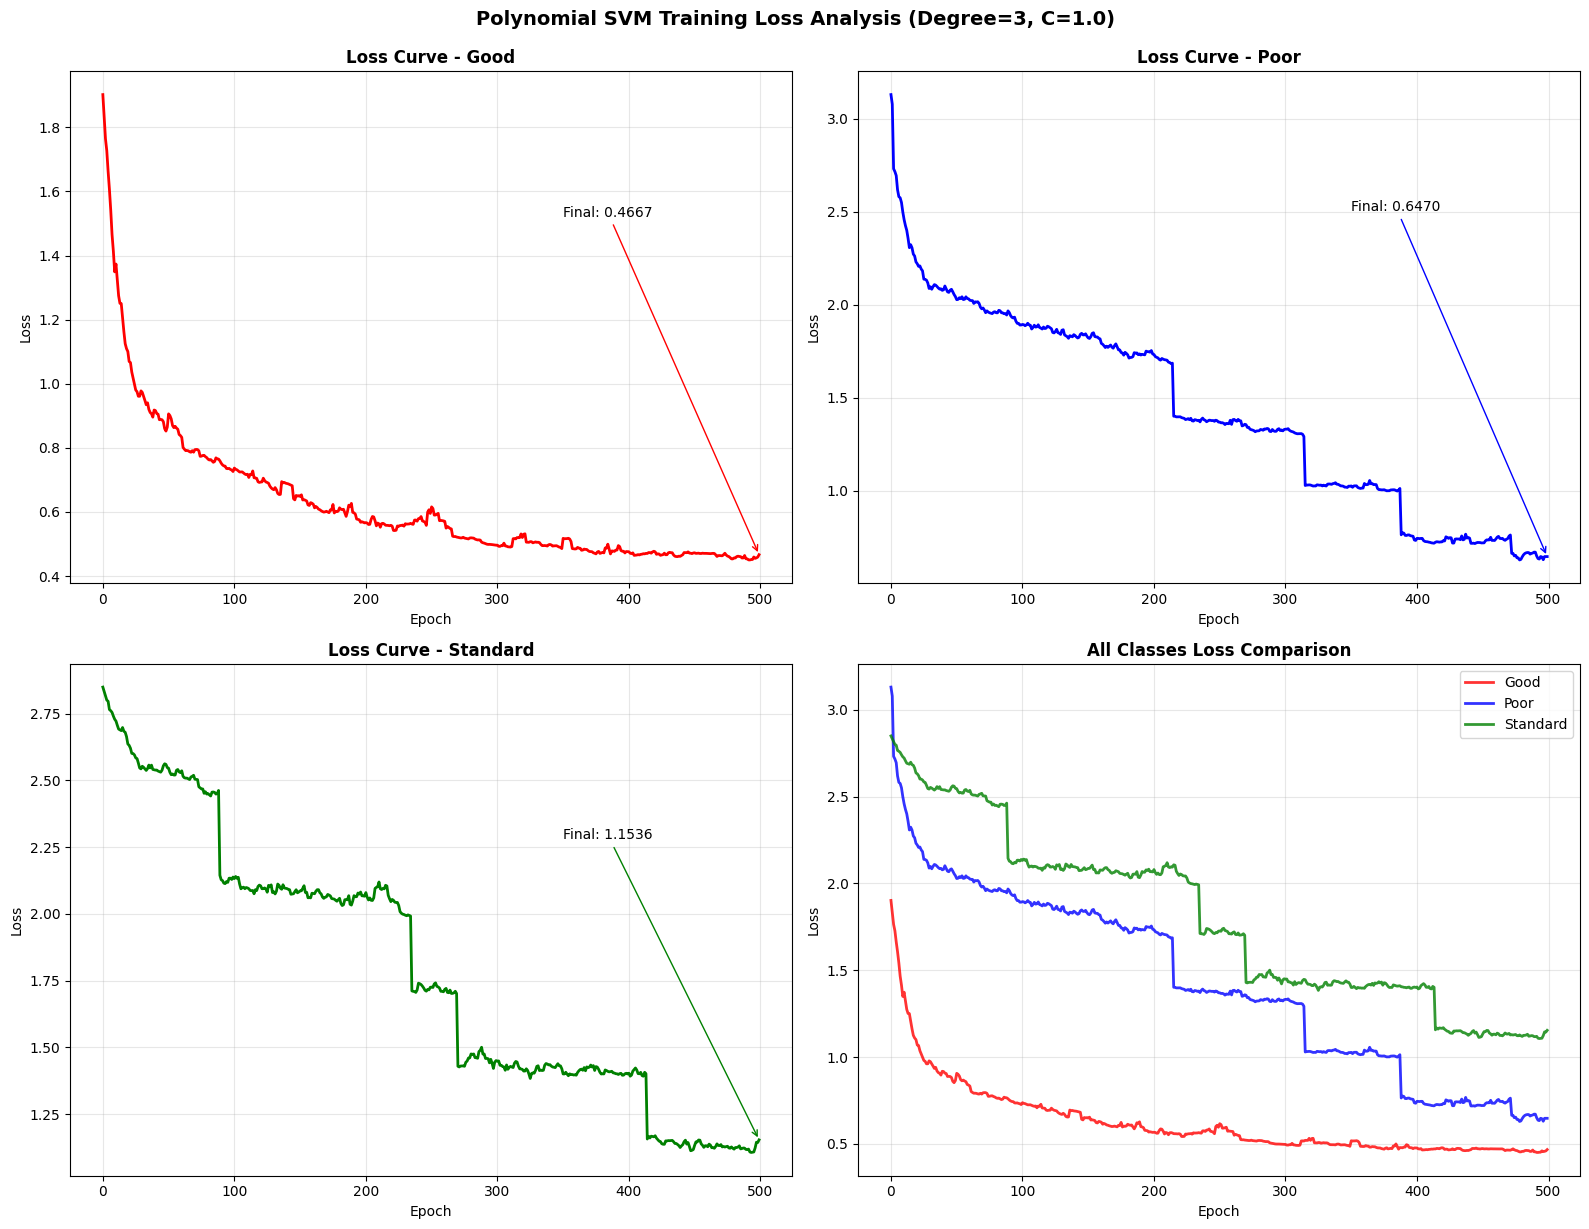

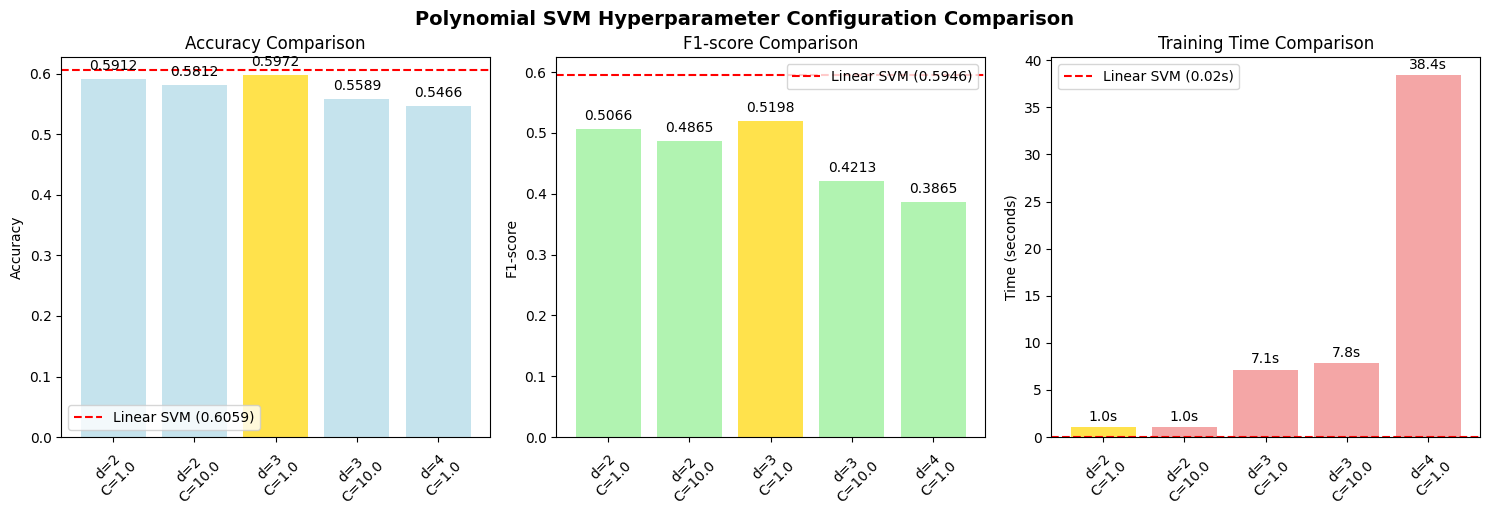


FEATURE IMPORTANCE ANALYSIS
Top 10 most important features (from Linear SVM):
                 feature  importance
11            Credit_Mix    0.305116
12      Outstanding_Debt    0.165144
7    Delay_from_due_date    0.151129
9   Changed_Credit_Limit    0.102541
14    Credit_History_Age    0.090244
17     Payment_Behaviour    0.029437
1          Annual_Income    0.018401
16       Monthly_Balance    0.012886
0                    Age    0.009540
10  Num_Credit_Inquiries    0.007192


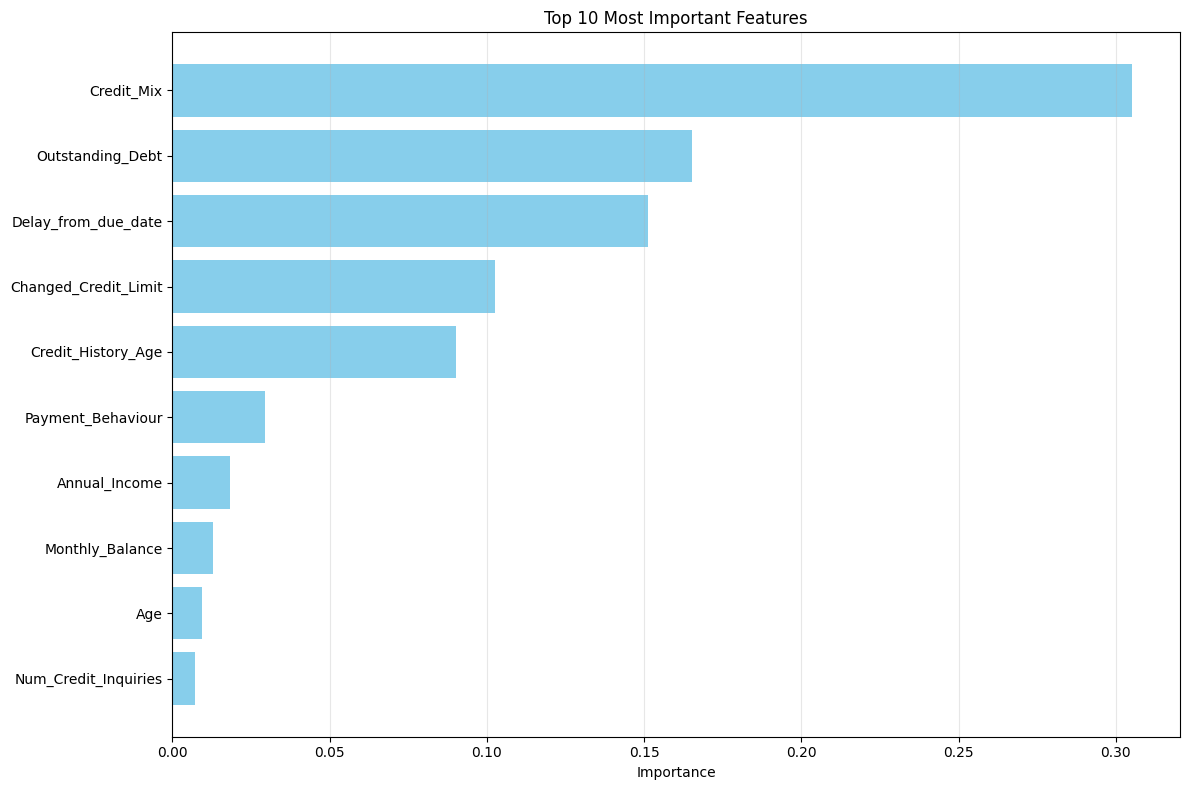


COMPLEXITY ANALYSIS
Original feature dimension: 18
Polynomial feature dimension (degree 3): 1329
Expansion factor: 73.8x
Expected time complexity increase: ~73.8x compared to linear SVM


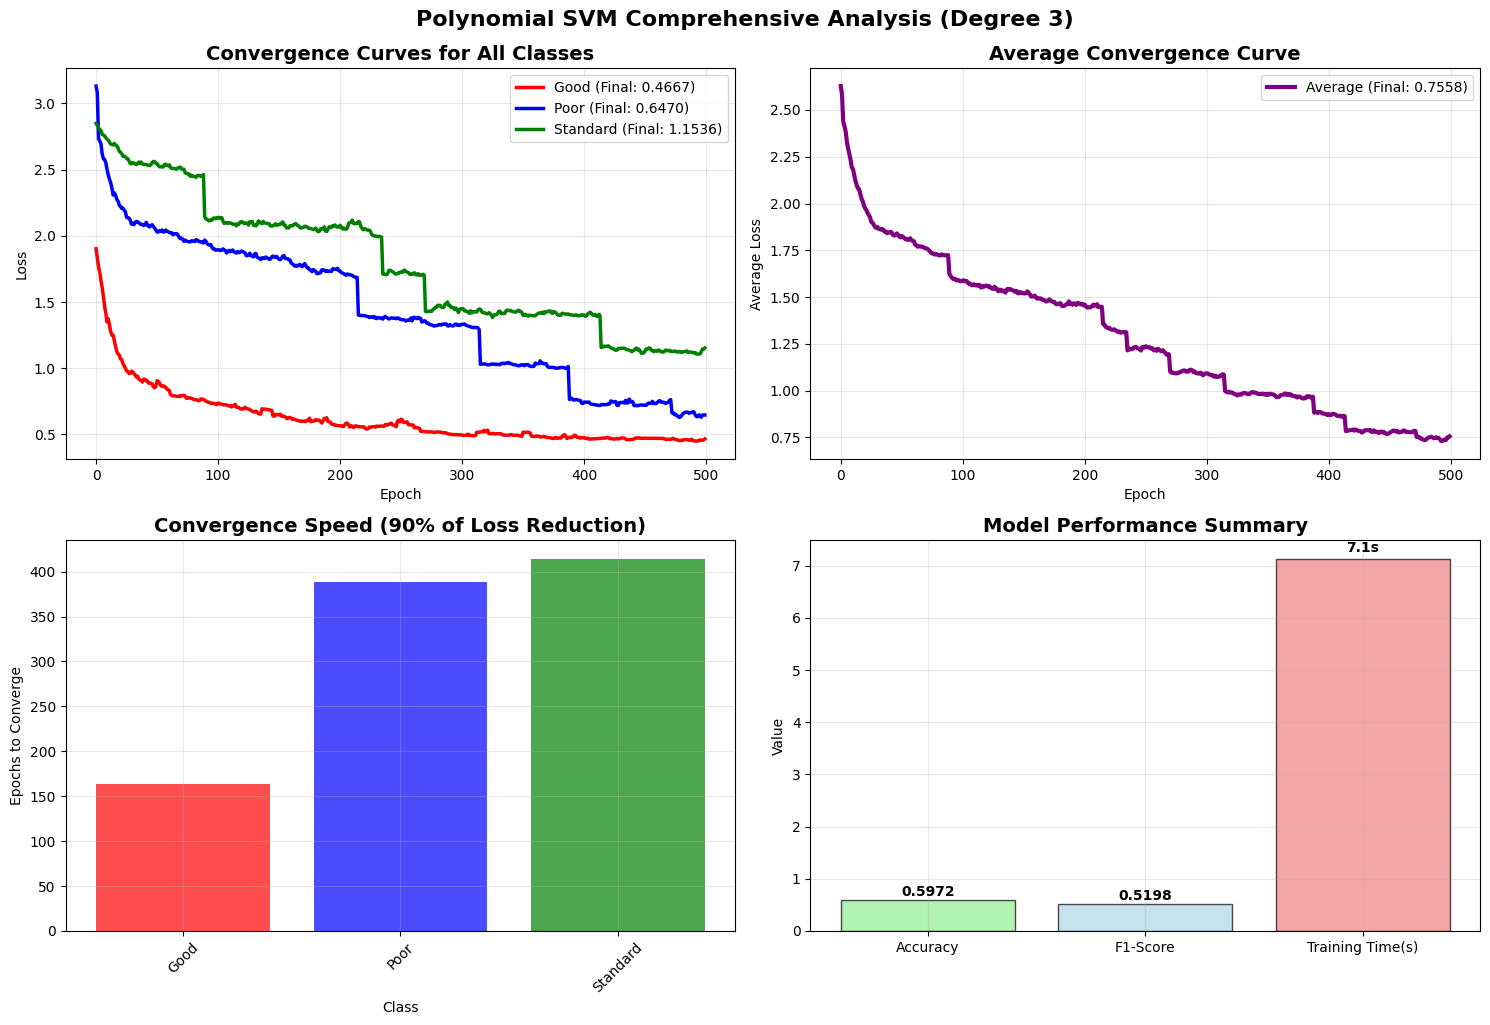


ANALYSIS COMPLETED


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import classification_report, accuracy_score, log_loss, f1_score
import time

# 数据预处理
def load_and_preprocess_data():
    # 这里使用示例数据路径，请根据您的实际文件路径修改
    train_data = pd.read_csv('train_data_s.csv')
    test_data = pd.read_csv('test_data.csv')

    def convert_to_float(age_str):
        if isinstance(age_str, str):
            years, months = map(int, age_str.replace('Years and', '').replace('Months', '').split())
            return years + months / 12.0
        return age_str

    train_data['Credit_History_Age'] = train_data['Credit_History_Age'].apply(convert_to_float)
    test_data['Credit_History_Age'] = test_data['Credit_History_Age'].apply(convert_to_float)

    credit_mix_mapping = {'Good': 2, 'Standard': 1, 'Bad': 0}
    train_data['Credit_Mix'] = train_data['Credit_Mix'].map(credit_mix_mapping)
    test_data['Credit_Mix'] = test_data['Credit_Mix'].map(credit_mix_mapping)

    unique_behaviors = train_data['Payment_Behaviour'].unique()
    behavior_mapping = {behavior: idx for idx, behavior in enumerate(unique_behaviors)}
    train_data['Payment_Behaviour'] = train_data['Payment_Behaviour'].map(behavior_mapping)
    test_data['Payment_Behaviour'] = test_data['Payment_Behaviour'].map(behavior_mapping)

    train_data = train_data.dropna()
    test_data = test_data.dropna()

    features = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
                'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
                'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

    X_train = train_data[features]
    y_train = train_data['Credit_Score']
    X_test = test_data[features]
    y_test = test_data['Credit_Score']

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, le

# 加载数据
X_train, X_test, y_train, y_test, label_encoder = load_and_preprocess_data()

print("=" * 70)
print("DATA LOADING COMPLETED")
print("=" * 70)
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Class distribution: {np.bincount(y_train)}")
print(f"Classes: {label_encoder.classes_}")

class PolynomialSGDSVM:
    def __init__(self, degree=2, C=1.0, learning_rate=0.01, n_iters=1000,
                 gamma=1.0, coef0=1.0, random_state=None):
        self.degree = degree
        self.C = C
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.gamma = gamma
        self.coef0 = coef0
        self.random_state = random_state
        self.models = {}
        self.loss_history = {}
        self.training_times = {}

    def _get_polynomial_features(self, X):
        """生成多项式特征"""
        if not hasattr(self, 'poly_'):
            self.poly_ = PolynomialFeatures(
                degree=self.degree,
                include_bias=False,
                interaction_only=False
            )
            Z = self.poly_.fit_transform(X)

            # 应用多项式核参数 (γx·z + r)^d
            # 这里我们简化处理，主要关注多项式扩展
            if self.gamma != 1.0:
                # 对交互项应用gamma缩放
                feature_degrees = self.poly_.powers_.sum(axis=1)
                scaling_factors = self.gamma ** feature_degrees
                Z = Z * scaling_factors

            if self.coef0 != 0:
                # 添加偏置项
                Z = np.hstack([Z, np.full((Z.shape[0], 1), np.sqrt(self.coef0))])

            return Z
        else:
            Z = self.poly_.transform(X)

            if self.gamma != 1.0:
                feature_degrees = self.poly_.powers_.sum(axis=1)
                scaling_factors = self.gamma ** feature_degrees
                Z = Z * scaling_factors

            if self.coef0 != 0:
                Z = np.hstack([Z, np.full((Z.shape[0], 1), np.sqrt(self.coef0))])

            return Z

    def compute_loss(self, Z, y, w, b):
        """计算SVM损失"""
        margins = y * (np.dot(Z, w) + b)
        hinge_loss = np.maximum(0, 1 - margins)
        reg_term = 0.5 * np.dot(w, w)
        total_loss = reg_term + self.C * np.mean(hinge_loss)
        return total_loss

    def fit_binary_classifier(self, Z, y_binary, class_label):
        """训练二分类器"""
        n_samples, n_features = Z.shape

        # 初始化参数
        rng = np.random.RandomState(self.random_state)
        w = rng.normal(0, 0.01, n_features)
        b = 0.0

        losses = []
        best_loss = float('inf')
        best_w, best_b = w.copy(), b

        print(f"Training polynomial classifier for class {class_label}...")
        print(f"Polynomial feature dimension: {n_features}")

        start_time = time.time()

        for epoch in range(self.n_iters):
            total_loss = 0
            count = 0

            # 学习率衰减
            current_lr = self.learning_rate / (1 + 0.001 * epoch)

            # Mini-batch SGD
            batch_size = min(32, n_samples)
            indices = np.random.choice(n_samples, batch_size, replace=False)

            Z_batch = Z[indices]
            y_batch = y_binary[indices]

            # 计算批量梯度
            predictions = np.dot(Z_batch, w) + b
            margins = y_batch * predictions

            # 计算hinge loss的指示函数
            misclassified = margins < 1
            hinge_grad = -y_batch * misclassified.astype(float)

            # 梯度计算
            w_grad = w + self.C * np.dot(hinge_grad, Z_batch) / batch_size
            b_grad = self.C * np.mean(hinge_grad)

            # 梯度裁剪
            grad_norm = np.linalg.norm(w_grad)
            if grad_norm > 1.0:
                w_grad = w_grad / grad_norm

            # 更新参数
            w = w - current_lr * w_grad
            b = b - current_lr * b_grad

            # 计算损失
            current_loss = self.compute_loss(Z, y_binary, w, b)
            losses.append(current_loss)

            # 保存最佳参数
            if current_loss < best_loss:
                best_loss = current_loss
                best_w, best_b = w.copy(), b

            if epoch % 200 == 0:
                # 计算当前准确率
                current_predictions = np.dot(Z, w) + b
                current_accuracy = np.mean((current_predictions * y_binary) > 0)
                print(f"  Epoch {epoch}: Loss = {current_loss:.4f}, Acc = {current_accuracy:.4f}, LR = {current_lr:.6f}")

        training_time = time.time() - start_time
        self.training_times[class_label] = training_time
        self.loss_history[class_label] = losses

        # 计算最终准确率
        final_predictions = np.dot(Z, best_w) + best_b
        final_accuracy = np.mean((final_predictions * y_binary) > 0)

        print(f"  Class {class_label} completed: Time = {training_time:.2f}s, "
              f"Final Loss = {losses[-1]:.4f}, Accuracy = {final_accuracy:.4f}")

        return best_w, best_b

    def fit(self, X, y):
        """训练模型"""
        print(f"Generating polynomial features (degree={self.degree})...")
        start_time = time.time()
        Z = self._get_polynomial_features(X)
        feature_time = time.time() - start_time
        print(f"Polynomial feature generation time: {feature_time:.2f} seconds")

        self.classes_ = np.unique(y)

        print(f"Feature dimension: {X.shape[1]} -> {Z.shape[1]}")
        print(f"Class distribution: {np.bincount(y)}")

        total_training_start = time.time()

        for class_label in self.classes_:
            y_binary = np.where(y == class_label, 1, -1)
            w, b = self.fit_binary_classifier(Z, y_binary, class_label)
            self.models[class_label] = {'weights': w, 'bias': b}

        self.total_training_time = time.time() - total_training_start
        print(f"Total training time: {self.total_training_time:.2f} seconds")

    def predict_proba(self, X):
        """预测概率"""
        Z = self._get_polynomial_features(X)
        n_samples = Z.shape[0]
        n_classes = len(self.classes_)
        scores = np.zeros((n_samples, n_classes))

        for i, class_label in enumerate(self.classes_):
            model = self.models[class_label]
            scores[:, i] = np.dot(Z, model['weights']) + model['bias']

        # 使用softmax
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return probabilities

    def predict(self, X):
        """预测类别"""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

# 首先尝试线性SVM作为基准
from sklearn.svm import LinearSVC

print("\n" + "=" * 50)
print("BASELINE: LINEAR SVM")
print("=" * 50)

linear_start_time = time.time()
linear_svm = LinearSVC(C=1.0, random_state=42)
linear_svm.fit(X_train, y_train)
linear_training_time = time.time() - linear_start_time

y_pred_linear = linear_svm.predict(X_test)
linear_accuracy = accuracy_score(y_test, y_pred_linear)
linear_f1 = f1_score(y_test, y_pred_linear, average='weighted')

print(f"Linear SVM Accuracy: {linear_accuracy:.4f}")
print(f"Linear SVM F1-score: {linear_f1:.4f}")
print(f"Linear SVM Training Time: {linear_training_time:.2f} seconds")

# 多项式SVM参数搜索
print("\n" + "=" * 50)
print("POLYNOMIAL SVM HYPERPARAMETER SEARCH")
print("=" * 50)

configs = [
    {'degree': 2, 'C': 1.0, 'lr': 0.01, 'gamma': 1.0, 'coef0': 1.0},
    {'degree': 2, 'C': 10.0, 'lr': 0.005, 'gamma': 1.0, 'coef0': 1.0},
    {'degree': 3, 'C': 1.0, 'lr': 0.005, 'gamma': 1.0, 'coef0': 1.0},
    {'degree': 3, 'C': 10.0, 'lr': 0.001, 'gamma': 1.0, 'coef0': 1.0},
    {'degree': 4, 'C': 1.0, 'lr': 0.001, 'gamma': 0.1, 'coef0': 1.0},
]

best_accuracy = 0
best_f1 = 0
best_model = None
best_config = None
all_results = []

for i, config in enumerate(configs):
    print(f"\n--- Config {i+1}: degree={config['degree']}, C={config['C']} ---")

    try:
        model = PolynomialSGDSVM(
            degree=config['degree'],
            C=config['C'],
            learning_rate=config['lr'],
            n_iters=500,
            gamma=config['gamma'],
            coef0=config['coef0'],
            random_state=42
        )

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"Polynomial SVM Accuracy: {accuracy:.4f}")
        print(f"Polynomial SVM F1-score: {f1:.4f}")
        print(f"Polynomial SVM Training Time: {model.total_training_time:.2f} seconds")

        # 保存结果
        result = {
            'config': config,
            'accuracy': accuracy,
            'f1_score': f1,
            'training_time': model.total_training_time,
            'model': model
        }
        all_results.append(result)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_f1 = f1
            best_model = model
            best_config = config

    except Exception as e:
        print(f"Training failed: {e}")

# 评估最佳模型
if best_model:
    print(f"\n" + "=" * 70)
    print("BEST POLYNOMIAL SVM MODEL PERFORMANCE")
    print("=" * 70)

    print(f"Best Configuration:")
    print(f"  Degree: {best_config['degree']}")
    print(f"  C: {best_config['C']}")
    print(f"  Gamma: {best_config['gamma']}")
    print(f"  Coef0: {best_config['coef0']}")
    print(f"  Learning Rate: {best_config['lr']}")

    print(f"\nPerformance Metrics:")
    print(f"  Accuracy: {best_accuracy:.4f}")
    print(f"  F1-score: {best_f1:.4f}")
    print(f"  Training Time: {best_model.total_training_time:.2f} seconds")

    print(f"\nComparison with Linear SVM:")
    print(f"  Accuracy Improvement: {best_accuracy - linear_accuracy:+.4f}")
    print(f"  F1-score Improvement: {best_f1 - linear_f1:+.4f}")
    print(f"  Training Time Difference: {best_model.total_training_time - linear_training_time:+.2f} seconds")

    y_pred_best = best_model.predict(X_test)
    y_proba_best = best_model.predict_proba(X_test)

    print(f"\nDetailed Metrics:")
    print(f"  Log Loss: {log_loss(y_test, y_proba_best):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

    # 绘制损失曲线图
    plt.figure(figsize=(16, 12))

    # 1. 每个类别的损失曲线
    colors = ['red', 'blue', 'green']
    for idx, class_label in enumerate(best_model.classes_):
        plt.subplot(2, 2, idx + 1)
        losses = best_model.loss_history[class_label]
        plt.plot(losses, color=colors[idx], linewidth=2)
        plt.title(f'Loss Curve - {label_encoder.classes_[class_label]}', fontsize=12, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)

        # 添加最终损失值标注
        final_loss = losses[-1]
        plt.annotate(f'Final: {final_loss:.4f}',
                    xy=(len(losses)-1, final_loss),
                    xytext=(len(losses)*0.7, max(losses)*0.8),
                    arrowprops=dict(arrowstyle='->', color=colors[idx]))

    # 2. 所有类别损失对比
    plt.subplot(2, 2, 4)
    for idx, class_label in enumerate(best_model.classes_):
        losses = best_model.loss_history[class_label]
        plt.plot(losses, label=label_encoder.classes_[class_label],
                color=colors[idx], linewidth=2, alpha=0.8)

    plt.title('All Classes Loss Comparison', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle(f'Polynomial SVM Training Loss Analysis (Degree={best_config["degree"]}, C={best_config["C"]})',
                fontsize=14, fontweight='bold', y=1.02)
    plt.show()

    # 绘制配置比较图
    if len(all_results) > 1:
        plt.figure(figsize=(15, 5))

        # 准确率比较
        plt.subplot(1, 3, 1)
        config_names = [f"d={r['config']['degree']}\nC={r['config']['C']}" for r in all_results]
        accuracies = [r['accuracy'] for r in all_results]
        colors = ['lightblue' if i != np.argmax(accuracies) else 'gold' for i in range(len(accuracies))]

        bars = plt.bar(config_names, accuracies, color=colors, alpha=0.7)
        plt.axhline(y=linear_accuracy, color='red', linestyle='--', label=f'Linear SVM ({linear_accuracy:.4f})')
        plt.title('Accuracy Comparison')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, acc in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.4f}', ha='center', va='bottom')

        # F1-score比较
        plt.subplot(1, 3, 2)
        f1_scores = [r['f1_score'] for r in all_results]
        colors = ['lightgreen' if i != np.argmax(f1_scores) else 'gold' for i in range(len(f1_scores))]

        bars = plt.bar(config_names, f1_scores, color=colors, alpha=0.7)
        plt.axhline(y=linear_f1, color='red', linestyle='--', label=f'Linear SVM ({linear_f1:.4f})')
        plt.title('F1-score Comparison')
        plt.ylabel('F1-score')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, f1 in zip(bars, f1_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{f1:.4f}', ha='center', va='bottom')

        # 训练时间比较
        plt.subplot(1, 3, 3)
        training_times = [r['training_time'] for r in all_results]
        colors = ['lightcoral' if i != np.argmin(training_times) else 'gold' for i in range(len(training_times))]

        bars = plt.bar(config_names, training_times, color=colors, alpha=0.7)
        plt.axhline(y=linear_training_time, color='red', linestyle='--',
                   label=f'Linear SVM ({linear_training_time:.2f}s)')
        plt.title('Training Time Comparison')
        plt.ylabel('Time (seconds)')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, time_val in zip(bars, training_times):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(training_times)*0.01,
                    f'{time_val:.1f}s', ha='center', va='bottom')

        plt.tight_layout()
        plt.suptitle('Polynomial SVM Hyperparameter Configuration Comparison', fontsize=14, fontweight='bold', y=1.02)
        plt.show()

else:
    print(f"\nNo successful polynomial SVM training.")
    print(f"Linear SVM - Accuracy: {linear_accuracy:.4f}, F1: {linear_f1:.4f}")

# 特征重要性分析
print("\n" + "=" * 50)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

feature_names = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
                'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
                'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

if hasattr(linear_svm, 'coef_'):
    importance = np.mean(np.abs(linear_svm.coef_), axis=0)
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

    print("Top 10 most important features (from Linear SVM):")
    print(feature_imp.head(10))

    # 绘制特征重要性图
    plt.figure(figsize=(12, 8))
    top_features = feature_imp.head(10)
    plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Top 10 Most Important Features')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

# 复杂度分析
print("\n" + "=" * 50)
print("COMPLEXITY ANALYSIS")
print("=" * 50)

original_dim = X_train.shape[1]
if best_model and hasattr(best_model, 'poly_'):
    poly_dim = best_model.poly_.n_output_features_
    print(f"Original feature dimension: {original_dim}")
    print(f"Polynomial feature dimension (degree {best_config['degree']}): {poly_dim}")
    print(f"Expansion factor: {poly_dim/original_dim:.1f}x")
    print(f"Expected time complexity increase: ~{poly_dim/original_dim:.1f}x compared to linear SVM")

# 绘制收敛分析图
if best_model:
    plt.figure(figsize=(15, 10))

    # 1. 主要收敛曲线
    plt.subplot(2, 2, 1)
    colors = ['red', 'blue', 'green']
    for idx, class_label in enumerate(best_model.classes_):
        losses = best_model.loss_history[class_label]
        plt.plot(losses, color=colors[idx], linewidth=2.5,
                label=f'{label_encoder.classes_[class_label]} (Final: {losses[-1]:.4f})')

    plt.title('Convergence Curves for All Classes', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. 平均收敛曲线
    plt.subplot(2, 2, 2)
    # 计算平均损失
    min_epochs = min(len(losses) for losses in best_model.loss_history.values())
    avg_losses = []
    for epoch in range(min_epochs):
        epoch_loss = np.mean([losses[epoch] for losses in best_model.loss_history.values()])
        avg_losses.append(epoch_loss)

    plt.plot(avg_losses, color='purple', linewidth=3, label=f'Average (Final: {avg_losses[-1]:.4f})')
    plt.title('Average Convergence Curve', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. 收敛速度分析
    plt.subplot(2, 2, 3)
    convergence_epochs = []
    class_names = []

    for class_idx, class_label in enumerate(best_model.classes_):
        losses = best_model.loss_history[class_label]
        initial_loss = losses[0]
        final_loss = losses[-1]
        target_loss = final_loss + 0.1 * (initial_loss - final_loss)  # 90%收敛

        # 找到达到目标损失的epoch
        conv_epoch = next((i for i, loss in enumerate(losses) if loss <= target_loss), len(losses))
        convergence_epochs.append(conv_epoch)
        class_names.append(label_encoder.classes_[class_idx])

    plt.bar(class_names, convergence_epochs, color=colors[:len(class_names)], alpha=0.7)
    plt.title('Convergence Speed (90% of Loss Reduction)', fontsize=14, fontweight='bold')
    plt.xlabel('Class')
    plt.ylabel('Epochs to Converge')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 4. 性能总结
    plt.subplot(2, 2, 4)
    metrics = ['Accuracy', 'F1-Score', 'Training Time(s)']
    values = [best_accuracy, best_f1, best_model.total_training_time]
    colors_bar = ['lightgreen', 'lightblue', 'lightcoral']

    bars = plt.bar(metrics, values, color=colors_bar, alpha=0.7, edgecolor='black')
    plt.title('Model Performance Summary', fontsize=14, fontweight='bold')
    plt.ylabel('Value')

    # 添加数值标注
    for bar, value in zip(bars, values):
        if bar.get_height() < 1:  # 对于准确率和F1分数
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
        else:  # 对于训练时间
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                    f'{value:.1f}s', ha='center', va='bottom', fontweight='bold')

    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle(f'Polynomial SVM Comprehensive Analysis (Degree {best_config["degree"]})',
                fontsize=16, fontweight='bold', y=1.02)
    plt.show()

print("\n" + "=" * 70)
print("ANALYSIS COMPLETED")
print("=" * 70)

DATA LOADING COMPLETED
Training set shape: (7932, 18)
Test set shape: (6939, 18)
Class distribution: [1460 2203 4269]
Classes: ['Good' 'Poor' 'Standard']

BASELINE: LINEAR SVM
Linear SVM Accuracy: 0.6122
Linear SVM F1-score: 0.6043
Linear SVM Training Time: 0.04 seconds

POLYNOMIAL SVM HYPERPARAMETER SEARCH

--- Config 1: degree=2, C=1.0 ---
Generating polynomial features (degree=2)...
Polynomial feature generation time: 0.02 seconds
Feature dimension: 18 -> 190
Class distribution: [1460 2203 4269]
Training polynomial classifier for class 0...
Polynomial feature dimension: 190
  Epoch 0: Loss = 1.0098, Acc = 0.5139, LR = 0.010000
  Epoch 200: Loss = 0.4324, Acc = 0.8158, LR = 0.008333
  Epoch 400: Loss = 0.4023, Acc = 0.8159, LR = 0.007143
  Class 0 completed: Time = 0.60s, Final Loss = 0.3918, Accuracy = 0.8159
Training polynomial classifier for class 1...
Polynomial feature dimension: 190
  Epoch 0: Loss = 1.0019, Acc = 0.5667, LR = 0.010000
  Epoch 200: Loss = 0.5938, Acc = 0.7277, 

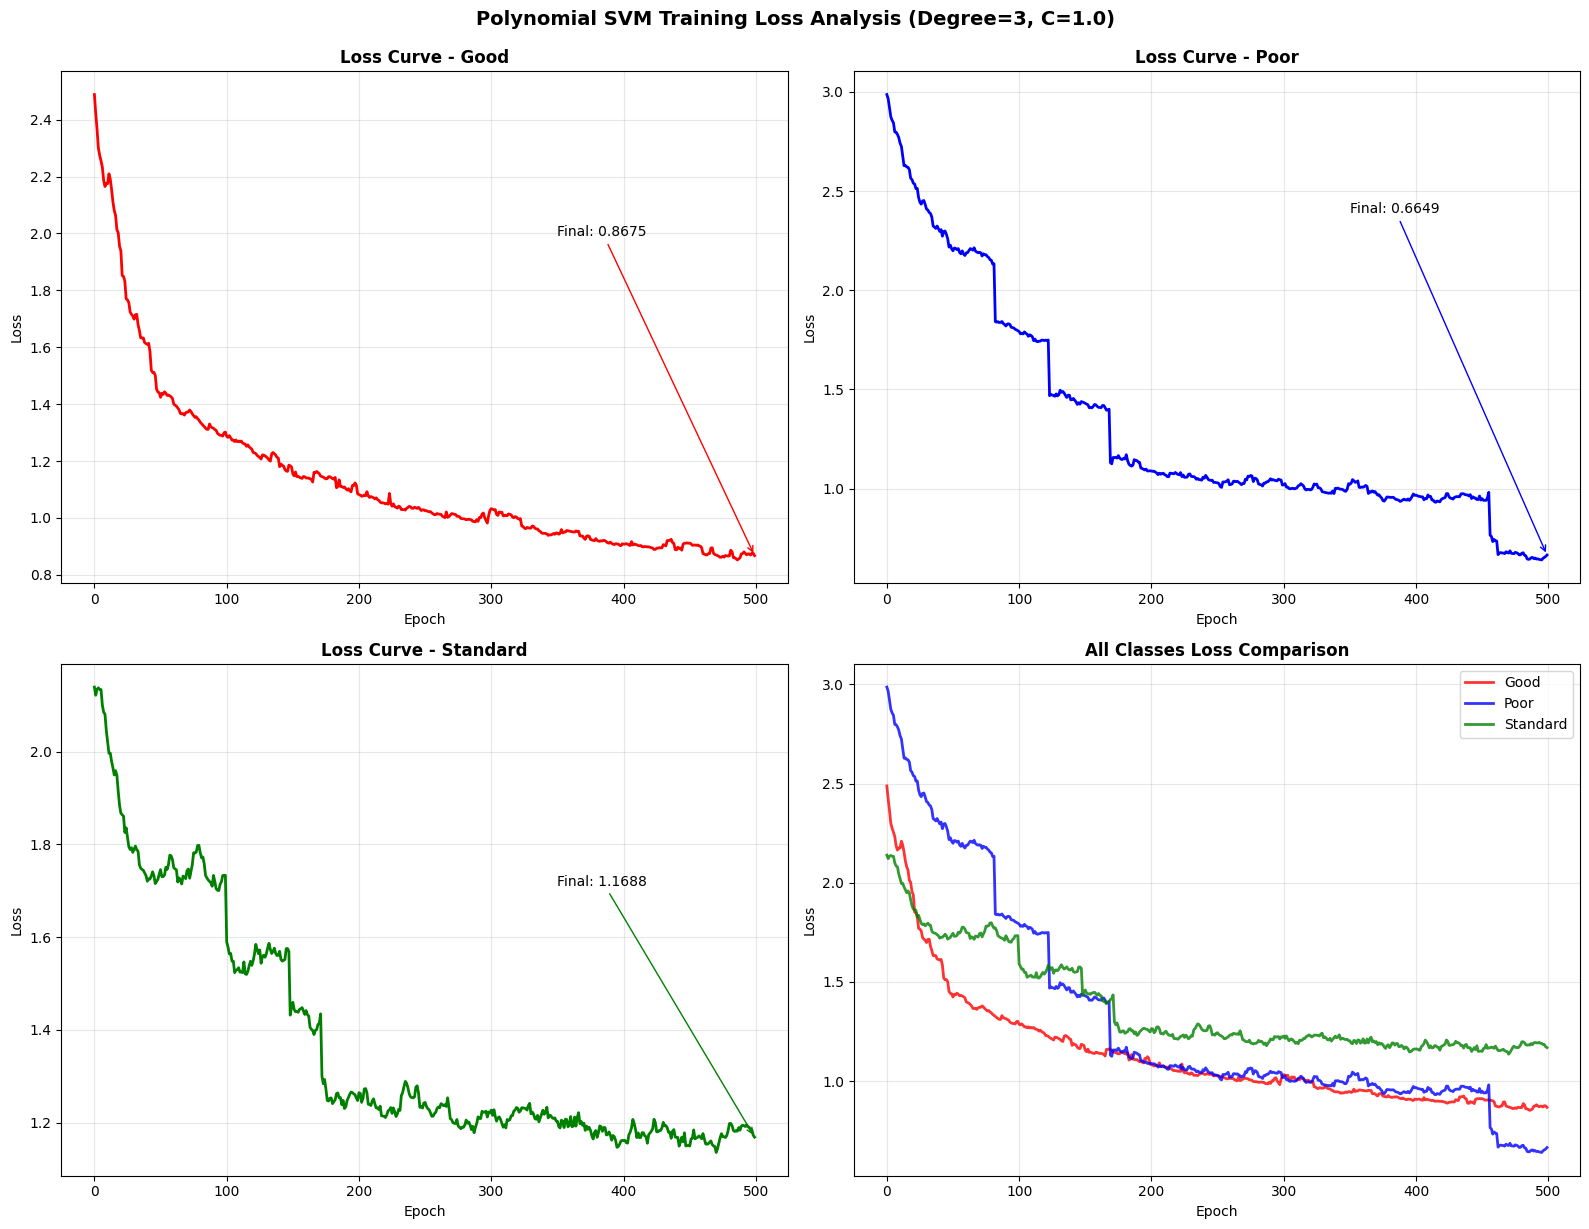

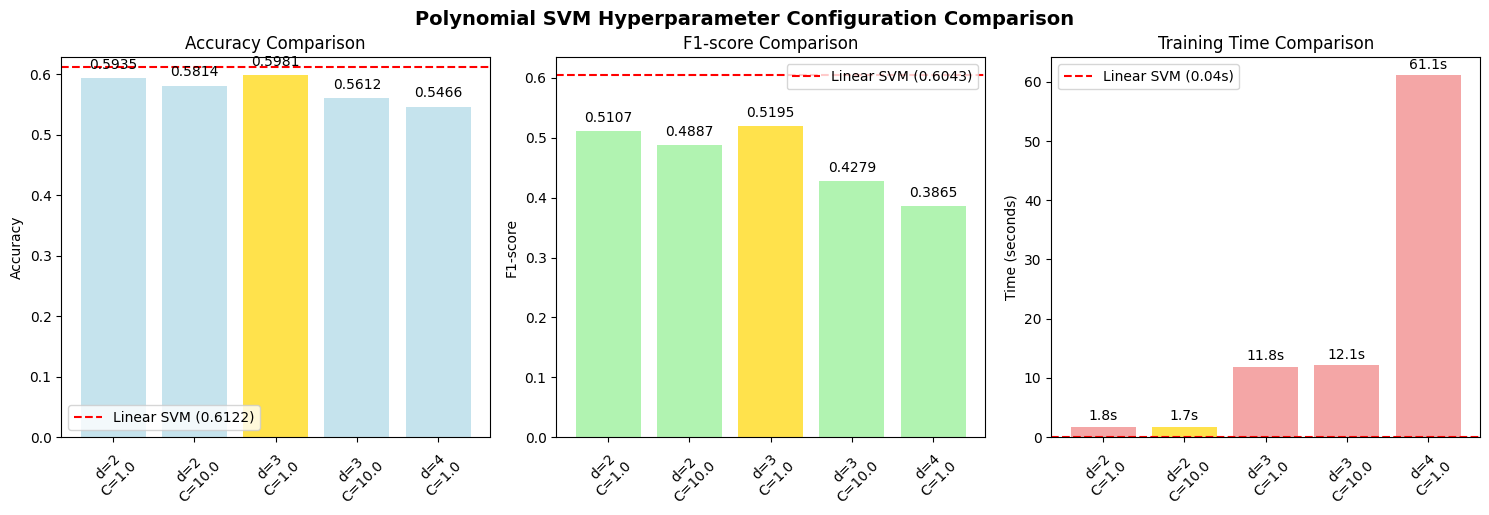


FEATURE IMPORTANCE ANALYSIS
Top 10 most important features (from Linear SVM):
                 feature  importance
11            Credit_Mix    0.316974
12      Outstanding_Debt    0.160725
7    Delay_from_due_date    0.144806
9   Changed_Credit_Limit    0.099186
14    Credit_History_Age    0.097041
17     Payment_Behaviour    0.016642
0                    Age    0.010979
4        Num_Credit_Card    0.007733
1          Annual_Income    0.007506
6            Num_of_Loan    0.006632


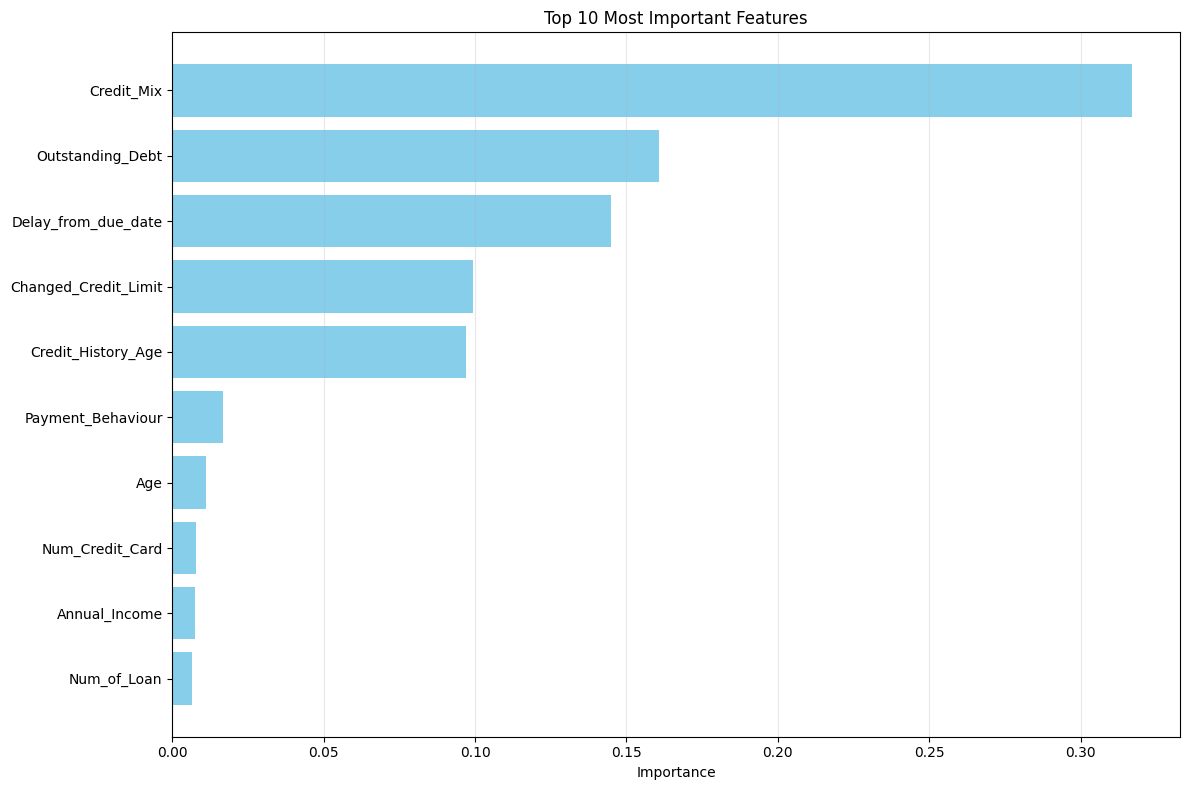


COMPLEXITY ANALYSIS
Original feature dimension: 18
Polynomial feature dimension (degree 3): 1329
Expansion factor: 73.8x
Expected time complexity increase: ~73.8x compared to linear SVM


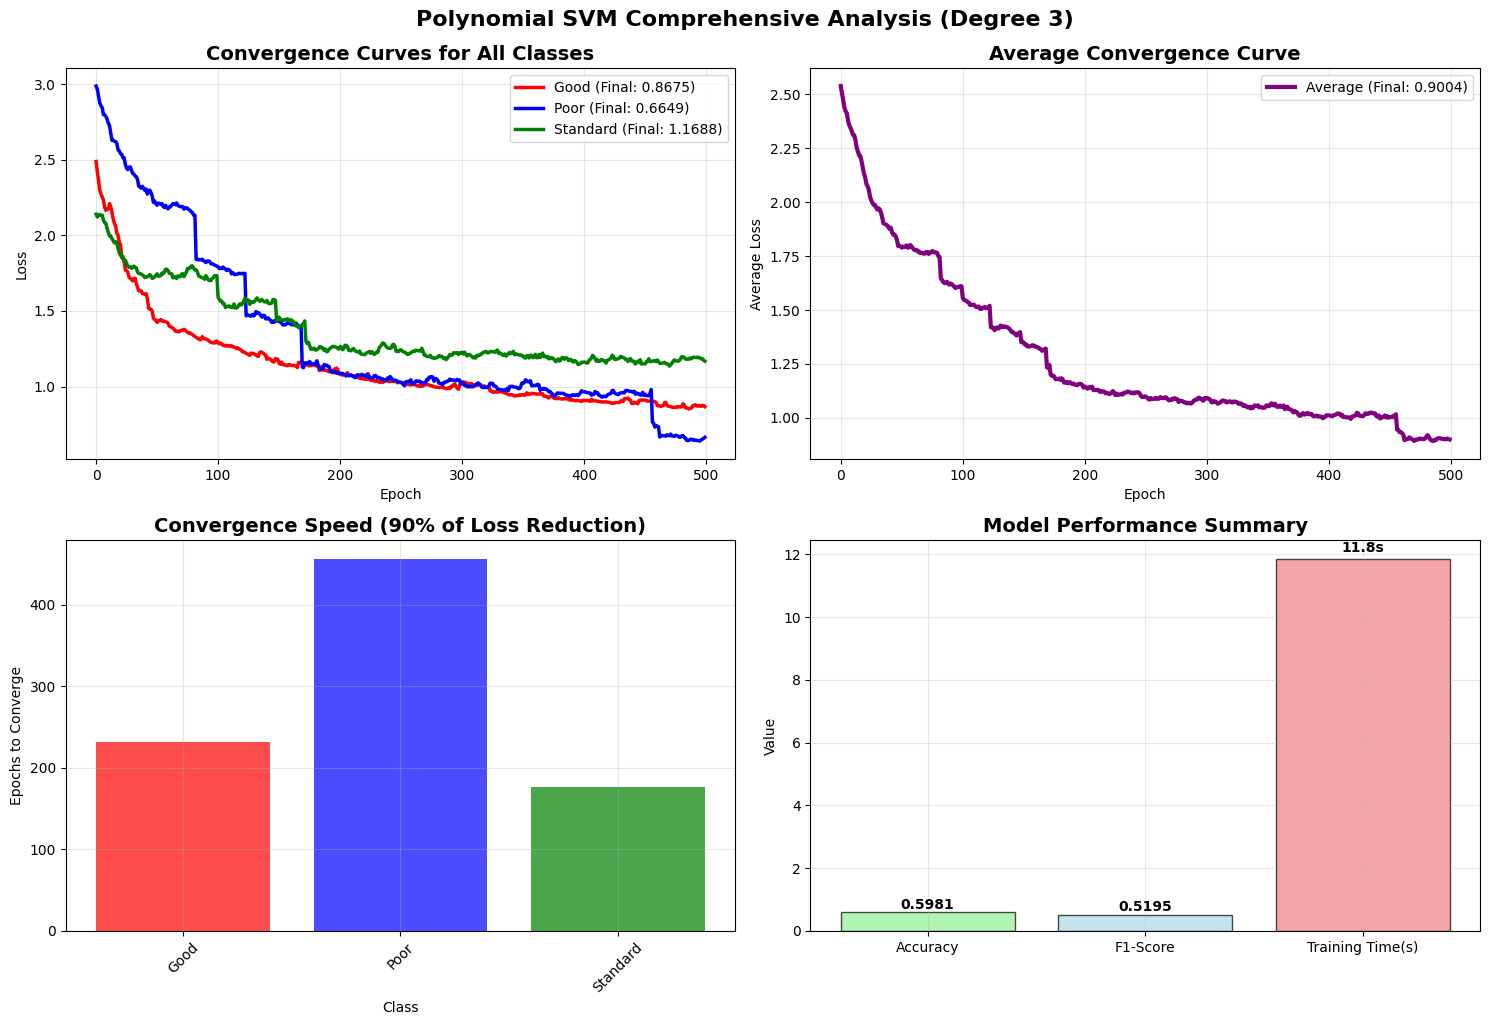


ANALYSIS COMPLETED


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import classification_report, accuracy_score, log_loss, f1_score
import time

# 数据预处理
def load_and_preprocess_data():
    # 这里使用示例数据路径，请根据您的实际文件路径修改
    train_data = pd.read_csv('train_data_m.csv')
    test_data = pd.read_csv('test_data.csv')

    def convert_to_float(age_str):
        if isinstance(age_str, str):
            years, months = map(int, age_str.replace('Years and', '').replace('Months', '').split())
            return years + months / 12.0
        return age_str

    train_data['Credit_History_Age'] = train_data['Credit_History_Age'].apply(convert_to_float)
    test_data['Credit_History_Age'] = test_data['Credit_History_Age'].apply(convert_to_float)

    credit_mix_mapping = {'Good': 2, 'Standard': 1, 'Bad': 0}
    train_data['Credit_Mix'] = train_data['Credit_Mix'].map(credit_mix_mapping)
    test_data['Credit_Mix'] = test_data['Credit_Mix'].map(credit_mix_mapping)

    unique_behaviors = train_data['Payment_Behaviour'].unique()
    behavior_mapping = {behavior: idx for idx, behavior in enumerate(unique_behaviors)}
    train_data['Payment_Behaviour'] = train_data['Payment_Behaviour'].map(behavior_mapping)
    test_data['Payment_Behaviour'] = test_data['Payment_Behaviour'].map(behavior_mapping)

    train_data = train_data.dropna()
    test_data = test_data.dropna()

    features = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
                'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
                'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

    X_train = train_data[features]
    y_train = train_data['Credit_Score']
    X_test = test_data[features]
    y_test = test_data['Credit_Score']

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, le

# 加载数据
X_train, X_test, y_train, y_test, label_encoder = load_and_preprocess_data()

print("=" * 70)
print("DATA LOADING COMPLETED")
print("=" * 70)
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Class distribution: {np.bincount(y_train)}")
print(f"Classes: {label_encoder.classes_}")

class PolynomialSGDSVM:
    def __init__(self, degree=2, C=1.0, learning_rate=0.01, n_iters=1000,
                 gamma=1.0, coef0=1.0, random_state=None):
        self.degree = degree
        self.C = C
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.gamma = gamma
        self.coef0 = coef0
        self.random_state = random_state
        self.models = {}
        self.loss_history = {}
        self.training_times = {}

    def _get_polynomial_features(self, X):
        """生成多项式特征"""
        if not hasattr(self, 'poly_'):
            self.poly_ = PolynomialFeatures(
                degree=self.degree,
                include_bias=False,
                interaction_only=False
            )
            Z = self.poly_.fit_transform(X)

            # 应用多项式核参数 (γx·z + r)^d
            # 这里我们简化处理，主要关注多项式扩展
            if self.gamma != 1.0:
                # 对交互项应用gamma缩放
                feature_degrees = self.poly_.powers_.sum(axis=1)
                scaling_factors = self.gamma ** feature_degrees
                Z = Z * scaling_factors

            if self.coef0 != 0:
                # 添加偏置项
                Z = np.hstack([Z, np.full((Z.shape[0], 1), np.sqrt(self.coef0))])

            return Z
        else:
            Z = self.poly_.transform(X)

            if self.gamma != 1.0:
                feature_degrees = self.poly_.powers_.sum(axis=1)
                scaling_factors = self.gamma ** feature_degrees
                Z = Z * scaling_factors

            if self.coef0 != 0:
                Z = np.hstack([Z, np.full((Z.shape[0], 1), np.sqrt(self.coef0))])

            return Z

    def compute_loss(self, Z, y, w, b):
        """计算SVM损失"""
        margins = y * (np.dot(Z, w) + b)
        hinge_loss = np.maximum(0, 1 - margins)
        reg_term = 0.5 * np.dot(w, w)
        total_loss = reg_term + self.C * np.mean(hinge_loss)
        return total_loss

    def fit_binary_classifier(self, Z, y_binary, class_label):
        """训练二分类器"""
        n_samples, n_features = Z.shape

        # 初始化参数
        rng = np.random.RandomState(self.random_state)
        w = rng.normal(0, 0.01, n_features)
        b = 0.0

        losses = []
        best_loss = float('inf')
        best_w, best_b = w.copy(), b

        print(f"Training polynomial classifier for class {class_label}...")
        print(f"Polynomial feature dimension: {n_features}")

        start_time = time.time()

        for epoch in range(self.n_iters):
            total_loss = 0
            count = 0

            # 学习率衰减
            current_lr = self.learning_rate / (1 + 0.001 * epoch)

            # Mini-batch SGD
            batch_size = min(32, n_samples)
            indices = np.random.choice(n_samples, batch_size, replace=False)

            Z_batch = Z[indices]
            y_batch = y_binary[indices]

            # 计算批量梯度
            predictions = np.dot(Z_batch, w) + b
            margins = y_batch * predictions

            # 计算hinge loss的指示函数
            misclassified = margins < 1
            hinge_grad = -y_batch * misclassified.astype(float)

            # 梯度计算
            w_grad = w + self.C * np.dot(hinge_grad, Z_batch) / batch_size
            b_grad = self.C * np.mean(hinge_grad)

            # 梯度裁剪
            grad_norm = np.linalg.norm(w_grad)
            if grad_norm > 1.0:
                w_grad = w_grad / grad_norm

            # 更新参数
            w = w - current_lr * w_grad
            b = b - current_lr * b_grad

            # 计算损失
            current_loss = self.compute_loss(Z, y_binary, w, b)
            losses.append(current_loss)

            # 保存最佳参数
            if current_loss < best_loss:
                best_loss = current_loss
                best_w, best_b = w.copy(), b

            if epoch % 200 == 0:
                # 计算当前准确率
                current_predictions = np.dot(Z, w) + b
                current_accuracy = np.mean((current_predictions * y_binary) > 0)
                print(f"  Epoch {epoch}: Loss = {current_loss:.4f}, Acc = {current_accuracy:.4f}, LR = {current_lr:.6f}")

        training_time = time.time() - start_time
        self.training_times[class_label] = training_time
        self.loss_history[class_label] = losses

        # 计算最终准确率
        final_predictions = np.dot(Z, best_w) + best_b
        final_accuracy = np.mean((final_predictions * y_binary) > 0)

        print(f"  Class {class_label} completed: Time = {training_time:.2f}s, "
              f"Final Loss = {losses[-1]:.4f}, Accuracy = {final_accuracy:.4f}")

        return best_w, best_b

    def fit(self, X, y):
        """训练模型"""
        print(f"Generating polynomial features (degree={self.degree})...")
        start_time = time.time()
        Z = self._get_polynomial_features(X)
        feature_time = time.time() - start_time
        print(f"Polynomial feature generation time: {feature_time:.2f} seconds")

        self.classes_ = np.unique(y)

        print(f"Feature dimension: {X.shape[1]} -> {Z.shape[1]}")
        print(f"Class distribution: {np.bincount(y)}")

        total_training_start = time.time()

        for class_label in self.classes_:
            y_binary = np.where(y == class_label, 1, -1)
            w, b = self.fit_binary_classifier(Z, y_binary, class_label)
            self.models[class_label] = {'weights': w, 'bias': b}

        self.total_training_time = time.time() - total_training_start
        print(f"Total training time: {self.total_training_time:.2f} seconds")

    def predict_proba(self, X):
        """预测概率"""
        Z = self._get_polynomial_features(X)
        n_samples = Z.shape[0]
        n_classes = len(self.classes_)
        scores = np.zeros((n_samples, n_classes))

        for i, class_label in enumerate(self.classes_):
            model = self.models[class_label]
            scores[:, i] = np.dot(Z, model['weights']) + model['bias']

        # 使用softmax
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return probabilities

    def predict(self, X):
        """预测类别"""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

# 首先尝试线性SVM作为基准
from sklearn.svm import LinearSVC

print("\n" + "=" * 50)
print("BASELINE: LINEAR SVM")
print("=" * 50)

linear_start_time = time.time()
linear_svm = LinearSVC(C=1.0, random_state=42)
linear_svm.fit(X_train, y_train)
linear_training_time = time.time() - linear_start_time

y_pred_linear = linear_svm.predict(X_test)
linear_accuracy = accuracy_score(y_test, y_pred_linear)
linear_f1 = f1_score(y_test, y_pred_linear, average='weighted')

print(f"Linear SVM Accuracy: {linear_accuracy:.4f}")
print(f"Linear SVM F1-score: {linear_f1:.4f}")
print(f"Linear SVM Training Time: {linear_training_time:.2f} seconds")

# 多项式SVM参数搜索
print("\n" + "=" * 50)
print("POLYNOMIAL SVM HYPERPARAMETER SEARCH")
print("=" * 50)

configs = [
    {'degree': 2, 'C': 1.0, 'lr': 0.01, 'gamma': 1.0, 'coef0': 1.0},
    {'degree': 2, 'C': 10.0, 'lr': 0.005, 'gamma': 1.0, 'coef0': 1.0},
    {'degree': 3, 'C': 1.0, 'lr': 0.005, 'gamma': 1.0, 'coef0': 1.0},
    {'degree': 3, 'C': 10.0, 'lr': 0.001, 'gamma': 1.0, 'coef0': 1.0},
    {'degree': 4, 'C': 1.0, 'lr': 0.001, 'gamma': 0.1, 'coef0': 1.0},
]

best_accuracy = 0
best_f1 = 0
best_model = None
best_config = None
all_results = []

for i, config in enumerate(configs):
    print(f"\n--- Config {i+1}: degree={config['degree']}, C={config['C']} ---")

    try:
        model = PolynomialSGDSVM(
            degree=config['degree'],
            C=config['C'],
            learning_rate=config['lr'],
            n_iters=500,
            gamma=config['gamma'],
            coef0=config['coef0'],
            random_state=42
        )

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"Polynomial SVM Accuracy: {accuracy:.4f}")
        print(f"Polynomial SVM F1-score: {f1:.4f}")
        print(f"Polynomial SVM Training Time: {model.total_training_time:.2f} seconds")

        # 保存结果
        result = {
            'config': config,
            'accuracy': accuracy,
            'f1_score': f1,
            'training_time': model.total_training_time,
            'model': model
        }
        all_results.append(result)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_f1 = f1
            best_model = model
            best_config = config

    except Exception as e:
        print(f"Training failed: {e}")

# 评估最佳模型
if best_model:
    print(f"\n" + "=" * 70)
    print("BEST POLYNOMIAL SVM MODEL PERFORMANCE")
    print("=" * 70)

    print(f"Best Configuration:")
    print(f"  Degree: {best_config['degree']}")
    print(f"  C: {best_config['C']}")
    print(f"  Gamma: {best_config['gamma']}")
    print(f"  Coef0: {best_config['coef0']}")
    print(f"  Learning Rate: {best_config['lr']}")

    print(f"\nPerformance Metrics:")
    print(f"  Accuracy: {best_accuracy:.4f}")
    print(f"  F1-score: {best_f1:.4f}")
    print(f"  Training Time: {best_model.total_training_time:.2f} seconds")

    print(f"\nComparison with Linear SVM:")
    print(f"  Accuracy Improvement: {best_accuracy - linear_accuracy:+.4f}")
    print(f"  F1-score Improvement: {best_f1 - linear_f1:+.4f}")
    print(f"  Training Time Difference: {best_model.total_training_time - linear_training_time:+.2f} seconds")

    y_pred_best = best_model.predict(X_test)
    y_proba_best = best_model.predict_proba(X_test)

    print(f"\nDetailed Metrics:")
    print(f"  Log Loss: {log_loss(y_test, y_proba_best):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

    # 绘制损失曲线图
    plt.figure(figsize=(16, 12))

    # 1. 每个类别的损失曲线
    colors = ['red', 'blue', 'green']
    for idx, class_label in enumerate(best_model.classes_):
        plt.subplot(2, 2, idx + 1)
        losses = best_model.loss_history[class_label]
        plt.plot(losses, color=colors[idx], linewidth=2)
        plt.title(f'Loss Curve - {label_encoder.classes_[class_label]}', fontsize=12, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)

        # 添加最终损失值标注
        final_loss = losses[-1]
        plt.annotate(f'Final: {final_loss:.4f}',
                    xy=(len(losses)-1, final_loss),
                    xytext=(len(losses)*0.7, max(losses)*0.8),
                    arrowprops=dict(arrowstyle='->', color=colors[idx]))

    # 2. 所有类别损失对比
    plt.subplot(2, 2, 4)
    for idx, class_label in enumerate(best_model.classes_):
        losses = best_model.loss_history[class_label]
        plt.plot(losses, label=label_encoder.classes_[class_label],
                color=colors[idx], linewidth=2, alpha=0.8)

    plt.title('All Classes Loss Comparison', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle(f'Polynomial SVM Training Loss Analysis (Degree={best_config["degree"]}, C={best_config["C"]})',
                fontsize=14, fontweight='bold', y=1.02)
    plt.show()

    # 绘制配置比较图
    if len(all_results) > 1:
        plt.figure(figsize=(15, 5))

        # 准确率比较
        plt.subplot(1, 3, 1)
        config_names = [f"d={r['config']['degree']}\nC={r['config']['C']}" for r in all_results]
        accuracies = [r['accuracy'] for r in all_results]
        colors = ['lightblue' if i != np.argmax(accuracies) else 'gold' for i in range(len(accuracies))]

        bars = plt.bar(config_names, accuracies, color=colors, alpha=0.7)
        plt.axhline(y=linear_accuracy, color='red', linestyle='--', label=f'Linear SVM ({linear_accuracy:.4f})')
        plt.title('Accuracy Comparison')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, acc in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.4f}', ha='center', va='bottom')

        # F1-score比较
        plt.subplot(1, 3, 2)
        f1_scores = [r['f1_score'] for r in all_results]
        colors = ['lightgreen' if i != np.argmax(f1_scores) else 'gold' for i in range(len(f1_scores))]

        bars = plt.bar(config_names, f1_scores, color=colors, alpha=0.7)
        plt.axhline(y=linear_f1, color='red', linestyle='--', label=f'Linear SVM ({linear_f1:.4f})')
        plt.title('F1-score Comparison')
        plt.ylabel('F1-score')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, f1 in zip(bars, f1_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{f1:.4f}', ha='center', va='bottom')

        # 训练时间比较
        plt.subplot(1, 3, 3)
        training_times = [r['training_time'] for r in all_results]
        colors = ['lightcoral' if i != np.argmin(training_times) else 'gold' for i in range(len(training_times))]

        bars = plt.bar(config_names, training_times, color=colors, alpha=0.7)
        plt.axhline(y=linear_training_time, color='red', linestyle='--',
                   label=f'Linear SVM ({linear_training_time:.2f}s)')
        plt.title('Training Time Comparison')
        plt.ylabel('Time (seconds)')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, time_val in zip(bars, training_times):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(training_times)*0.01,
                    f'{time_val:.1f}s', ha='center', va='bottom')

        plt.tight_layout()
        plt.suptitle('Polynomial SVM Hyperparameter Configuration Comparison', fontsize=14, fontweight='bold', y=1.02)
        plt.show()

else:
    print(f"\nNo successful polynomial SVM training.")
    print(f"Linear SVM - Accuracy: {linear_accuracy:.4f}, F1: {linear_f1:.4f}")

# 特征重要性分析
print("\n" + "=" * 50)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

feature_names = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
                'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
                'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

if hasattr(linear_svm, 'coef_'):
    importance = np.mean(np.abs(linear_svm.coef_), axis=0)
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

    print("Top 10 most important features (from Linear SVM):")
    print(feature_imp.head(10))

    # 绘制特征重要性图
    plt.figure(figsize=(12, 8))
    top_features = feature_imp.head(10)
    plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Top 10 Most Important Features')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

# 复杂度分析
print("\n" + "=" * 50)
print("COMPLEXITY ANALYSIS")
print("=" * 50)

original_dim = X_train.shape[1]
if best_model and hasattr(best_model, 'poly_'):
    poly_dim = best_model.poly_.n_output_features_
    print(f"Original feature dimension: {original_dim}")
    print(f"Polynomial feature dimension (degree {best_config['degree']}): {poly_dim}")
    print(f"Expansion factor: {poly_dim/original_dim:.1f}x")
    print(f"Expected time complexity increase: ~{poly_dim/original_dim:.1f}x compared to linear SVM")

# 绘制收敛分析图
if best_model:
    plt.figure(figsize=(15, 10))

    # 1. 主要收敛曲线
    plt.subplot(2, 2, 1)
    colors = ['red', 'blue', 'green']
    for idx, class_label in enumerate(best_model.classes_):
        losses = best_model.loss_history[class_label]
        plt.plot(losses, color=colors[idx], linewidth=2.5,
                label=f'{label_encoder.classes_[class_label]} (Final: {losses[-1]:.4f})')

    plt.title('Convergence Curves for All Classes', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. 平均收敛曲线
    plt.subplot(2, 2, 2)
    # 计算平均损失
    min_epochs = min(len(losses) for losses in best_model.loss_history.values())
    avg_losses = []
    for epoch in range(min_epochs):
        epoch_loss = np.mean([losses[epoch] for losses in best_model.loss_history.values()])
        avg_losses.append(epoch_loss)

    plt.plot(avg_losses, color='purple', linewidth=3, label=f'Average (Final: {avg_losses[-1]:.4f})')
    plt.title('Average Convergence Curve', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. 收敛速度分析
    plt.subplot(2, 2, 3)
    convergence_epochs = []
    class_names = []

    for class_idx, class_label in enumerate(best_model.classes_):
        losses = best_model.loss_history[class_label]
        initial_loss = losses[0]
        final_loss = losses[-1]
        target_loss = final_loss + 0.1 * (initial_loss - final_loss)  # 90%收敛

        # 找到达到目标损失的epoch
        conv_epoch = next((i for i, loss in enumerate(losses) if loss <= target_loss), len(losses))
        convergence_epochs.append(conv_epoch)
        class_names.append(label_encoder.classes_[class_idx])

    plt.bar(class_names, convergence_epochs, color=colors[:len(class_names)], alpha=0.7)
    plt.title('Convergence Speed (90% of Loss Reduction)', fontsize=14, fontweight='bold')
    plt.xlabel('Class')
    plt.ylabel('Epochs to Converge')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 4. 性能总结
    plt.subplot(2, 2, 4)
    metrics = ['Accuracy', 'F1-Score', 'Training Time(s)']
    values = [best_accuracy, best_f1, best_model.total_training_time]
    colors_bar = ['lightgreen', 'lightblue', 'lightcoral']

    bars = plt.bar(metrics, values, color=colors_bar, alpha=0.7, edgecolor='black')
    plt.title('Model Performance Summary', fontsize=14, fontweight='bold')
    plt.ylabel('Value')

    # 添加数值标注
    for bar, value in zip(bars, values):
        if bar.get_height() < 1:  # 对于准确率和F1分数
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
        else:  # 对于训练时间
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                    f'{value:.1f}s', ha='center', va='bottom', fontweight='bold')

    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle(f'Polynomial SVM Comprehensive Analysis (Degree {best_config["degree"]})',
                fontsize=16, fontweight='bold', y=1.02)
    plt.show()

print("\n" + "=" * 70)
print("ANALYSIS COMPLETED")
print("=" * 70)

DATA LOADING COMPLETED
Training set shape: (11122, 18)
Test set shape: (6939, 18)
Class distribution: [2011 3086 6025]
Classes: ['Good' 'Poor' 'Standard']

BASELINE: LINEAR SVM
Linear SVM Accuracy: 0.6131
Linear SVM F1-score: 0.6043
Linear SVM Training Time: 0.08 seconds

POLYNOMIAL SVM HYPERPARAMETER SEARCH

--- Config 1: degree=2, C=1.0 ---
Generating polynomial features (degree=2)...
Polynomial feature generation time: 0.04 seconds
Feature dimension: 18 -> 190
Class distribution: [2011 3086 6025]
Training polynomial classifier for class 0...
Polynomial feature dimension: 190
  Epoch 0: Loss = 1.0075, Acc = 0.5029, LR = 0.010000
  Epoch 200: Loss = 0.4242, Acc = 0.8192, LR = 0.008333
  Epoch 400: Loss = 0.4018, Acc = 0.8163, LR = 0.007143
  Class 0 completed: Time = 2.11s, Final Loss = 0.3850, Accuracy = 0.8192
Training polynomial classifier for class 1...
Polynomial feature dimension: 190
  Epoch 0: Loss = 1.0038, Acc = 0.5507, LR = 0.010000
  Epoch 200: Loss = 0.6035, Acc = 0.7310,

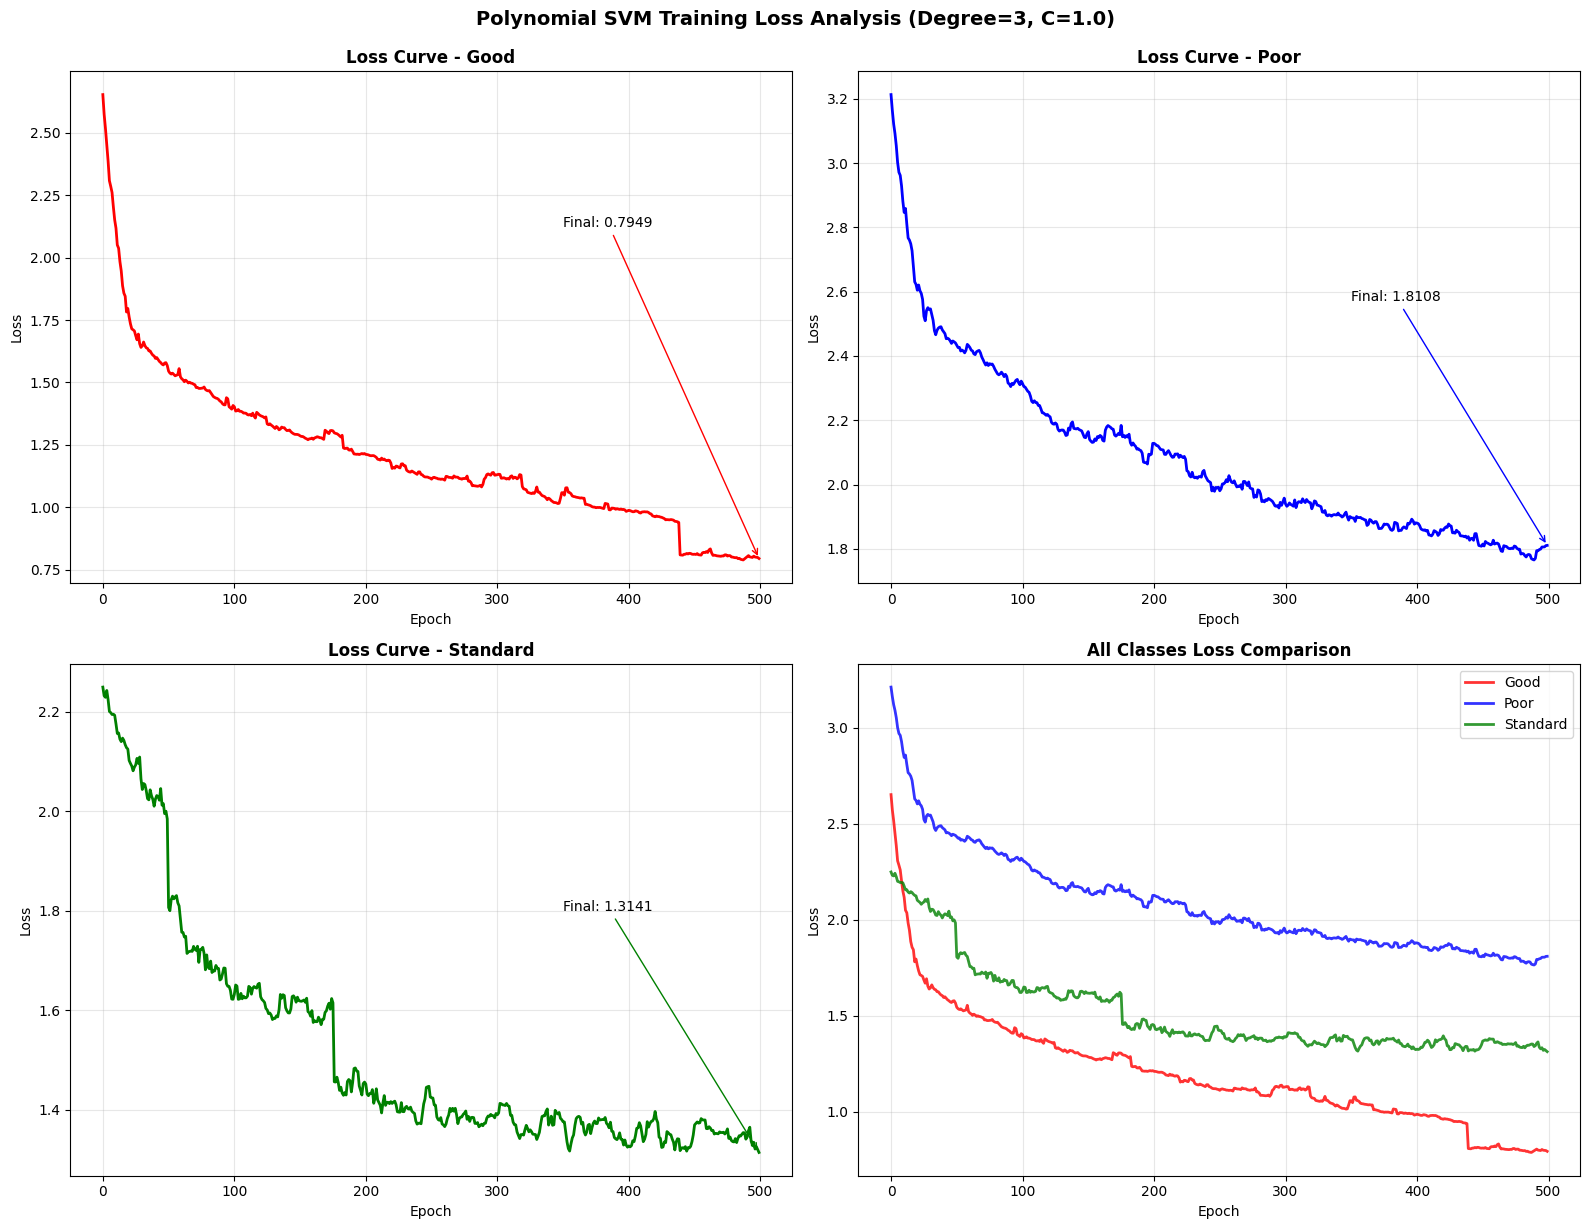

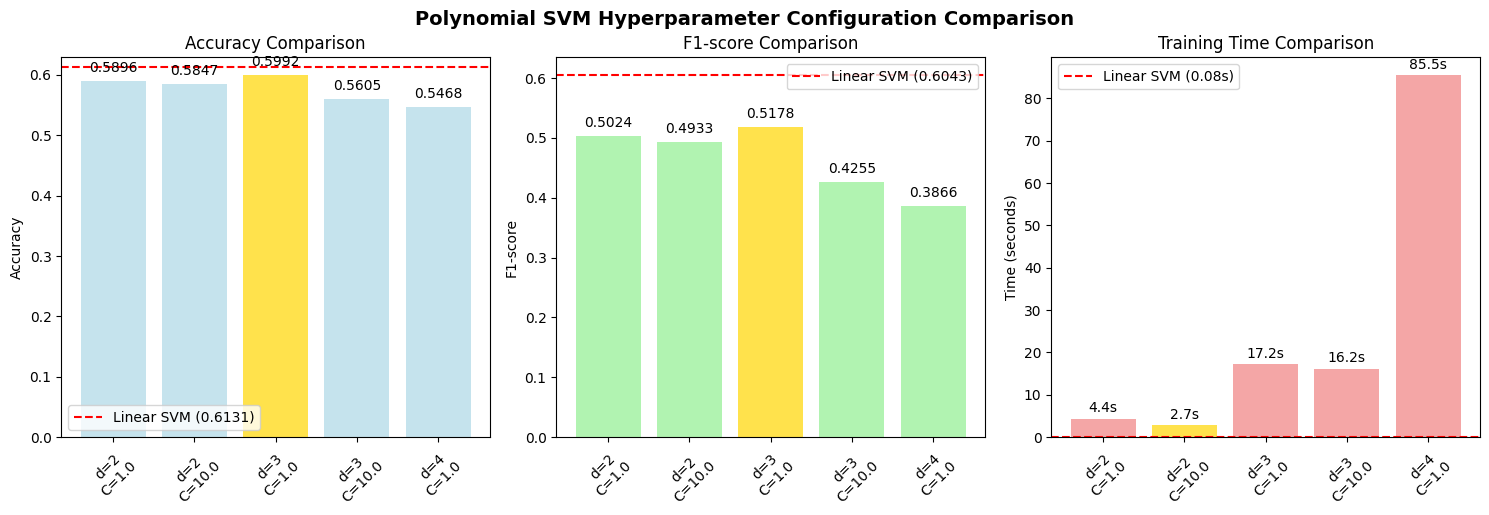


FEATURE IMPORTANCE ANALYSIS
Top 10 most important features (from Linear SVM):
                  feature  importance
11             Credit_Mix    0.307127
12       Outstanding_Debt    0.157980
7     Delay_from_due_date    0.149883
9    Changed_Credit_Limit    0.099238
14     Credit_History_Age    0.088724
0                     Age    0.013527
17      Payment_Behaviour    0.011698
3       Num_Bank_Accounts    0.009100
2   Monthly_Inhand_Salary    0.009085
6             Num_of_Loan    0.007460


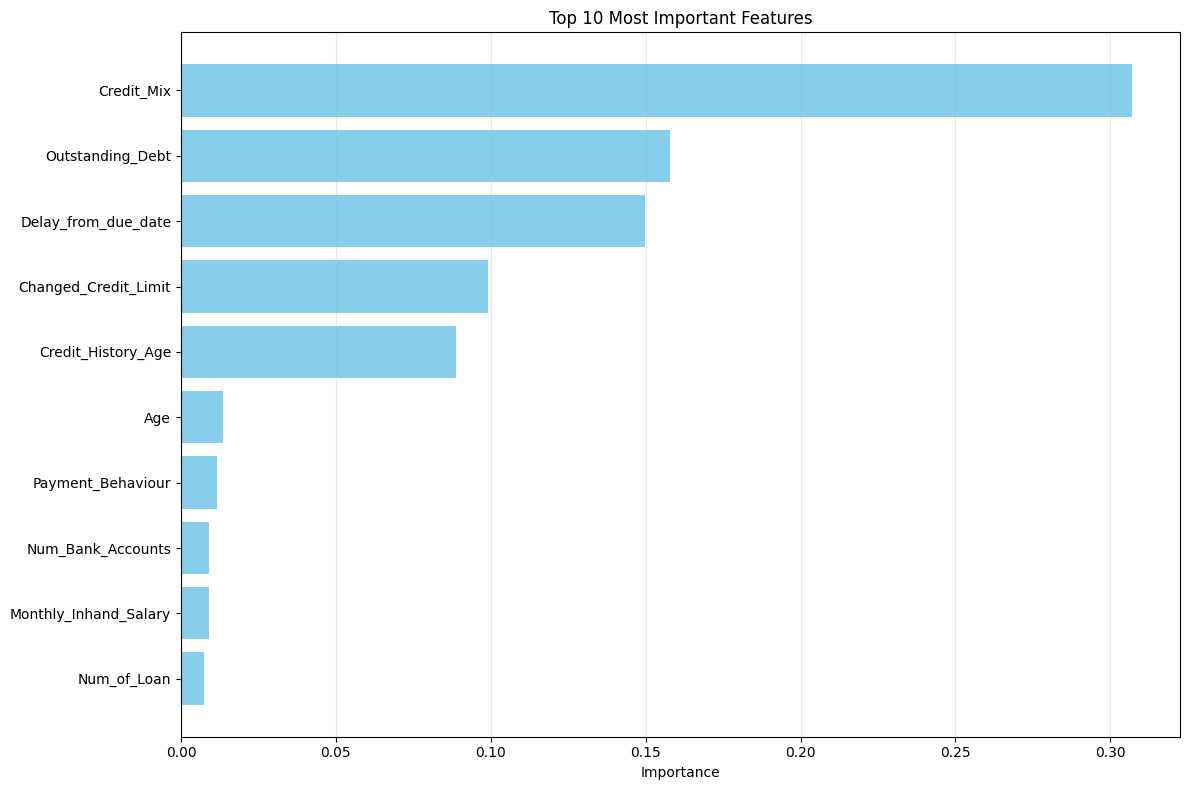


COMPLEXITY ANALYSIS
Original feature dimension: 18
Polynomial feature dimension (degree 3): 1329
Expansion factor: 73.8x
Expected time complexity increase: ~73.8x compared to linear SVM


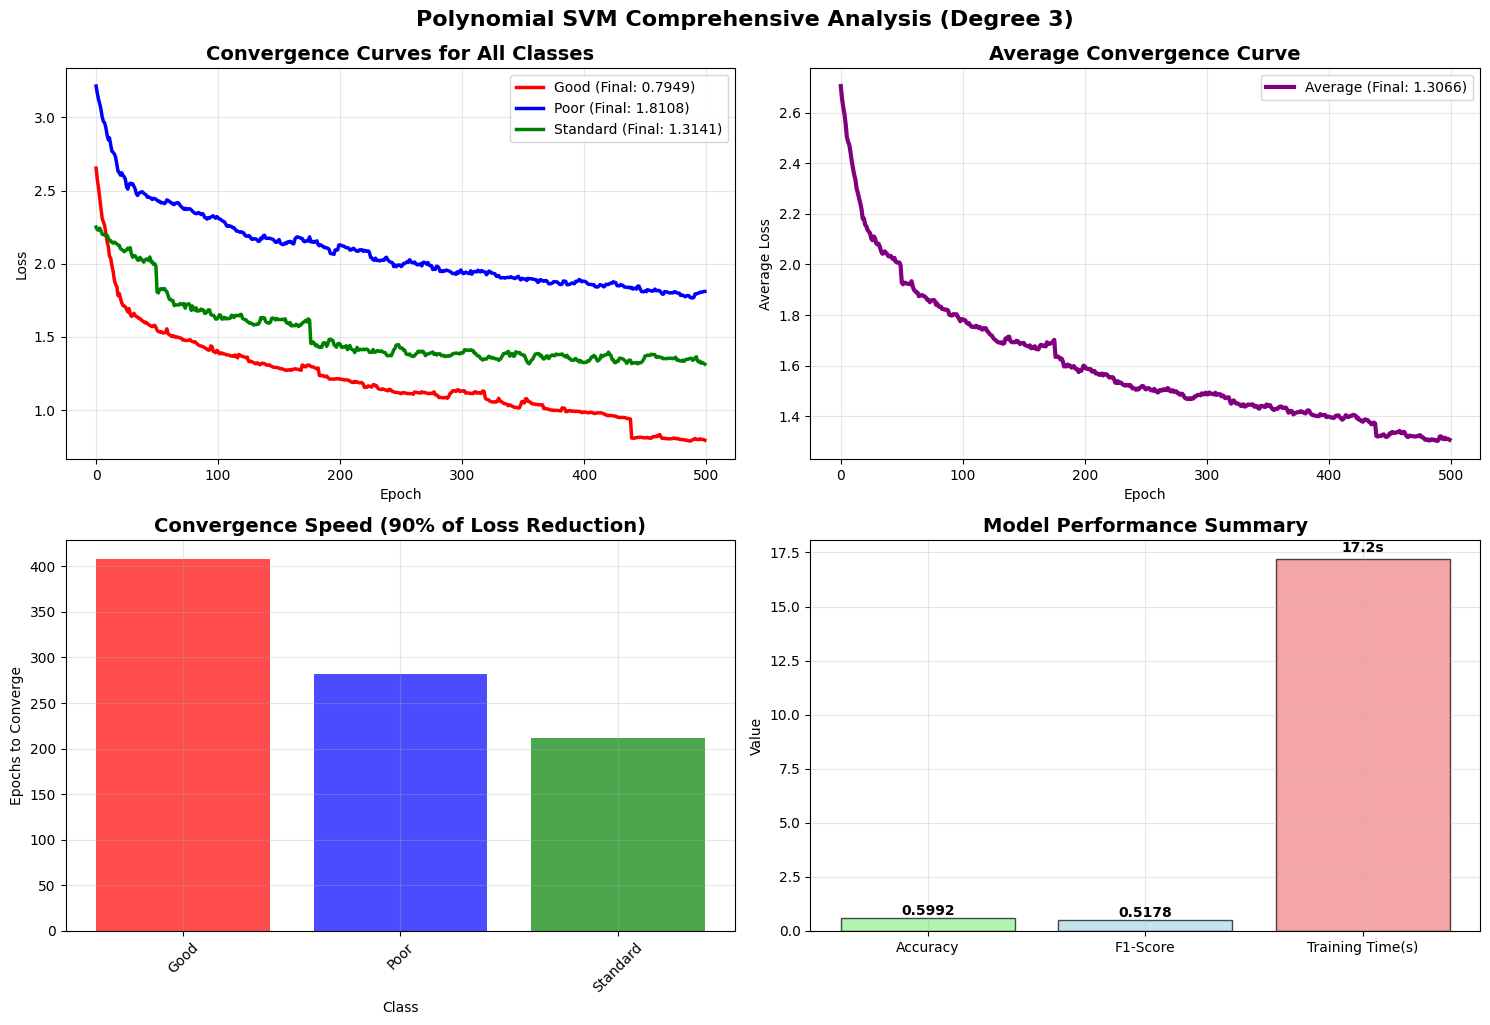


ANALYSIS COMPLETED


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import classification_report, accuracy_score, log_loss, f1_score
import time

# 数据预处理
def load_and_preprocess_data():
    # 这里使用示例数据路径，请根据您的实际文件路径修改
    train_data = pd.read_csv('train_data_l.csv')
    test_data = pd.read_csv('test_data.csv')

    def convert_to_float(age_str):
        if isinstance(age_str, str):
            years, months = map(int, age_str.replace('Years and', '').replace('Months', '').split())
            return years + months / 12.0
        return age_str

    train_data['Credit_History_Age'] = train_data['Credit_History_Age'].apply(convert_to_float)
    test_data['Credit_History_Age'] = test_data['Credit_History_Age'].apply(convert_to_float)

    credit_mix_mapping = {'Good': 2, 'Standard': 1, 'Bad': 0}
    train_data['Credit_Mix'] = train_data['Credit_Mix'].map(credit_mix_mapping)
    test_data['Credit_Mix'] = test_data['Credit_Mix'].map(credit_mix_mapping)

    unique_behaviors = train_data['Payment_Behaviour'].unique()
    behavior_mapping = {behavior: idx for idx, behavior in enumerate(unique_behaviors)}
    train_data['Payment_Behaviour'] = train_data['Payment_Behaviour'].map(behavior_mapping)
    test_data['Payment_Behaviour'] = test_data['Payment_Behaviour'].map(behavior_mapping)

    train_data = train_data.dropna()
    test_data = test_data.dropna()

    features = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
                'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
                'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

    X_train = train_data[features]
    y_train = train_data['Credit_Score']
    X_test = test_data[features]
    y_test = test_data['Credit_Score']

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, le

# 加载数据
X_train, X_test, y_train, y_test, label_encoder = load_and_preprocess_data()

print("=" * 70)
print("DATA LOADING COMPLETED")
print("=" * 70)
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Class distribution: {np.bincount(y_train)}")
print(f"Classes: {label_encoder.classes_}")

class PolynomialSGDSVM:
    def __init__(self, degree=2, C=1.0, learning_rate=0.01, n_iters=1000,
                 gamma=1.0, coef0=1.0, random_state=None):
        self.degree = degree
        self.C = C
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.gamma = gamma
        self.coef0 = coef0
        self.random_state = random_state
        self.models = {}
        self.loss_history = {}
        self.training_times = {}

    def _get_polynomial_features(self, X):
        """生成多项式特征"""
        if not hasattr(self, 'poly_'):
            self.poly_ = PolynomialFeatures(
                degree=self.degree,
                include_bias=False,
                interaction_only=False
            )
            Z = self.poly_.fit_transform(X)

            # 应用多项式核参数 (γx·z + r)^d
            # 这里我们简化处理，主要关注多项式扩展
            if self.gamma != 1.0:
                # 对交互项应用gamma缩放
                feature_degrees = self.poly_.powers_.sum(axis=1)
                scaling_factors = self.gamma ** feature_degrees
                Z = Z * scaling_factors

            if self.coef0 != 0:
                # 添加偏置项
                Z = np.hstack([Z, np.full((Z.shape[0], 1), np.sqrt(self.coef0))])

            return Z
        else:
            Z = self.poly_.transform(X)

            if self.gamma != 1.0:
                feature_degrees = self.poly_.powers_.sum(axis=1)
                scaling_factors = self.gamma ** feature_degrees
                Z = Z * scaling_factors

            if self.coef0 != 0:
                Z = np.hstack([Z, np.full((Z.shape[0], 1), np.sqrt(self.coef0))])

            return Z

    def compute_loss(self, Z, y, w, b):
        """计算SVM损失"""
        margins = y * (np.dot(Z, w) + b)
        hinge_loss = np.maximum(0, 1 - margins)
        reg_term = 0.5 * np.dot(w, w)
        total_loss = reg_term + self.C * np.mean(hinge_loss)
        return total_loss

    def fit_binary_classifier(self, Z, y_binary, class_label):
        """训练二分类器"""
        n_samples, n_features = Z.shape

        # 初始化参数
        rng = np.random.RandomState(self.random_state)
        w = rng.normal(0, 0.01, n_features)
        b = 0.0

        losses = []
        best_loss = float('inf')
        best_w, best_b = w.copy(), b

        print(f"Training polynomial classifier for class {class_label}...")
        print(f"Polynomial feature dimension: {n_features}")

        start_time = time.time()

        for epoch in range(self.n_iters):
            total_loss = 0
            count = 0

            # 学习率衰减
            current_lr = self.learning_rate / (1 + 0.001 * epoch)

            # Mini-batch SGD
            batch_size = min(32, n_samples)
            indices = np.random.choice(n_samples, batch_size, replace=False)

            Z_batch = Z[indices]
            y_batch = y_binary[indices]

            # 计算批量梯度
            predictions = np.dot(Z_batch, w) + b
            margins = y_batch * predictions

            # 计算hinge loss的指示函数
            misclassified = margins < 1
            hinge_grad = -y_batch * misclassified.astype(float)

            # 梯度计算
            w_grad = w + self.C * np.dot(hinge_grad, Z_batch) / batch_size
            b_grad = self.C * np.mean(hinge_grad)

            # 梯度裁剪
            grad_norm = np.linalg.norm(w_grad)
            if grad_norm > 1.0:
                w_grad = w_grad / grad_norm

            # 更新参数
            w = w - current_lr * w_grad
            b = b - current_lr * b_grad

            # 计算损失
            current_loss = self.compute_loss(Z, y_binary, w, b)
            losses.append(current_loss)

            # 保存最佳参数
            if current_loss < best_loss:
                best_loss = current_loss
                best_w, best_b = w.copy(), b

            if epoch % 200 == 0:
                # 计算当前准确率
                current_predictions = np.dot(Z, w) + b
                current_accuracy = np.mean((current_predictions * y_binary) > 0)
                print(f"  Epoch {epoch}: Loss = {current_loss:.4f}, Acc = {current_accuracy:.4f}, LR = {current_lr:.6f}")

        training_time = time.time() - start_time
        self.training_times[class_label] = training_time
        self.loss_history[class_label] = losses

        # 计算最终准确率
        final_predictions = np.dot(Z, best_w) + best_b
        final_accuracy = np.mean((final_predictions * y_binary) > 0)

        print(f"  Class {class_label} completed: Time = {training_time:.2f}s, "
              f"Final Loss = {losses[-1]:.4f}, Accuracy = {final_accuracy:.4f}")

        return best_w, best_b

    def fit(self, X, y):
        """训练模型"""
        print(f"Generating polynomial features (degree={self.degree})...")
        start_time = time.time()
        Z = self._get_polynomial_features(X)
        feature_time = time.time() - start_time
        print(f"Polynomial feature generation time: {feature_time:.2f} seconds")

        self.classes_ = np.unique(y)

        print(f"Feature dimension: {X.shape[1]} -> {Z.shape[1]}")
        print(f"Class distribution: {np.bincount(y)}")

        total_training_start = time.time()

        for class_label in self.classes_:
            y_binary = np.where(y == class_label, 1, -1)
            w, b = self.fit_binary_classifier(Z, y_binary, class_label)
            self.models[class_label] = {'weights': w, 'bias': b}

        self.total_training_time = time.time() - total_training_start
        print(f"Total training time: {self.total_training_time:.2f} seconds")

    def predict_proba(self, X):
        """预测概率"""
        Z = self._get_polynomial_features(X)
        n_samples = Z.shape[0]
        n_classes = len(self.classes_)
        scores = np.zeros((n_samples, n_classes))

        for i, class_label in enumerate(self.classes_):
            model = self.models[class_label]
            scores[:, i] = np.dot(Z, model['weights']) + model['bias']

        # 使用softmax
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return probabilities

    def predict(self, X):
        """预测类别"""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

# 首先尝试线性SVM作为基准
from sklearn.svm import LinearSVC

print("\n" + "=" * 50)
print("BASELINE: LINEAR SVM")
print("=" * 50)

linear_start_time = time.time()
linear_svm = LinearSVC(C=1.0, random_state=42)
linear_svm.fit(X_train, y_train)
linear_training_time = time.time() - linear_start_time

y_pred_linear = linear_svm.predict(X_test)
linear_accuracy = accuracy_score(y_test, y_pred_linear)
linear_f1 = f1_score(y_test, y_pred_linear, average='weighted')

print(f"Linear SVM Accuracy: {linear_accuracy:.4f}")
print(f"Linear SVM F1-score: {linear_f1:.4f}")
print(f"Linear SVM Training Time: {linear_training_time:.2f} seconds")

# 多项式SVM参数搜索
print("\n" + "=" * 50)
print("POLYNOMIAL SVM HYPERPARAMETER SEARCH")
print("=" * 50)

configs = [
    {'degree': 2, 'C': 1.0, 'lr': 0.01, 'gamma': 1.0, 'coef0': 1.0},
    {'degree': 2, 'C': 10.0, 'lr': 0.005, 'gamma': 1.0, 'coef0': 1.0},
    {'degree': 3, 'C': 1.0, 'lr': 0.005, 'gamma': 1.0, 'coef0': 1.0},
    {'degree': 3, 'C': 10.0, 'lr': 0.001, 'gamma': 1.0, 'coef0': 1.0},
    {'degree': 4, 'C': 1.0, 'lr': 0.001, 'gamma': 0.1, 'coef0': 1.0},
]

best_accuracy = 0
best_f1 = 0
best_model = None
best_config = None
all_results = []

for i, config in enumerate(configs):
    print(f"\n--- Config {i+1}: degree={config['degree']}, C={config['C']} ---")

    try:
        model = PolynomialSGDSVM(
            degree=config['degree'],
            C=config['C'],
            learning_rate=config['lr'],
            n_iters=500,
            gamma=config['gamma'],
            coef0=config['coef0'],
            random_state=42
        )

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"Polynomial SVM Accuracy: {accuracy:.4f}")
        print(f"Polynomial SVM F1-score: {f1:.4f}")
        print(f"Polynomial SVM Training Time: {model.total_training_time:.2f} seconds")

        # 保存结果
        result = {
            'config': config,
            'accuracy': accuracy,
            'f1_score': f1,
            'training_time': model.total_training_time,
            'model': model
        }
        all_results.append(result)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_f1 = f1
            best_model = model
            best_config = config

    except Exception as e:
        print(f"Training failed: {e}")

# 评估最佳模型
if best_model:
    print(f"\n" + "=" * 70)
    print("BEST POLYNOMIAL SVM MODEL PERFORMANCE")
    print("=" * 70)

    print(f"Best Configuration:")
    print(f"  Degree: {best_config['degree']}")
    print(f"  C: {best_config['C']}")
    print(f"  Gamma: {best_config['gamma']}")
    print(f"  Coef0: {best_config['coef0']}")
    print(f"  Learning Rate: {best_config['lr']}")

    print(f"\nPerformance Metrics:")
    print(f"  Accuracy: {best_accuracy:.4f}")
    print(f"  F1-score: {best_f1:.4f}")
    print(f"  Training Time: {best_model.total_training_time:.2f} seconds")

    print(f"\nComparison with Linear SVM:")
    print(f"  Accuracy Improvement: {best_accuracy - linear_accuracy:+.4f}")
    print(f"  F1-score Improvement: {best_f1 - linear_f1:+.4f}")
    print(f"  Training Time Difference: {best_model.total_training_time - linear_training_time:+.2f} seconds")

    y_pred_best = best_model.predict(X_test)
    y_proba_best = best_model.predict_proba(X_test)

    print(f"\nDetailed Metrics:")
    print(f"  Log Loss: {log_loss(y_test, y_proba_best):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

    # 绘制损失曲线图
    plt.figure(figsize=(16, 12))

    # 1. 每个类别的损失曲线
    colors = ['red', 'blue', 'green']
    for idx, class_label in enumerate(best_model.classes_):
        plt.subplot(2, 2, idx + 1)
        losses = best_model.loss_history[class_label]
        plt.plot(losses, color=colors[idx], linewidth=2)
        plt.title(f'Loss Curve - {label_encoder.classes_[class_label]}', fontsize=12, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)

        # 添加最终损失值标注
        final_loss = losses[-1]
        plt.annotate(f'Final: {final_loss:.4f}',
                    xy=(len(losses)-1, final_loss),
                    xytext=(len(losses)*0.7, max(losses)*0.8),
                    arrowprops=dict(arrowstyle='->', color=colors[idx]))

    # 2. 所有类别损失对比
    plt.subplot(2, 2, 4)
    for idx, class_label in enumerate(best_model.classes_):
        losses = best_model.loss_history[class_label]
        plt.plot(losses, label=label_encoder.classes_[class_label],
                color=colors[idx], linewidth=2, alpha=0.8)

    plt.title('All Classes Loss Comparison', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle(f'Polynomial SVM Training Loss Analysis (Degree={best_config["degree"]}, C={best_config["C"]})',
                fontsize=14, fontweight='bold', y=1.02)
    plt.show()

    # 绘制配置比较图
    if len(all_results) > 1:
        plt.figure(figsize=(15, 5))

        # 准确率比较
        plt.subplot(1, 3, 1)
        config_names = [f"d={r['config']['degree']}\nC={r['config']['C']}" for r in all_results]
        accuracies = [r['accuracy'] for r in all_results]
        colors = ['lightblue' if i != np.argmax(accuracies) else 'gold' for i in range(len(accuracies))]

        bars = plt.bar(config_names, accuracies, color=colors, alpha=0.7)
        plt.axhline(y=linear_accuracy, color='red', linestyle='--', label=f'Linear SVM ({linear_accuracy:.4f})')
        plt.title('Accuracy Comparison')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, acc in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.4f}', ha='center', va='bottom')

        # F1-score比较
        plt.subplot(1, 3, 2)
        f1_scores = [r['f1_score'] for r in all_results]
        colors = ['lightgreen' if i != np.argmax(f1_scores) else 'gold' for i in range(len(f1_scores))]

        bars = plt.bar(config_names, f1_scores, color=colors, alpha=0.7)
        plt.axhline(y=linear_f1, color='red', linestyle='--', label=f'Linear SVM ({linear_f1:.4f})')
        plt.title('F1-score Comparison')
        plt.ylabel('F1-score')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, f1 in zip(bars, f1_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{f1:.4f}', ha='center', va='bottom')

        # 训练时间比较
        plt.subplot(1, 3, 3)
        training_times = [r['training_time'] for r in all_results]
        colors = ['lightcoral' if i != np.argmin(training_times) else 'gold' for i in range(len(training_times))]

        bars = plt.bar(config_names, training_times, color=colors, alpha=0.7)
        plt.axhline(y=linear_training_time, color='red', linestyle='--',
                   label=f'Linear SVM ({linear_training_time:.2f}s)')
        plt.title('Training Time Comparison')
        plt.ylabel('Time (seconds)')
        plt.xticks(rotation=45)
        plt.legend()

        # 添加数值标注
        for bar, time_val in zip(bars, training_times):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(training_times)*0.01,
                    f'{time_val:.1f}s', ha='center', va='bottom')

        plt.tight_layout()
        plt.suptitle('Polynomial SVM Hyperparameter Configuration Comparison', fontsize=14, fontweight='bold', y=1.02)
        plt.show()

else:
    print(f"\nNo successful polynomial SVM training.")
    print(f"Linear SVM - Accuracy: {linear_accuracy:.4f}, F1: {linear_f1:.4f}")

# 特征重要性分析
print("\n" + "=" * 50)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

feature_names = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
                'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
                'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

if hasattr(linear_svm, 'coef_'):
    importance = np.mean(np.abs(linear_svm.coef_), axis=0)
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

    print("Top 10 most important features (from Linear SVM):")
    print(feature_imp.head(10))

    # 绘制特征重要性图
    plt.figure(figsize=(12, 8))
    top_features = feature_imp.head(10)
    plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Top 10 Most Important Features')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

# 复杂度分析
print("\n" + "=" * 50)
print("COMPLEXITY ANALYSIS")
print("=" * 50)

original_dim = X_train.shape[1]
if best_model and hasattr(best_model, 'poly_'):
    poly_dim = best_model.poly_.n_output_features_
    print(f"Original feature dimension: {original_dim}")
    print(f"Polynomial feature dimension (degree {best_config['degree']}): {poly_dim}")
    print(f"Expansion factor: {poly_dim/original_dim:.1f}x")
    print(f"Expected time complexity increase: ~{poly_dim/original_dim:.1f}x compared to linear SVM")

# 绘制收敛分析图
if best_model:
    plt.figure(figsize=(15, 10))

    # 1. 主要收敛曲线
    plt.subplot(2, 2, 1)
    colors = ['red', 'blue', 'green']
    for idx, class_label in enumerate(best_model.classes_):
        losses = best_model.loss_history[class_label]
        plt.plot(losses, color=colors[idx], linewidth=2.5,
                label=f'{label_encoder.classes_[class_label]} (Final: {losses[-1]:.4f})')

    plt.title('Convergence Curves for All Classes', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. 平均收敛曲线
    plt.subplot(2, 2, 2)
    # 计算平均损失
    min_epochs = min(len(losses) for losses in best_model.loss_history.values())
    avg_losses = []
    for epoch in range(min_epochs):
        epoch_loss = np.mean([losses[epoch] for losses in best_model.loss_history.values()])
        avg_losses.append(epoch_loss)

    plt.plot(avg_losses, color='purple', linewidth=3, label=f'Average (Final: {avg_losses[-1]:.4f})')
    plt.title('Average Convergence Curve', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. 收敛速度分析
    plt.subplot(2, 2, 3)
    convergence_epochs = []
    class_names = []

    for class_idx, class_label in enumerate(best_model.classes_):
        losses = best_model.loss_history[class_label]
        initial_loss = losses[0]
        final_loss = losses[-1]
        target_loss = final_loss + 0.1 * (initial_loss - final_loss)  # 90%收敛

        # 找到达到目标损失的epoch
        conv_epoch = next((i for i, loss in enumerate(losses) if loss <= target_loss), len(losses))
        convergence_epochs.append(conv_epoch)
        class_names.append(label_encoder.classes_[class_idx])

    plt.bar(class_names, convergence_epochs, color=colors[:len(class_names)], alpha=0.7)
    plt.title('Convergence Speed (90% of Loss Reduction)', fontsize=14, fontweight='bold')
    plt.xlabel('Class')
    plt.ylabel('Epochs to Converge')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 4. 性能总结
    plt.subplot(2, 2, 4)
    metrics = ['Accuracy', 'F1-Score', 'Training Time(s)']
    values = [best_accuracy, best_f1, best_model.total_training_time]
    colors_bar = ['lightgreen', 'lightblue', 'lightcoral']

    bars = plt.bar(metrics, values, color=colors_bar, alpha=0.7, edgecolor='black')
    plt.title('Model Performance Summary', fontsize=14, fontweight='bold')
    plt.ylabel('Value')

    # 添加数值标注
    for bar, value in zip(bars, values):
        if bar.get_height() < 1:  # 对于准确率和F1分数
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
        else:  # 对于训练时间
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                    f'{value:.1f}s', ha='center', va='bottom', fontweight='bold')

    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle(f'Polynomial SVM Comprehensive Analysis (Degree {best_config["degree"]})',
                fontsize=16, fontweight='bold', y=1.02)
    plt.show()

print("\n" + "=" * 70)
print("ANALYSIS COMPLETED")
print("=" * 70)